## Dataset

### Two files can be found in subfolder data
'data.csv' = data received from one of our ships during sailing // 4 columns: (utc_time / Latitude / Longitude / SpeedOverGround)

'ports.csv' = database with port names and port location // 4 columns: (Latitude / Longitude / PortName / UN_PortCode) Data

### How can a port call be defined
For the sake of simplicity a port call is defined by the fact that the ship is not moving for a given time period (to be defined by the user) and the distance to the next port is within aforementioned tolerance of +/- 0.5 lat & long.

# 🚢 My Rules for Port Call Detection (Ship is Not Moving)

**Criteria:**

1. **SpeedOverGround (SOG)** is close to zero  
   ➤ Threshold: **< 0.5 knots**

2. **Duration**  
   ➤ Must remain stationary for **at least 30 minutes**  (i.e., at least 10 rows of 3-minute intervals).

3. **Location**  
   ➤ Ship must be **within ±0.5°(latitude/longitude) or 50 km(distance)** of a known port


## 📊 Ship Movement Analysis – Key Questions

### 🔍 Data Quality Check
**Q1.** Is any data missing?  
→ Expected signal frequency is **every 3 minutes**.  
Please provide **proof** of your result.

---

### ⚓ Port Call Detection
**Q2.** What **ports have been called** by the ship?  
→ Provide a list of **unique ports of call**.

**Q3.** What was the **total sailing time**?  
→ Time the ship was **moving between ports** and **not stationary**.

**Q4.** What was the **total distance sailed**?

**Q5.** 📈 **Plot the speed profile** between **two ports of your choice**.

**Q6.** What was the **total time spent** in each port?

**Q7.** How often was each port called?  
→ Please differentiate between **unique port calls**.

---

### 🚀 Speed & Distance Insights
**Q8.** What was the **highest average speed** between two ports?

**Q9.** Can you create a few **interesting statistics/graphs**  
→ Focus on **speed, distance, sailing time**, etc.

---

### 🕒 Port Call Insights
**Q10.** What was the **longest and shortest port call**?

**Q11.** Create some **visualizations or statistics** about the **port calls**.

---

### 🧭 Geo-Calculations & Energy
**Q12.** Compute the **distance between two ports** using Latitude and Longitude.

**Q13.** Given the power demand function:  
&nbsp;&nbsp;&nbsp;&nbsp;_f(v) = 6.874 × v³ − 83.274 × v² + 659.5 × v + 9010_  
→ Compute **total energy consumed** during **sailing time**.

---

### 🎯 Bonus Analysis
**Bonus:** Compare the given `SpeedOverGround` with a **computed speed**  
→ Use Latitude & Longitude.  
→ Evaluate **signal quality**, provide **statistics** and **insights**.

---


# 📊 Ship Movement Analysis – Key Answers

### 🔍 Data Quality Check (Q1)
**Q1.** Is any data missing?  
→ Expected signal frequency is **every 3 minutes**.  
Please provide **proof** of your result.

**Answer** 

**Yes, data is missing — particularly in the position (Latitude, Longitude) and SpeedOverGround fields. Around 0.66% of the data is incomplete.**

**Yes, Expected signal frequency is 3min except for only one signal frequency at timestamp 2022-03-27 03:00:00.**


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic
import seaborn as sns
import geopandas as gpd
import geodatasets
from shapely.geometry import Point
from scipy.spatial import cKDTree
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature



In [2]:

# Load the sailing data
data = pd.read_csv('data/data.csv', sep=';', parse_dates=['utc_time'])

# Load the ports data
ports = pd.read_csv('data/ports.csv', sep=';')

# Preview the data
print("Sailing Data Sample:")
display(data.head())

# Show basic info
print("\nSailing Data Info:")
data.info()

print("Ports Data Sample:")
display(ports.head())

# Show basic info
print("\nPorts Data Info:")
ports.info()

Sailing Data Sample:


utc_time   Latitude  Longitude  SpeedOverGround
0 2021-11-01 00:00:00  28.502392 -16.173216              0.2
1 2021-11-01 00:03:00  28.502504 -16.173239              0.2
2 2021-11-01 00:06:00  28.502357 -16.172995              0.4
3 2021-11-01 00:09:00  28.502151 -16.172777              0.3
4 2021-11-01 00:12:00  28.501982 -16.172600              0.1


Sailing Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116140 entries, 0 to 116139
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   utc_time         116140 non-null  datetime64[ns]
 1   Latitude         115376 non-null  float64       
 2   Longitude        115376 non-null  float64       
 3   SpeedOverGround  115373 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 3.5 MB
Ports Data Sample:


Latitude  Longitude             PortName UN_PortCode
0   57.0425     9.9210              Aalborg       DKAAL
1   56.1500    10.2167               Aarhus       DKAAR
2   57.1500    -2.0500             Aberdeen       GBABD
3  -23.1409   -44.1730  Abraao, Ilha Grande       BRIGE
4   24.4667    54.3667            Abu Dhabi       AEAUH


Ports Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Latitude     880 non-null    float64
 1   Longitude    880 non-null    float64
 2   PortName     880 non-null    object 
 3   UN_PortCode  880 non-null    object 
dtypes: float64(2), object(2)
memory usage: 27.6+ KB


In [3]:
# Sort data by time to ensure chronological order
data = data.sort_values('utc_time')

# Calculate the time difference between consecutive rows in minutes
data['time_diff'] = data['utc_time'].diff().dt.total_seconds() / 60

# Check for gaps
missing_signals = data[data['time_diff'] != 3]  
print(f"Number of missing signals (gap is NOT 3 min): {len(missing_signals)}")

# Optional: show largest gaps
missing_signals.sort_values(by='time_diff', ascending=False).head(10)


Number of missing signals (gap is NOT 3 min): 2


utc_time   Latitude  Longitude  SpeedOverGround  time_diff
70120 2022-03-27 03:00:00  28.343399 -15.301321              9.8       63.0
0     2021-11-01 00:00:00  28.502392 -16.173216              0.2        NaN

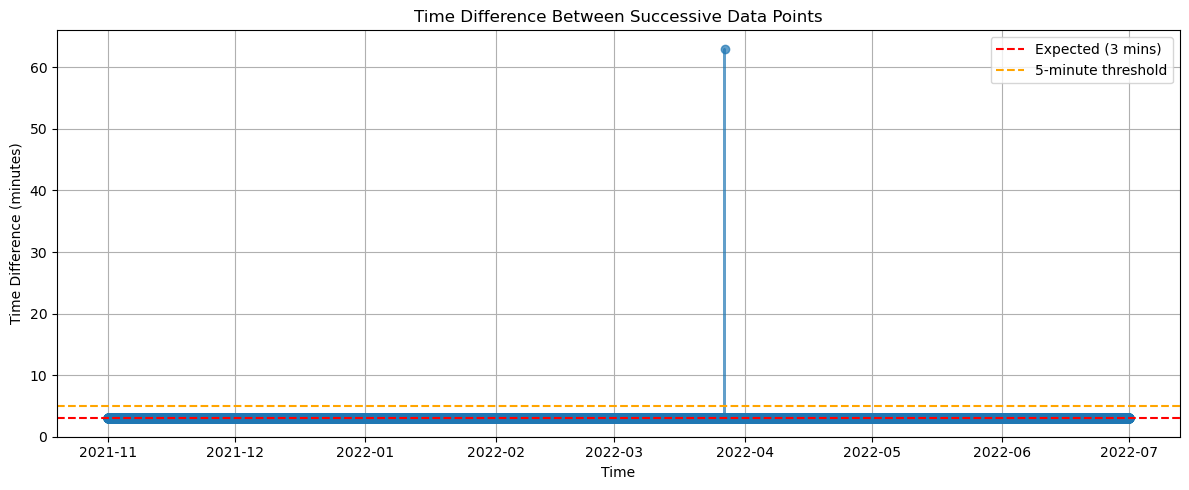

In [4]:

plt.figure(figsize=(12, 5))
plt.plot(data['utc_time'][1:], data['time_diff'][1:], marker='o', linestyle='-', alpha=0.7)
plt.axhline(3, color='red', linestyle='--', label='Expected (3 mins)')
plt.axhline(5, color='orange', linestyle='--', label='5-minute threshold')
plt.title('Time Difference Between Successive Data Points')
plt.xlabel('Time')
plt.ylabel('Time Difference (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
# Save the plot before showing it
plt.savefig('time frequency plot.png', dpi=300)  # You can change the path and filename
plt.show()


In [5]:
# Clean data
data = data.dropna(subset=['Latitude', 'Longitude', 'SpeedOverGround'])

# Sort data by time
data = data.sort_values('utc_time').reset_index(drop=True)


### ⚓ Port Call Detection (Q2-Q7)

#### Q2

What **ports have been called** by the ship?  
→ Provide a list of **unique ports of call**.

**Answer**
```text
Total unique ports called by ship: 26

Ports called by the ship: ['Santa Cruz de Tenerife', 'Brest', 'Rotterdam', 'IJmuiden', 'Hamburg', 'Kristiansand', 'Oslo', 'Zeebrugge', 'La Coruna', 'Lisbon', 'Barcelona', 'Las Palmas, Gran Canaria', 'Funchal, Madeira', 'Puerto del Rosario, Fuerteventura', 'Arrecife, Lanzarote', 'Cherbourg', 'Haugesund', 'Alesund', 'Nordfjordeid', 'Copenhagen', 'Kiel', 'Skagen', 'Stavanger', 'Flam', 'Bergen', 'Olden']


```

**Criteria:**

1. **SpeedOverGround (SOG)** is close to zero  
   ➤ Threshold: **< 0.5 knots**

2. **Duration**  
   ➤ Must remain stationary for **at least 30 minutes**  (i.e., at least 10 rows of 3-minute intervals).

3. **Location**  
   ➤ Ship must be **within ±0.5°(latitude/longitude) or 50 km(distance)** of a known port

In [6]:


# Parameters
SOG_THRESHOLD = 0.5  # knots
DISTANCE_THRESHOLD = 50  # km
MIN_DURATION = pd.Timedelta(minutes=30)

# Create KDTree for ports
port_coords = ports[['Latitude', 'Longitude']].values
tree = cKDTree(np.radians(port_coords))

# Find nearest port for each data point
data_coords = np.radians(data[['Latitude', 'Longitude']].values)
distances, indices = tree.query(data_coords, k=1)
data['nearest_port_index'] = indices
data['nearest_port'] = ports['PortName'].iloc[indices].values
data['distance_to_nearest_port_km'] = data.apply(
    lambda row: geodesic((row['Latitude'], row['Longitude']), port_coords[row['nearest_port_index']]).km,
    axis=1
)

# Mark stationary and near-port points
data['is_stationary'] = data['SpeedOverGround'] < SOG_THRESHOLD
data['is_near_port'] = data['distance_to_nearest_port_km'] <= DISTANCE_THRESHOLD

# Group consecutive stationary points near the same port
data['group'] = (
    (data['is_stationary'] != data['is_stationary'].shift()) |
    (data['nearest_port'] != data['nearest_port'].shift())
).cumsum()

# Identify port calls
stationary_groups = data[data['is_stationary'] & data['is_near_port']].groupby('group')
port_calls = []
for group_id, group in stationary_groups:
    start_time = group['utc_time'].min()
    end_time = group['utc_time'].max()
    duration = end_time - start_time
    if duration >= MIN_DURATION:
        port_name = group['nearest_port'].iloc[0]
        port_calls.append({
            'port': port_name,
            'start_time': start_time,
            'end_time': end_time,
            'duration': duration
        })

port_calls_df = pd.DataFrame(port_calls)
port_calls_df.head()

port          start_time            end_time  \
0  Santa Cruz de Tenerife 2021-11-01 00:00:00 2021-11-01 01:24:00   
1  Santa Cruz de Tenerife 2021-11-01 01:30:00 2021-11-01 03:00:00   
2  Santa Cruz de Tenerife 2021-11-01 04:09:00 2021-11-01 09:21:00   
3  Santa Cruz de Tenerife 2021-11-01 10:42:00 2021-11-01 16:24:00   
4  Santa Cruz de Tenerife 2021-11-01 17:51:00 2021-11-01 19:21:00   

         duration  
0 0 days 01:24:00  
1 0 days 01:30:00  
2 0 days 05:12:00  
3 0 days 05:42:00  
4 0 days 01:30:00

In [7]:
unique_ports = port_calls_df['port'].unique()
print("\nPorts called by the ship:", unique_ports.tolist())
print("\nTotal unique ports called by ship:", len(unique_ports))


Ports called by the ship: ['Santa Cruz de Tenerife', 'Brest', 'Rotterdam', 'IJmuiden', 'Hamburg', 'Kristiansand', 'Oslo', 'Zeebrugge', 'La Coruna', 'Lisbon', 'Barcelona', 'Las Palmas, Gran Canaria', 'Funchal, Madeira', 'Puerto del Rosario, Fuerteventura', 'Arrecife, Lanzarote', 'Cherbourg', 'Haugesund', 'Alesund', 'Nordfjordeid', 'Copenhagen', 'Kiel', 'Skagen', 'Stavanger', 'Flam', 'Bergen', 'Olden']

Total unique ports called by ship: 26



#### Q3
What was the **total sailing time**?  
→ Time the ship was **moving between ports** and **not stationary**.

**Answer**


```text
Total sailing time: 174957.00 minutes (~2915.95 hours) (~121.50 days)
```

The ship that does not satisfy all 3 port-call conditions simultaneously, i.e.:
1. Either it's moving faster (SOG >= 0.5),

2. Or it's not staying slow long enough (< 30 minutes),

3. Or it's not near any known port



In [8]:
# Calculate time intervals between consecutive points
data['time_interval'] = data['utc_time'].diff().shift(-1).dt.total_seconds() / 60  # in minutes

# Total sailing time where SOG >= 0.5 knots
sailing_time = data[data['SpeedOverGround'] >= SOG_THRESHOLD]['time_interval'].sum()
sailing_hours = sailing_time / 60  # convert to hours
sailing_days = sailing_hours / 24  # convert to hours
print(f"Total sailing time: {sailing_time:.2f} minutes (~{sailing_hours:.2f} hours) (~{sailing_days:.2f} days)")


Total sailing time: 174957.00 minutes (~2915.95 hours) (~121.50 days)


#### Q4
What was the **total distance sailed**?

**Answer**
```text
Total distance sailed: 62557.45 km (~33778.34 nautical miles)
```

In [9]:
# Function to calculate distance between consecutive points
def calculate_distance(row1, row2):
    coord1 = (row1['Latitude'], row1['Longitude'])
    coord2 = (row2['Latitude'], row2['Longitude'])
    return geodesic(coord1, coord2).km

# Calculate distances
distances = []
for i in range(len(data) - 1):
    dist = calculate_distance(data.iloc[i], data.iloc[i + 1])
    distances.append(dist)
distances.append(np.nan)  # Last row has no next point
data['distance_km'] = distances

# Total distance sailed where SOG >= 0.5 knots
total_distance_km = data[data['SpeedOverGround'] >= SOG_THRESHOLD]['distance_km'].sum()
total_distance_nm = total_distance_km * 0.539957  # 1 km ≈ 0.539957 nautical miles

#  Display result
print(f"Total distance sailed: {total_distance_km:.2f} km (~{total_distance_nm:.2f} nautical miles)")


Total distance sailed: 62300.97 km (~33639.84 nautical miles)


#### Q5
📈 **Plot the speed profile** between **two ports of your choice**.

**Answer**
```text
Check the plot folder, where you will see all the profiles between two port travels.
```

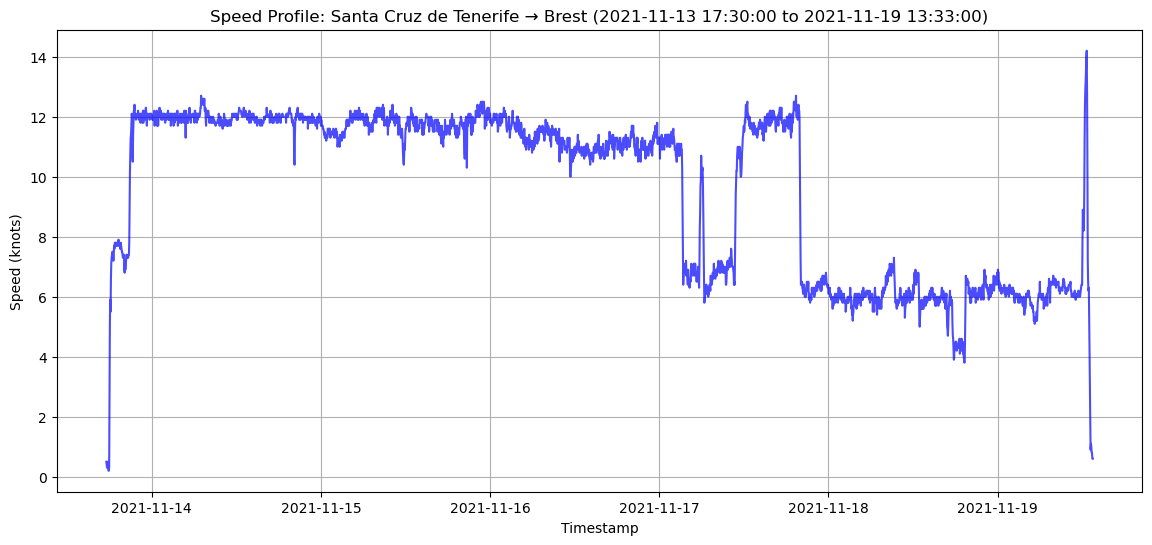

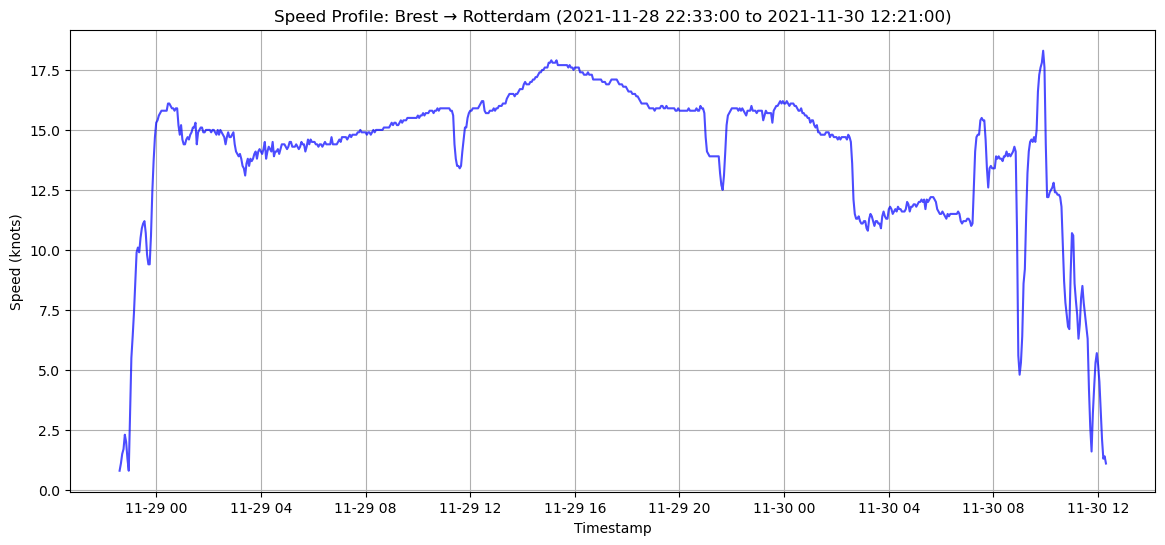

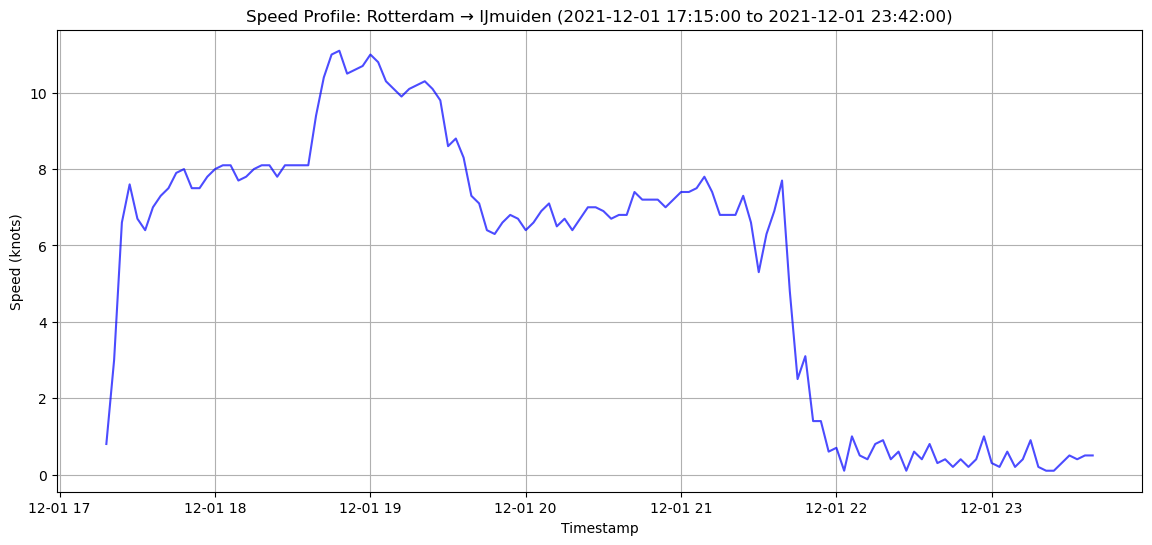

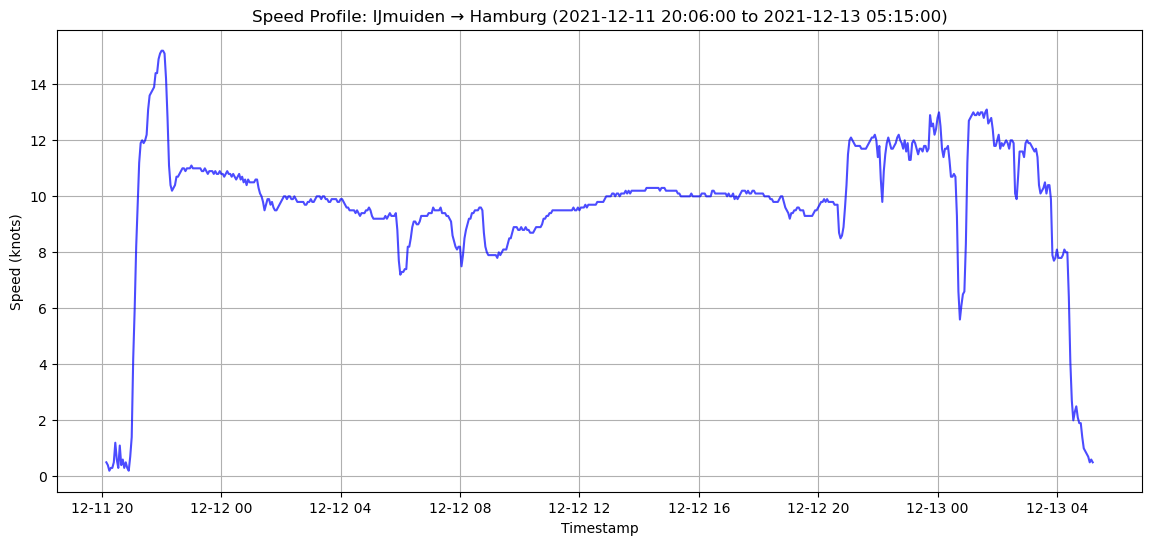

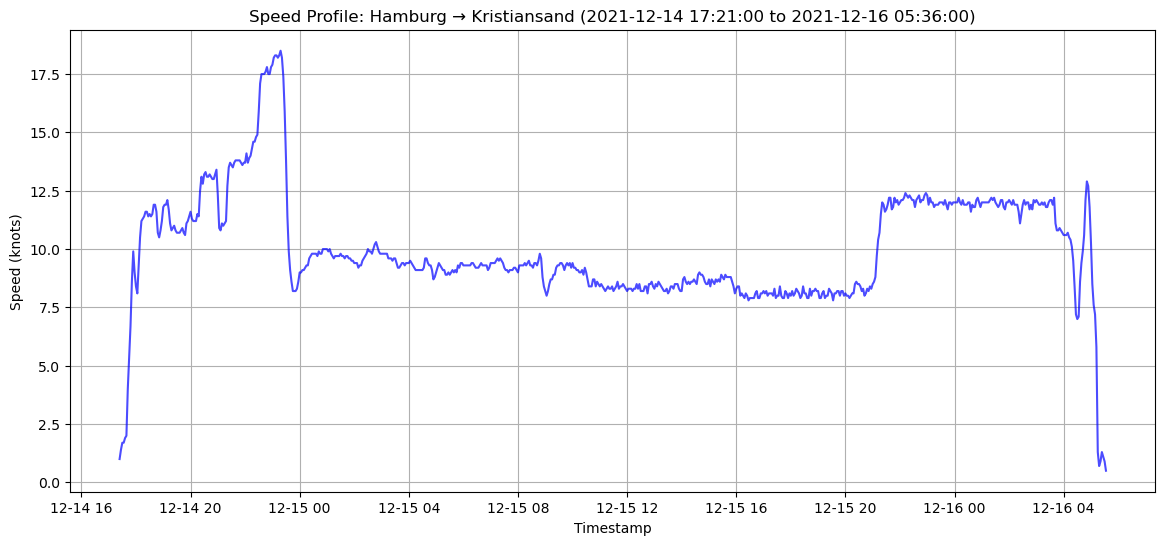

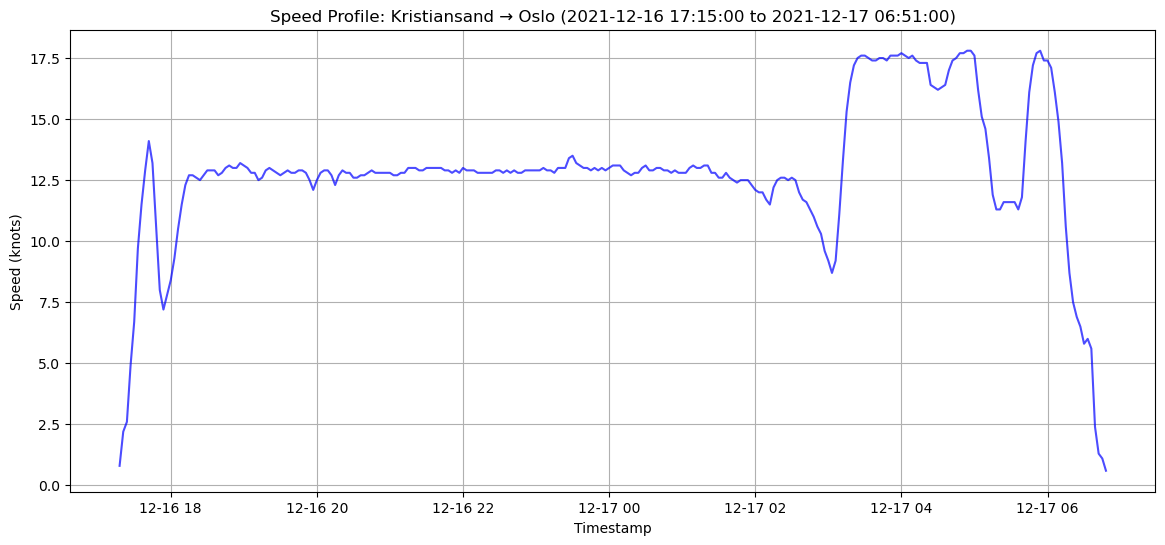

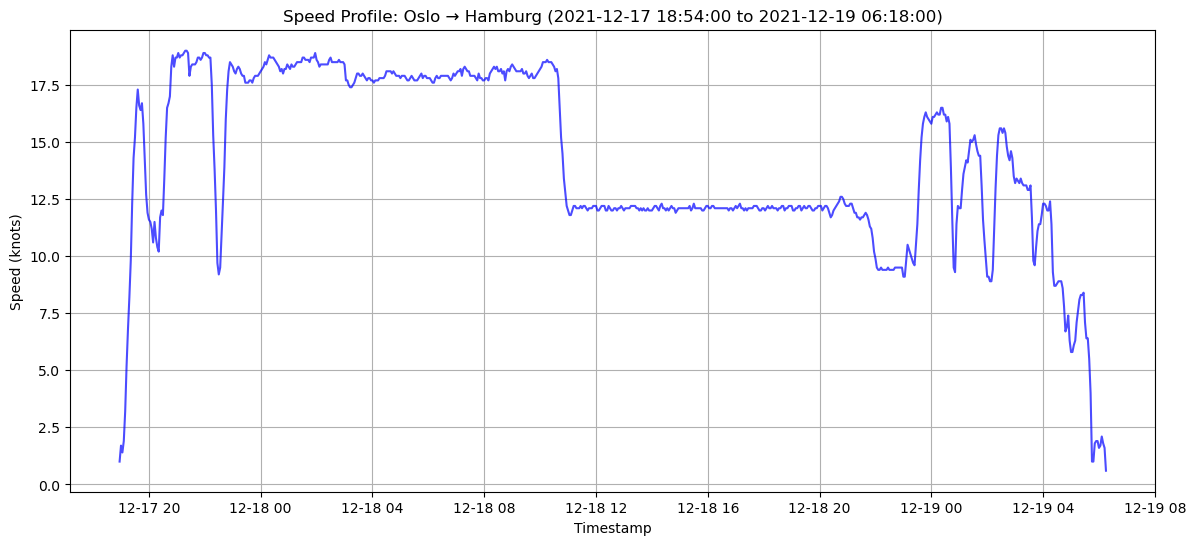

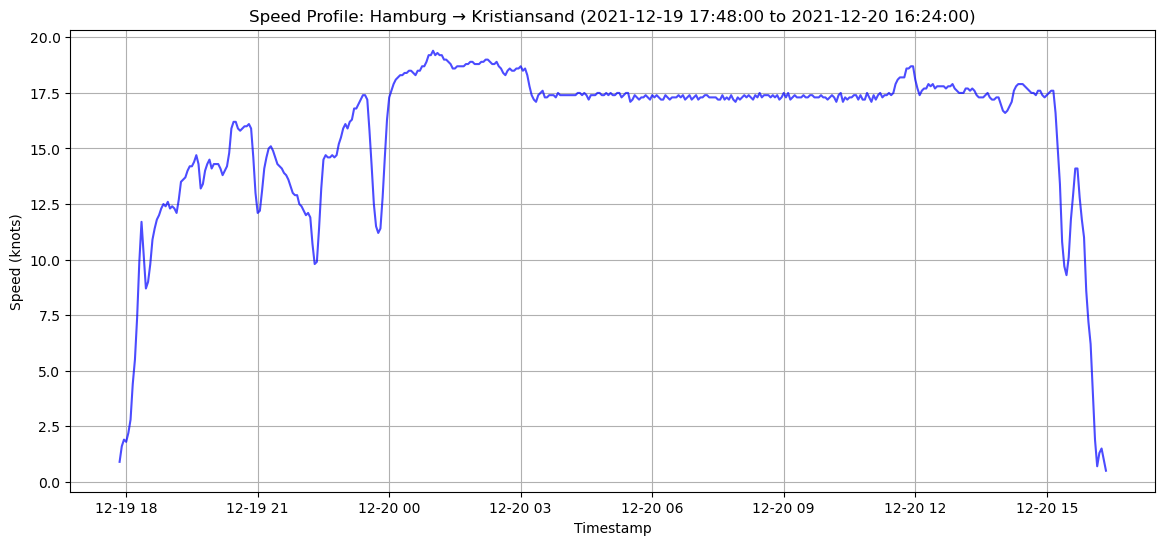

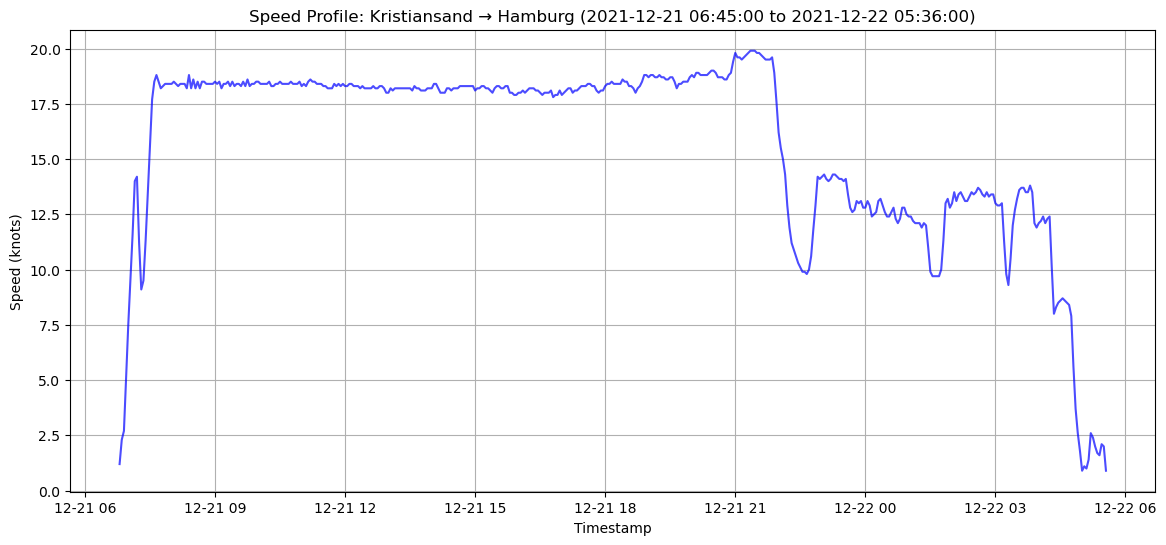

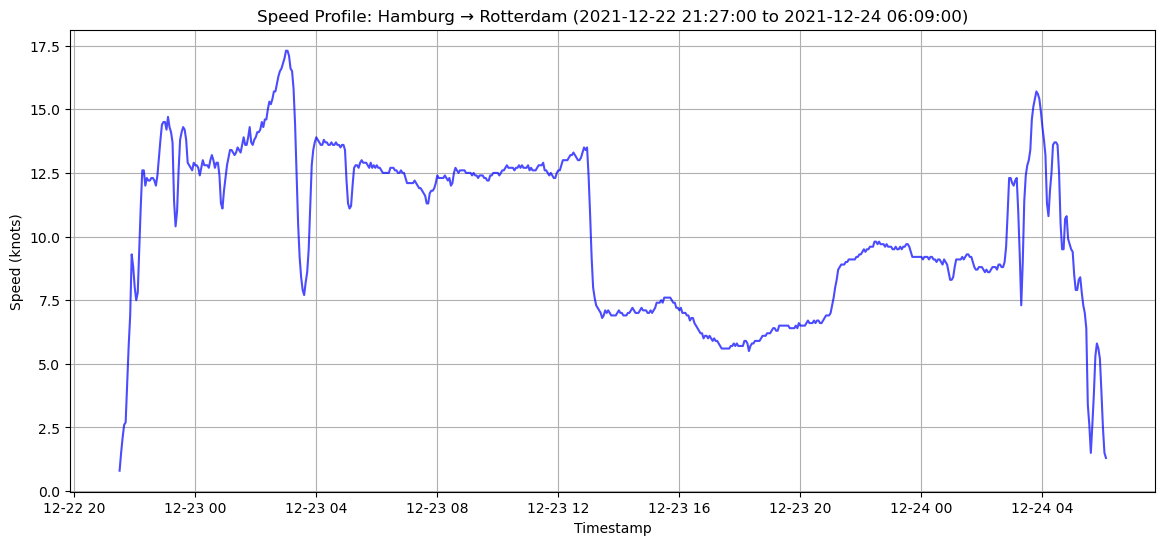

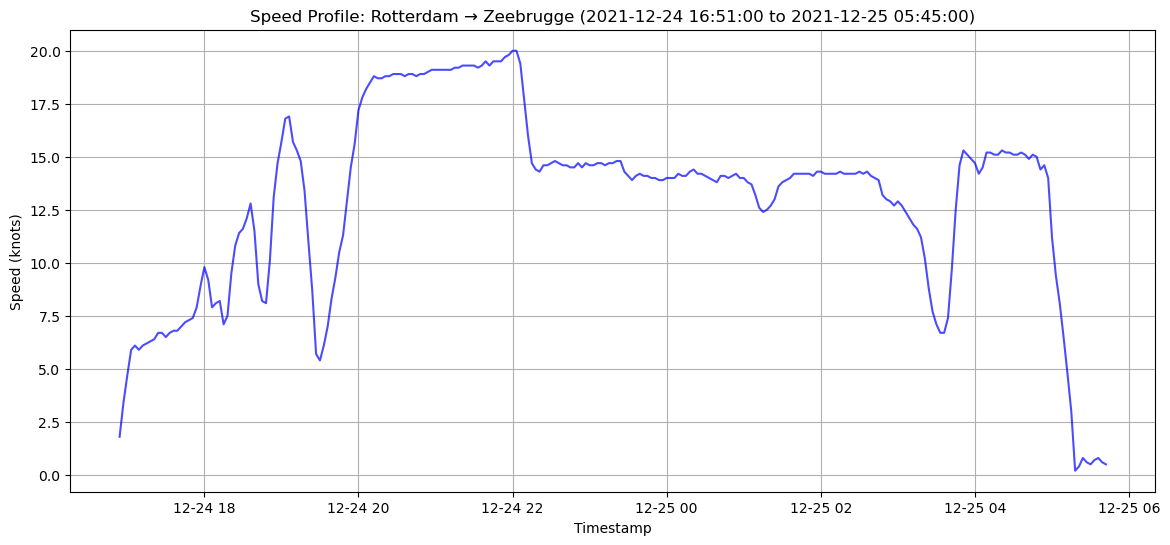

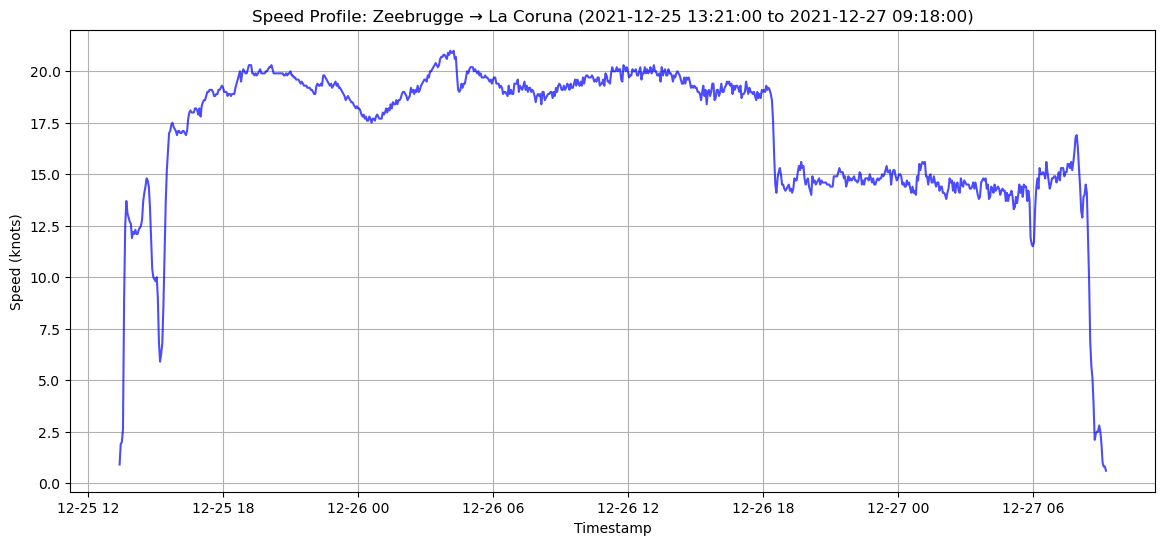

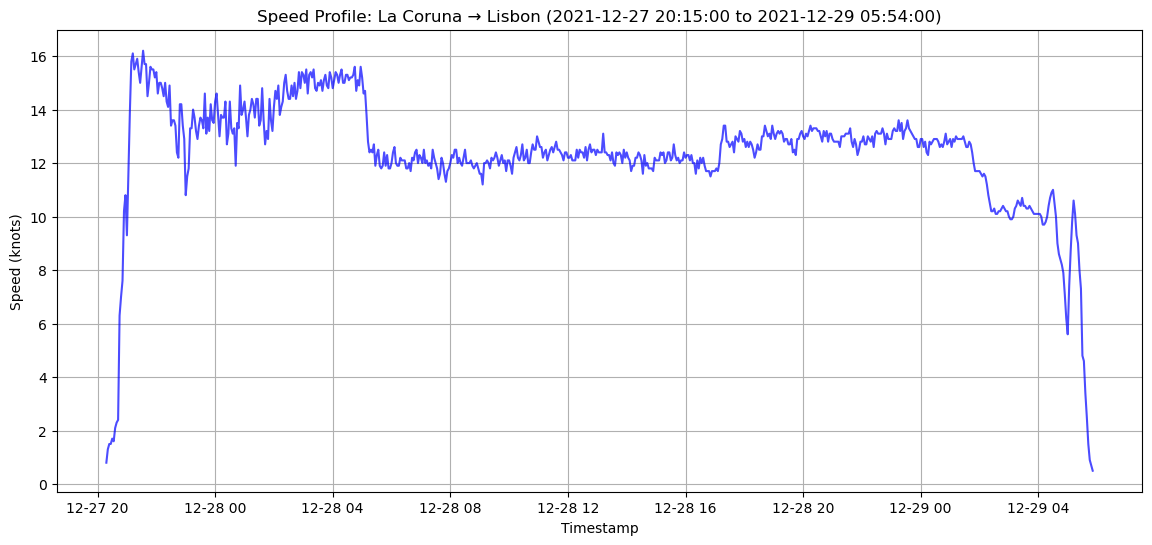

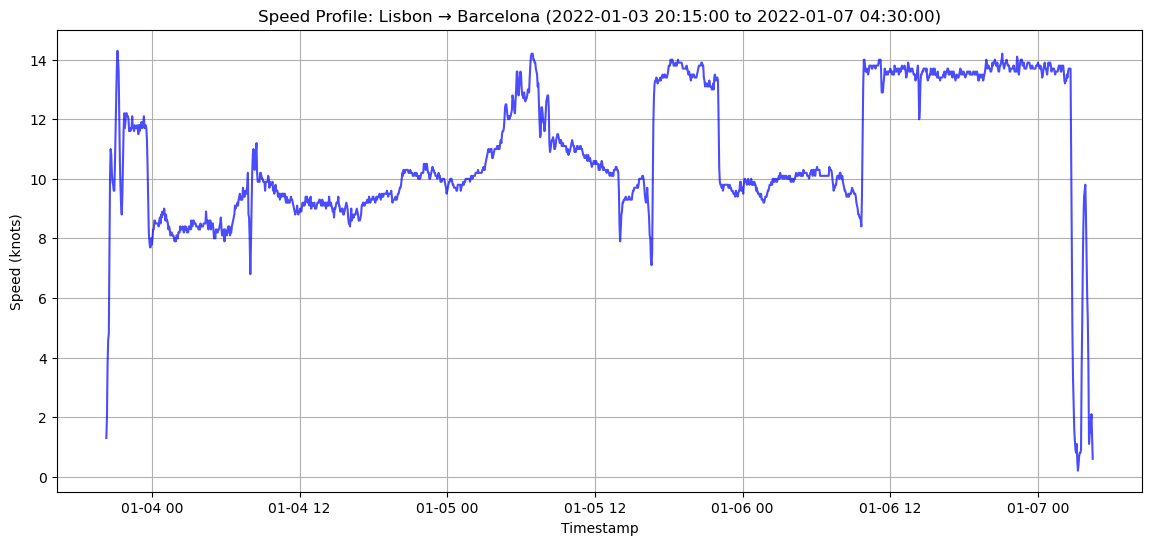

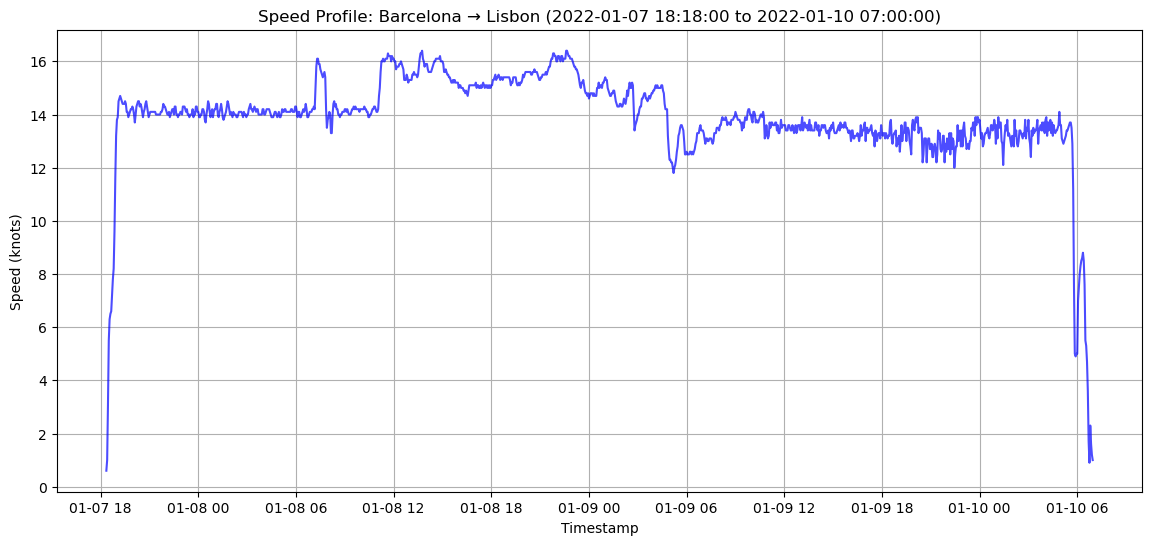

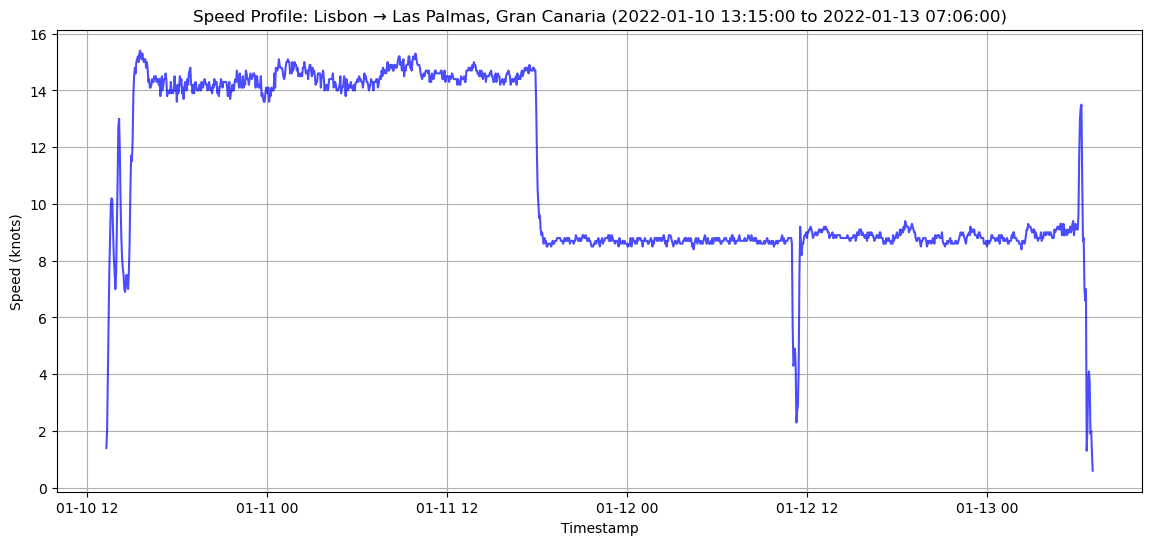

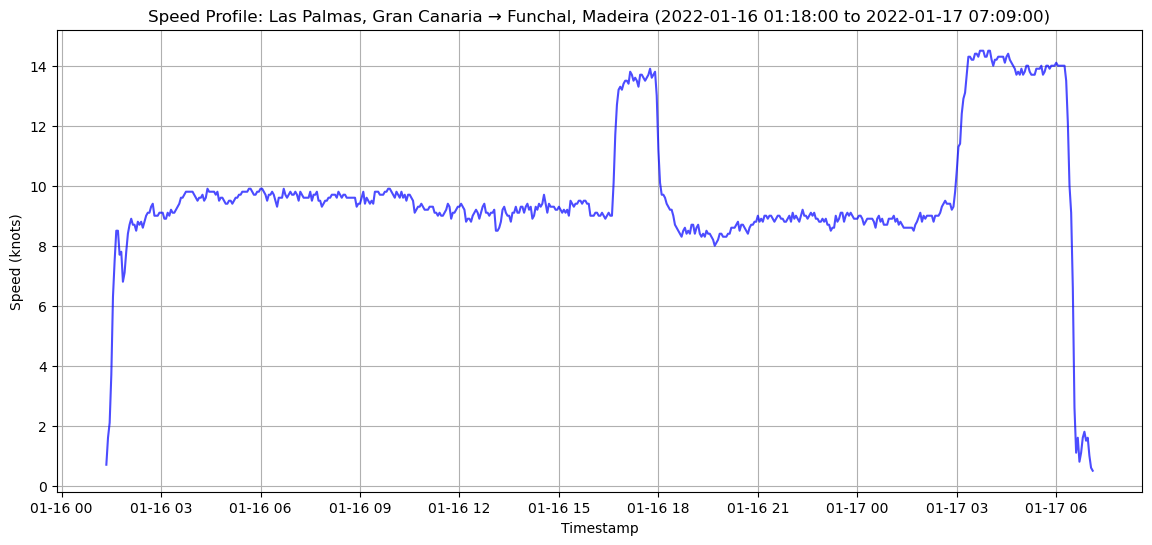

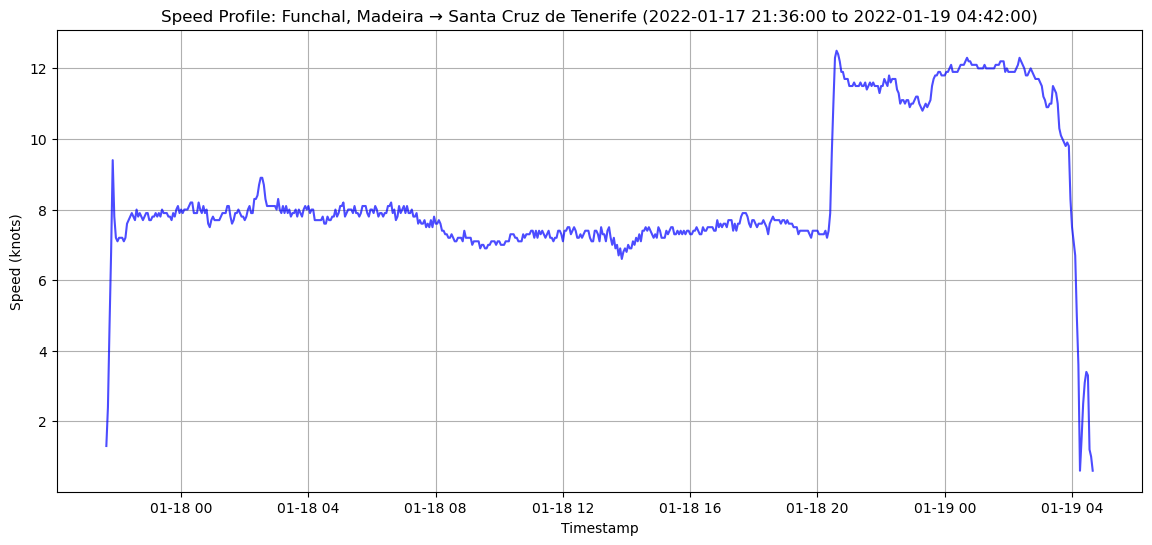

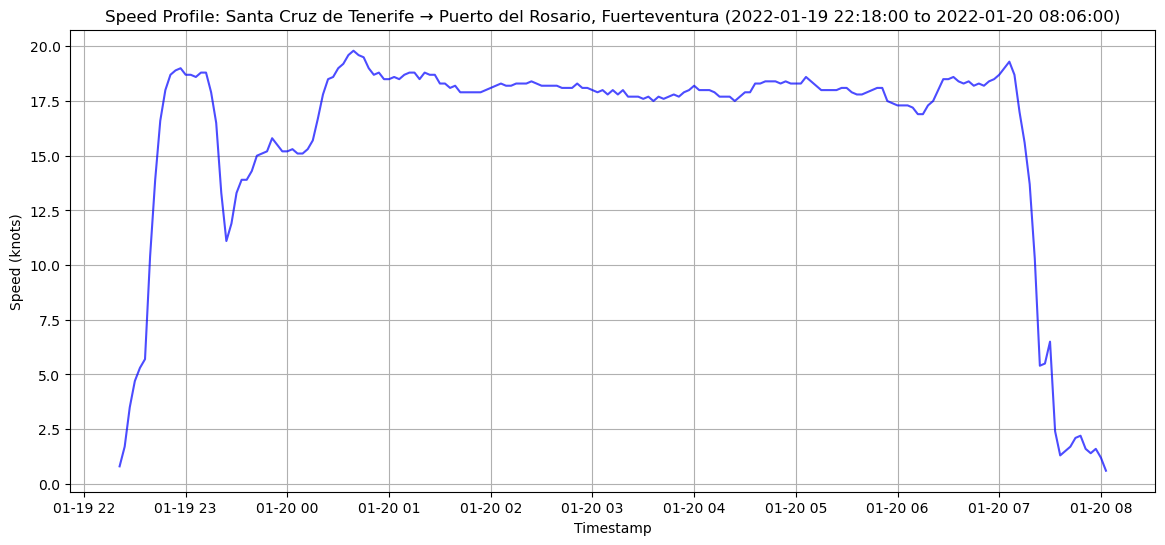

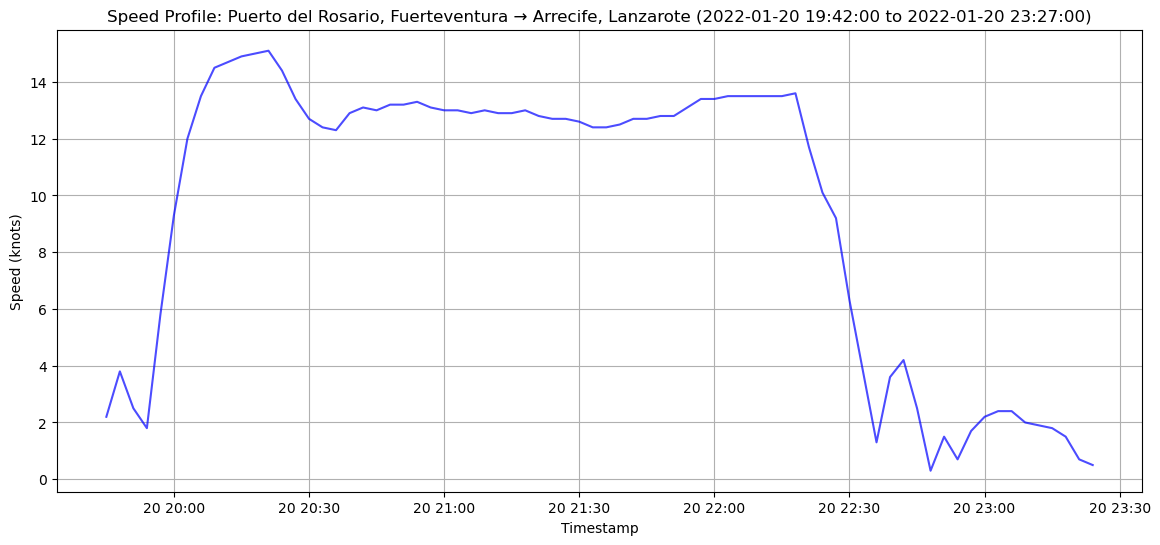

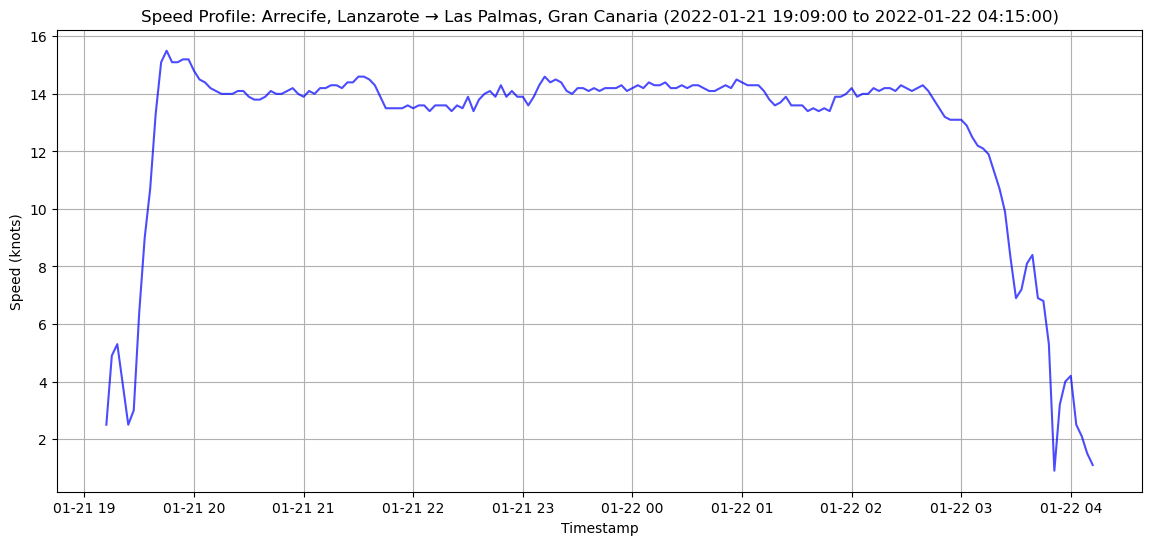

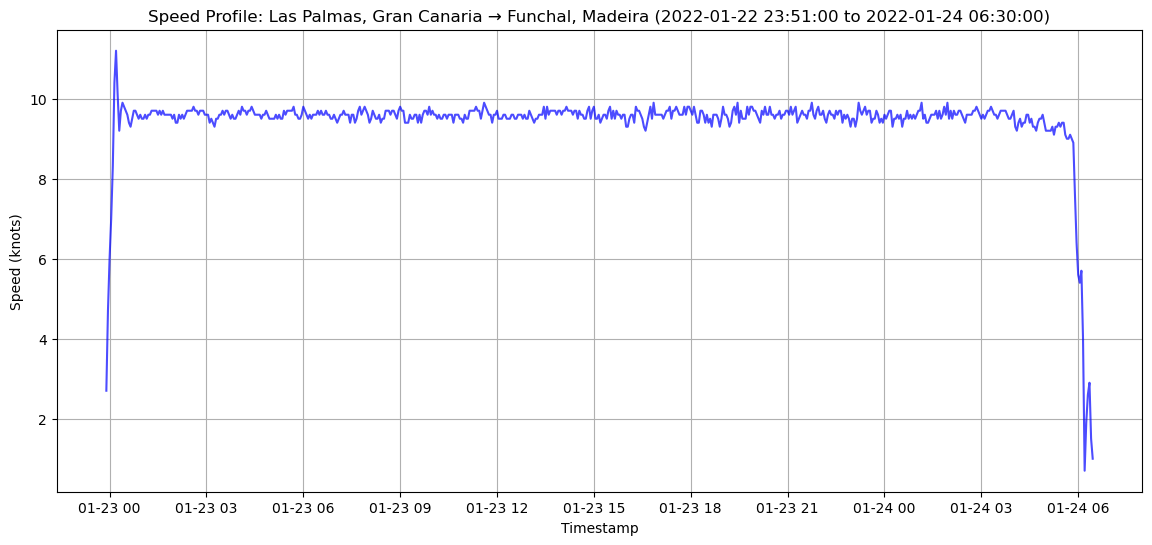

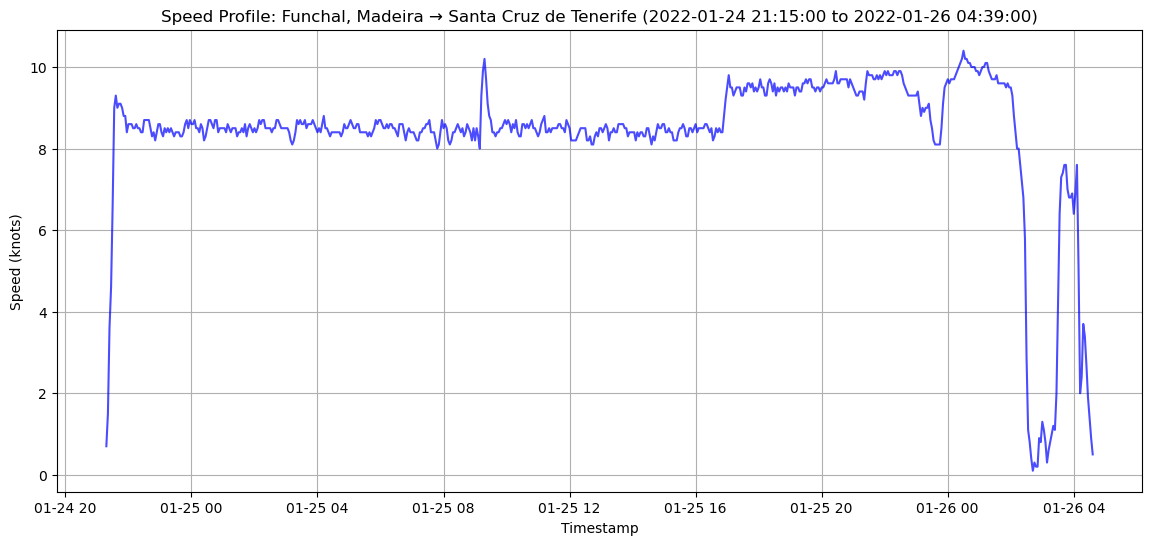

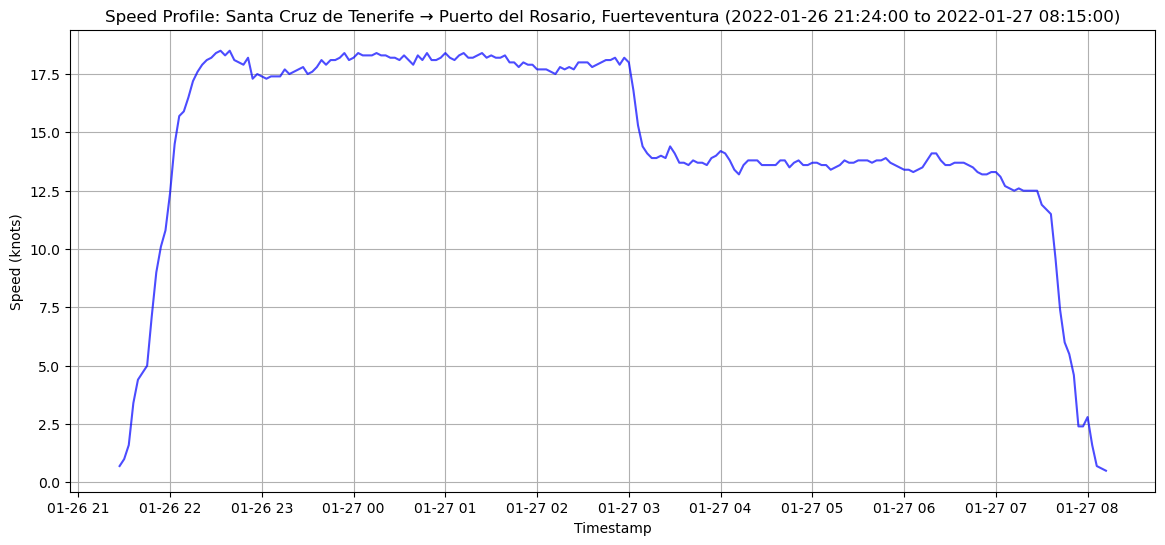

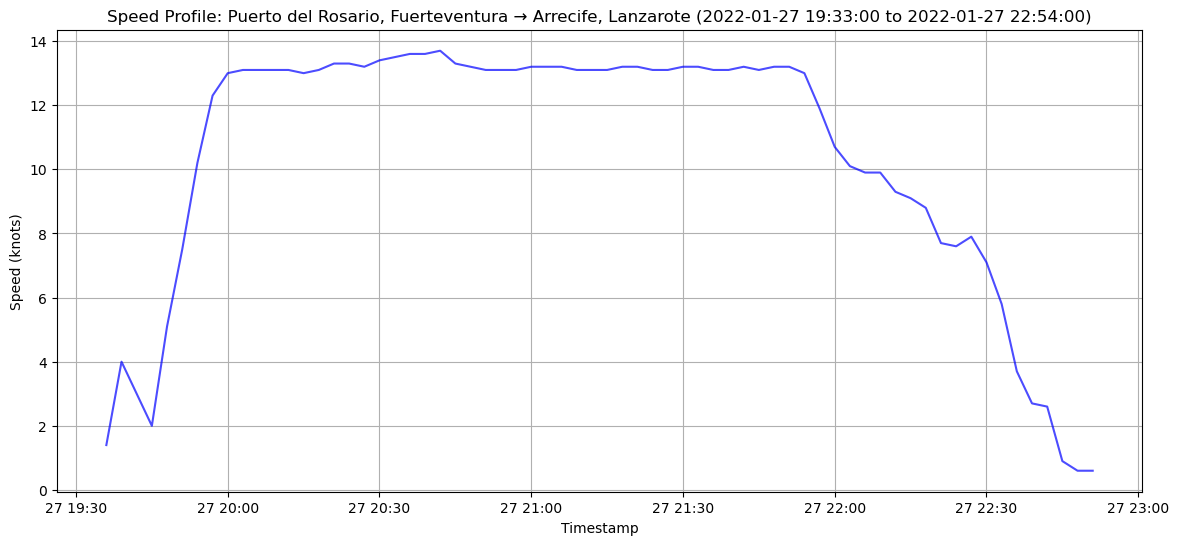

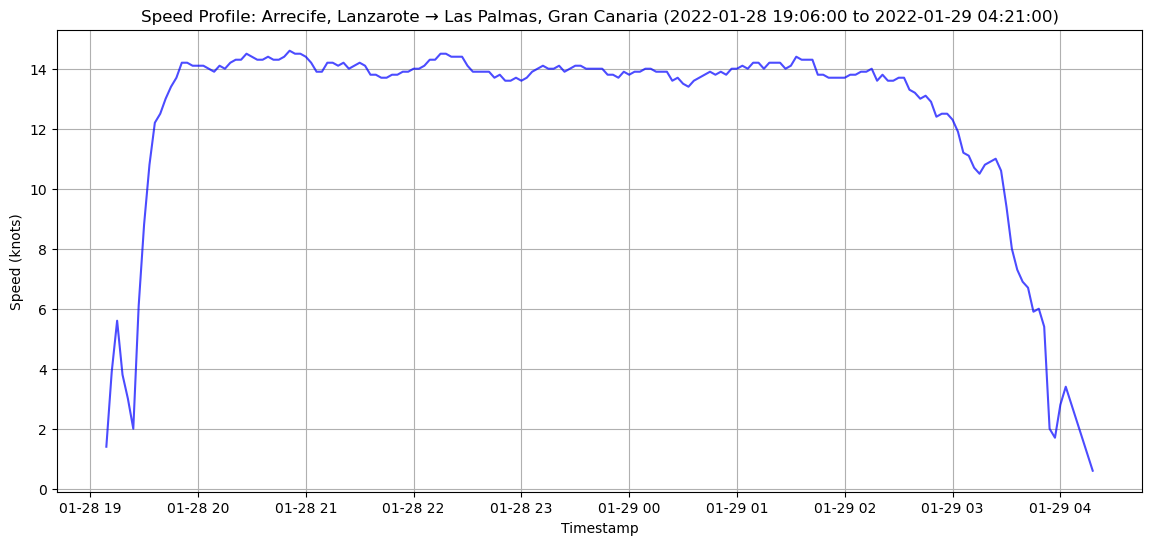

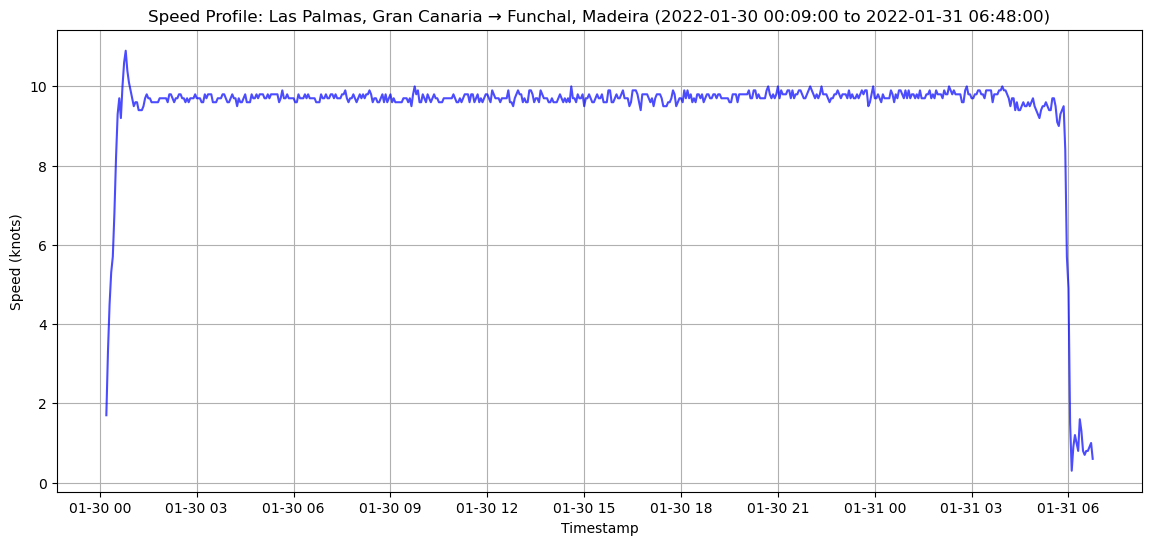

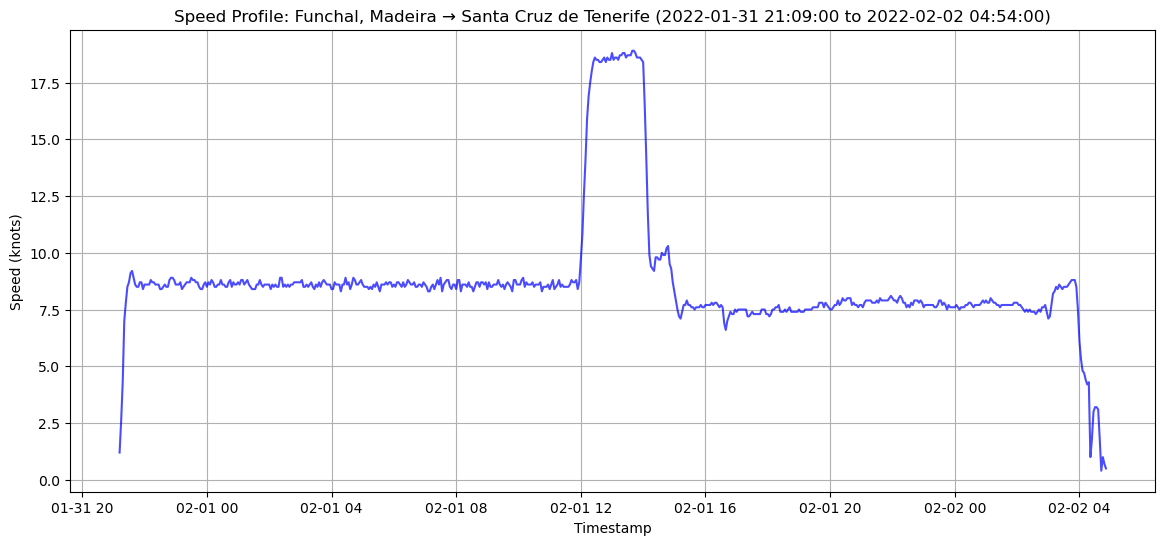

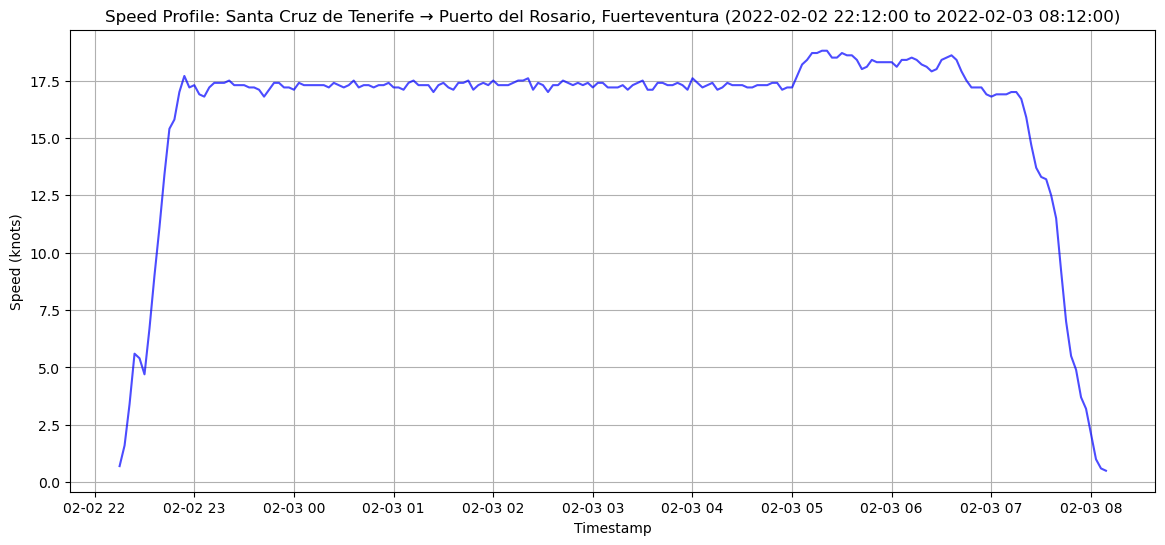

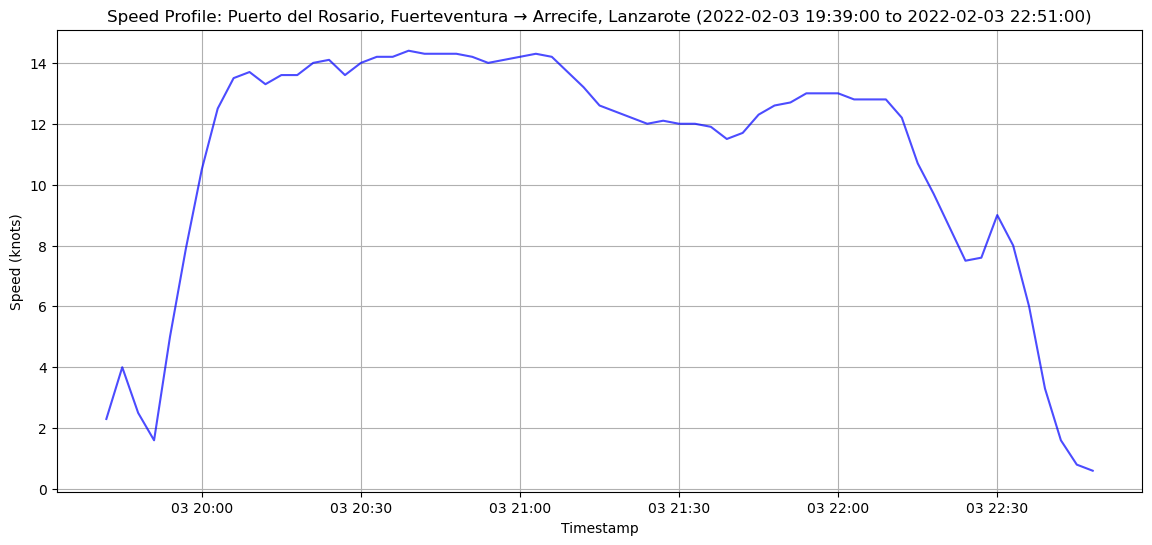

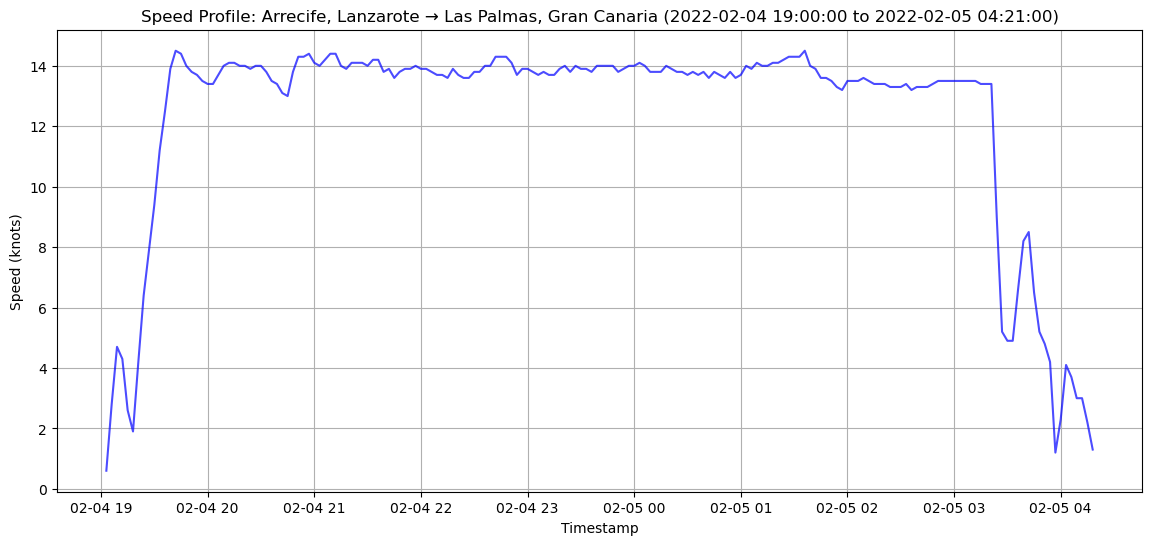

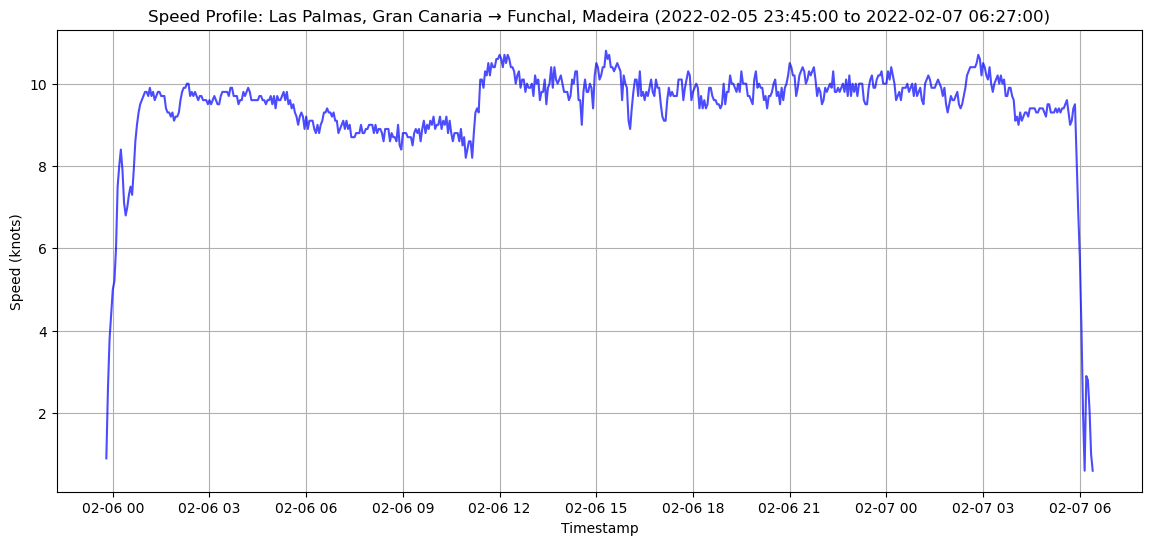

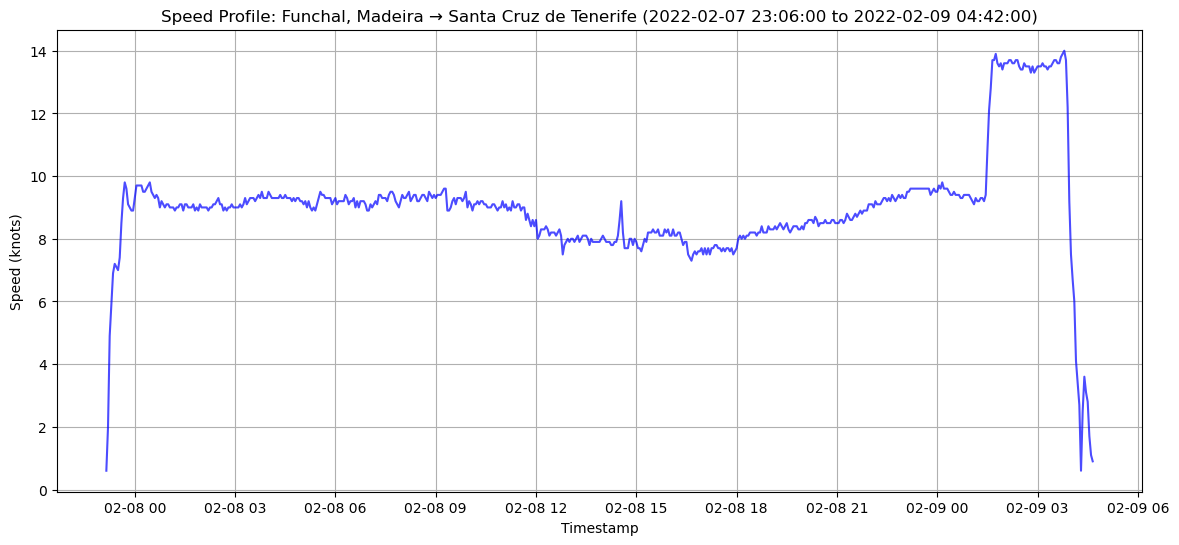

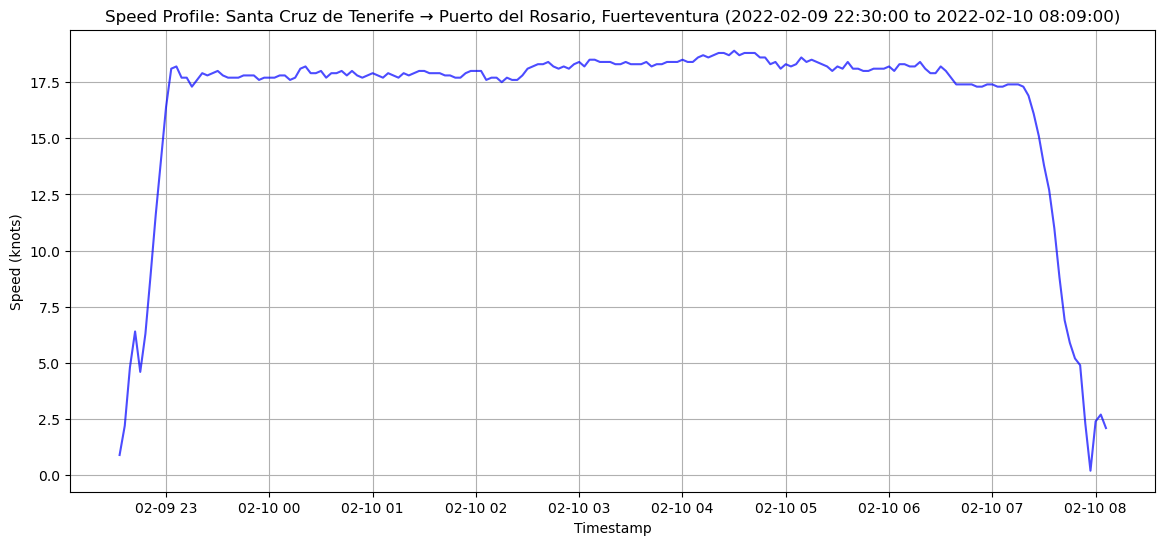

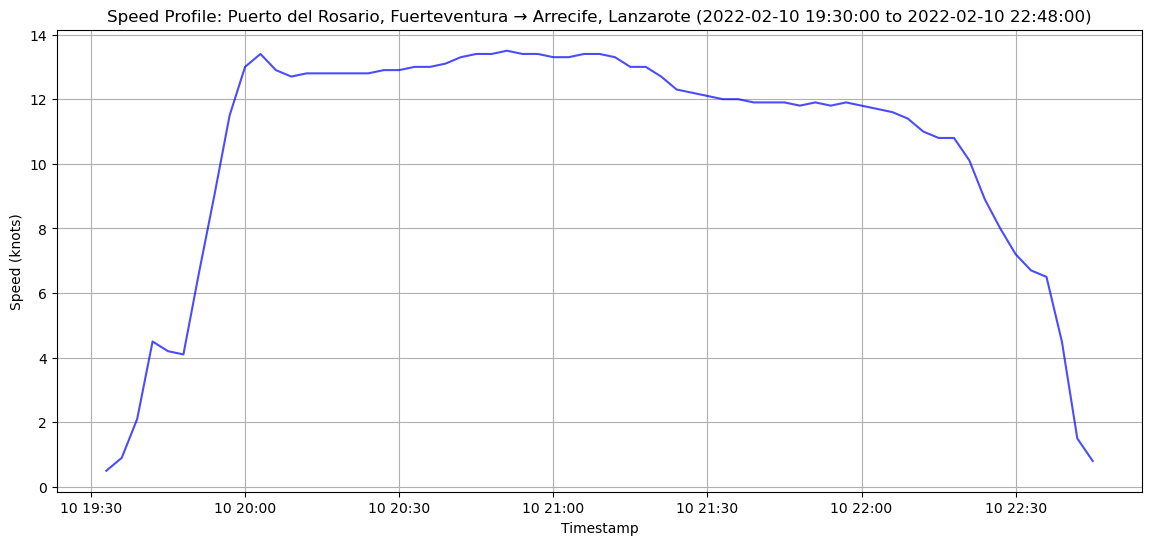

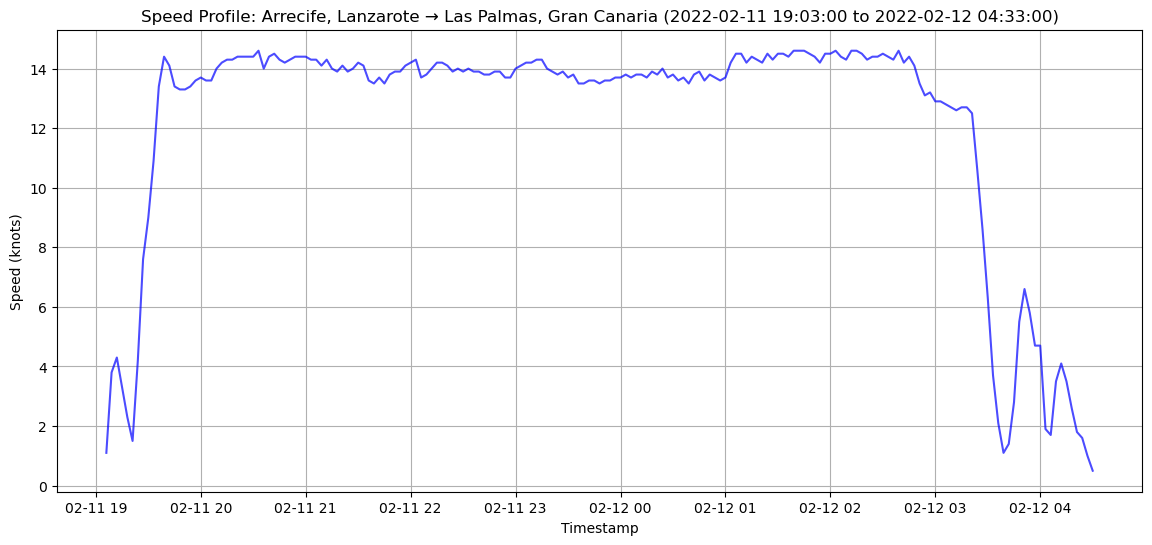

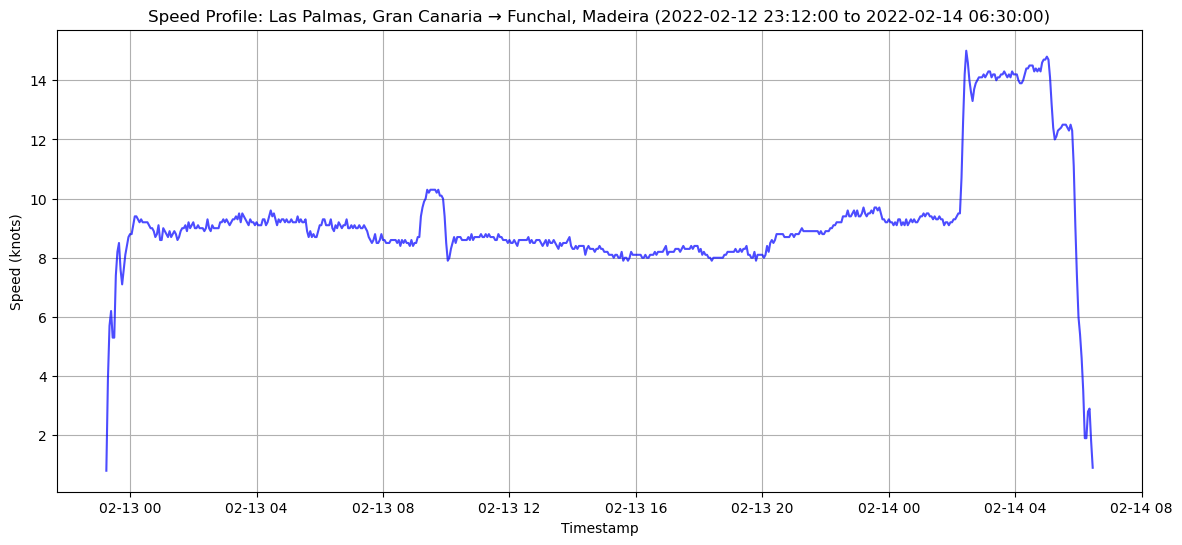

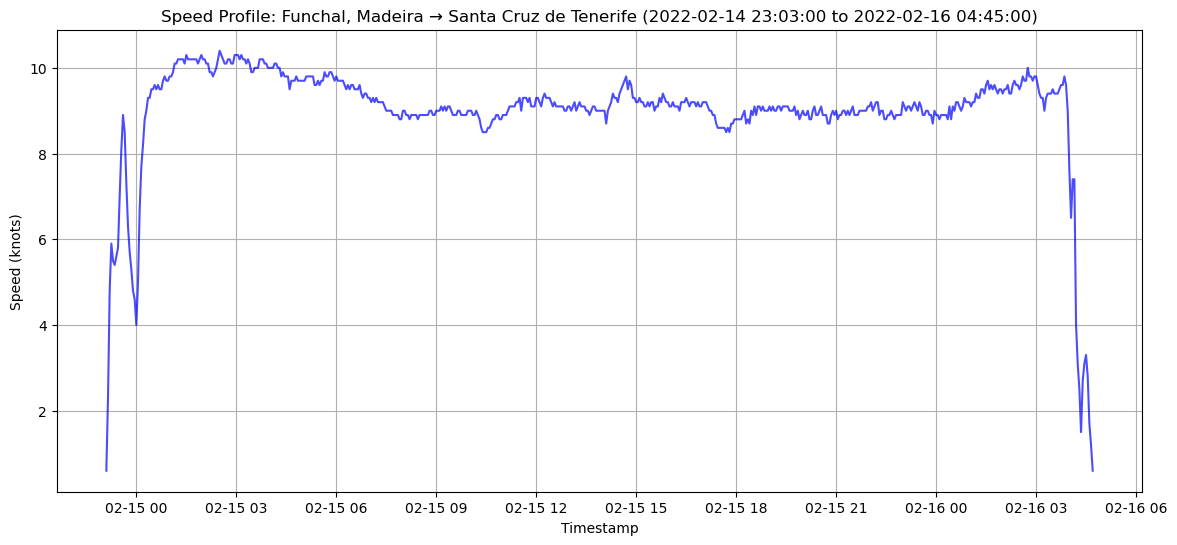

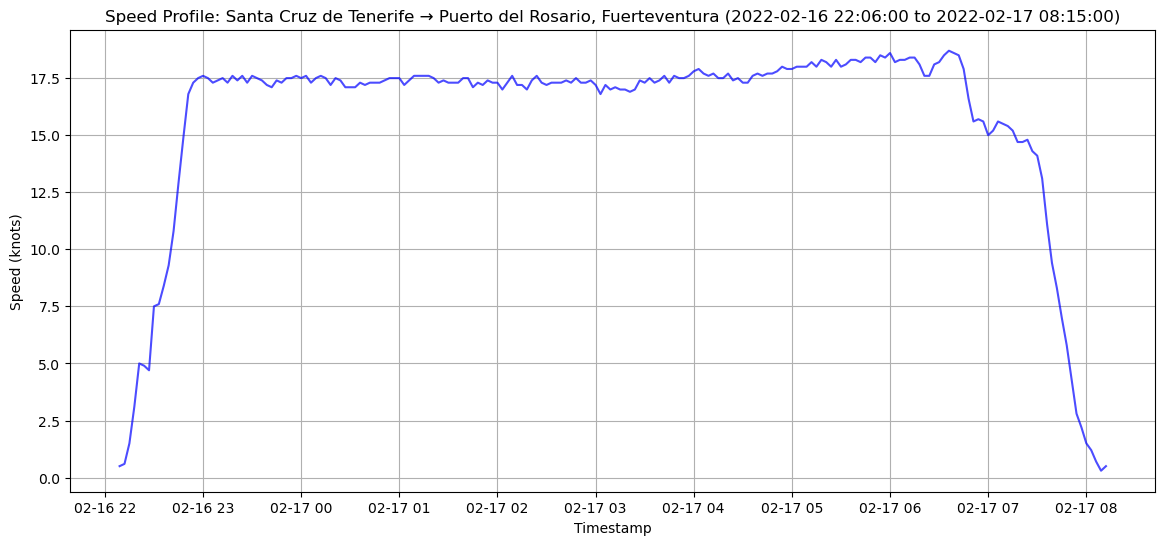

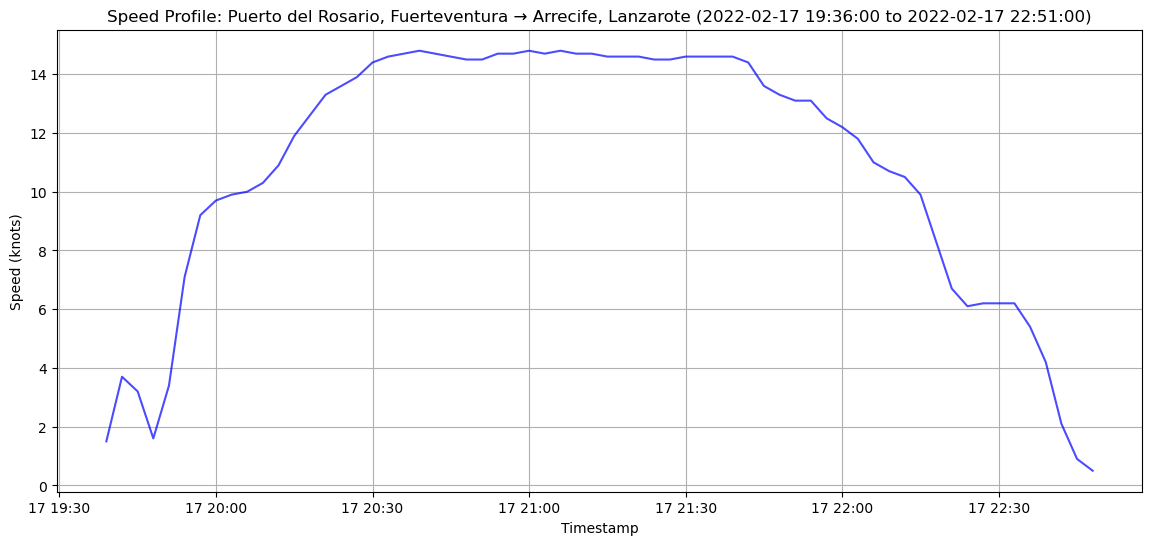

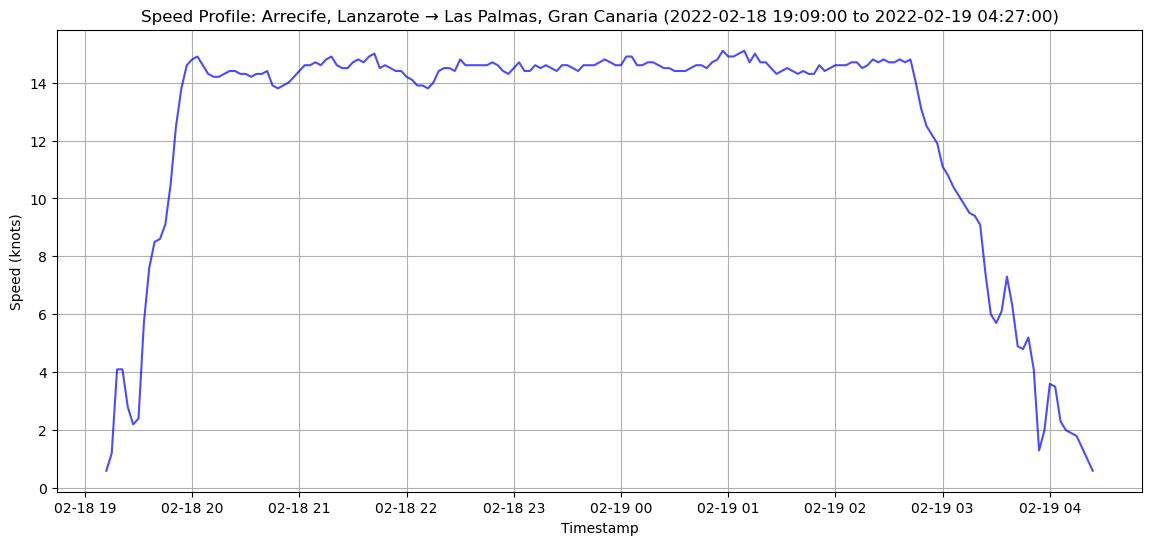

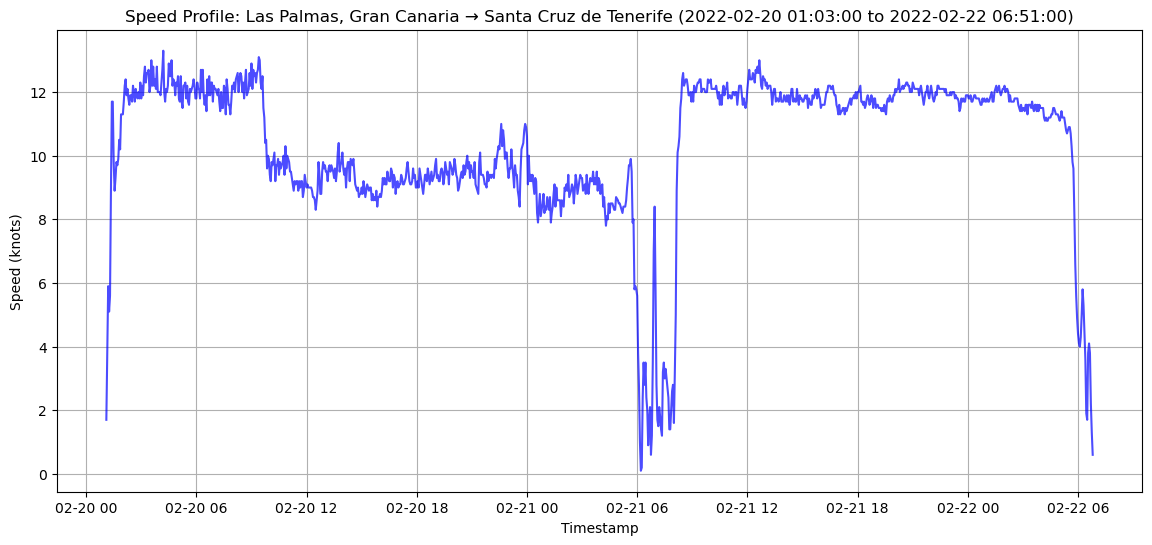

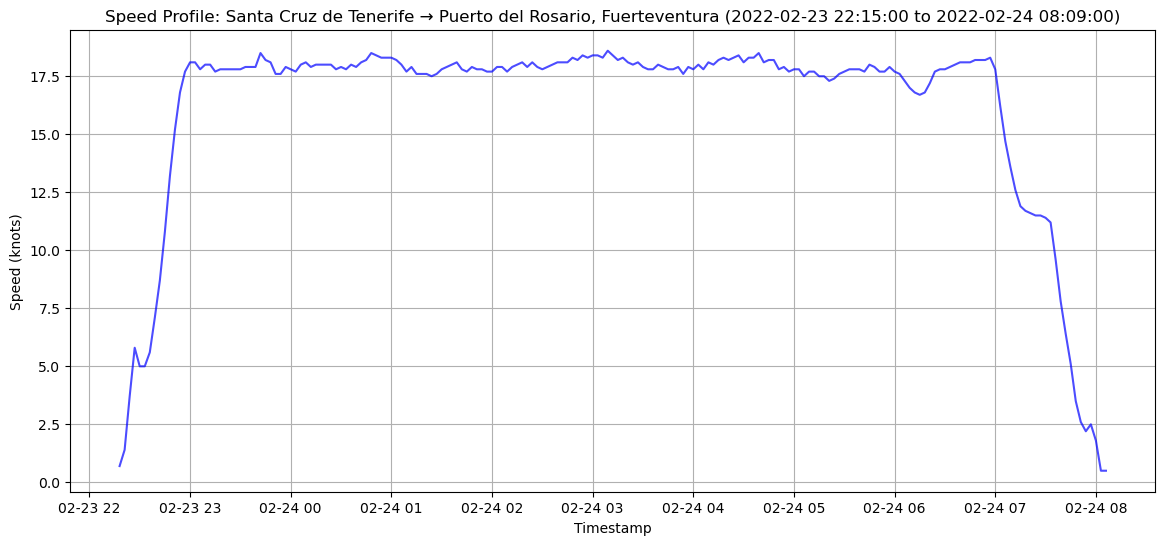

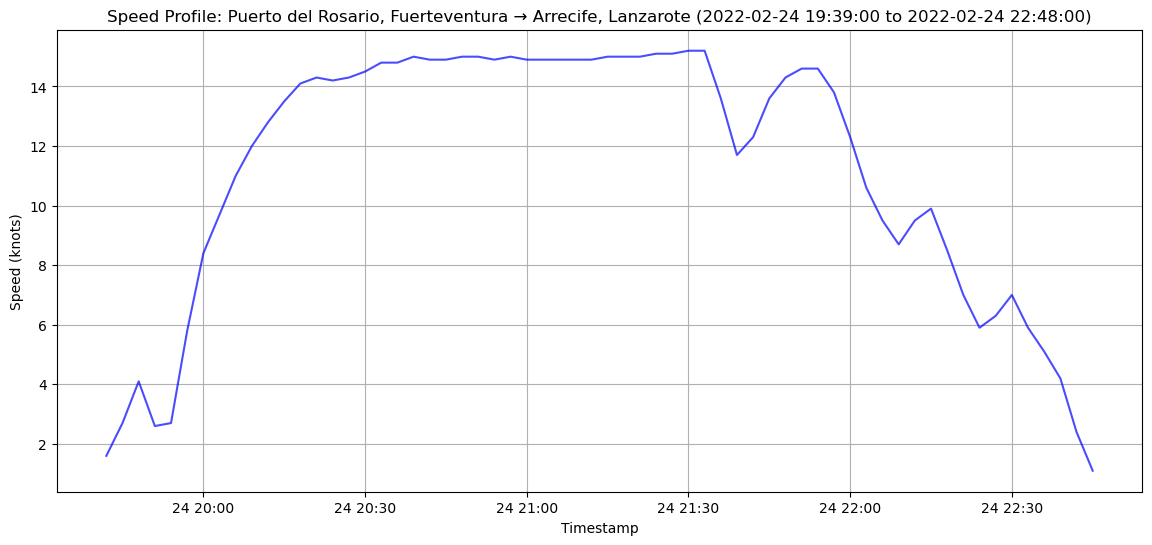

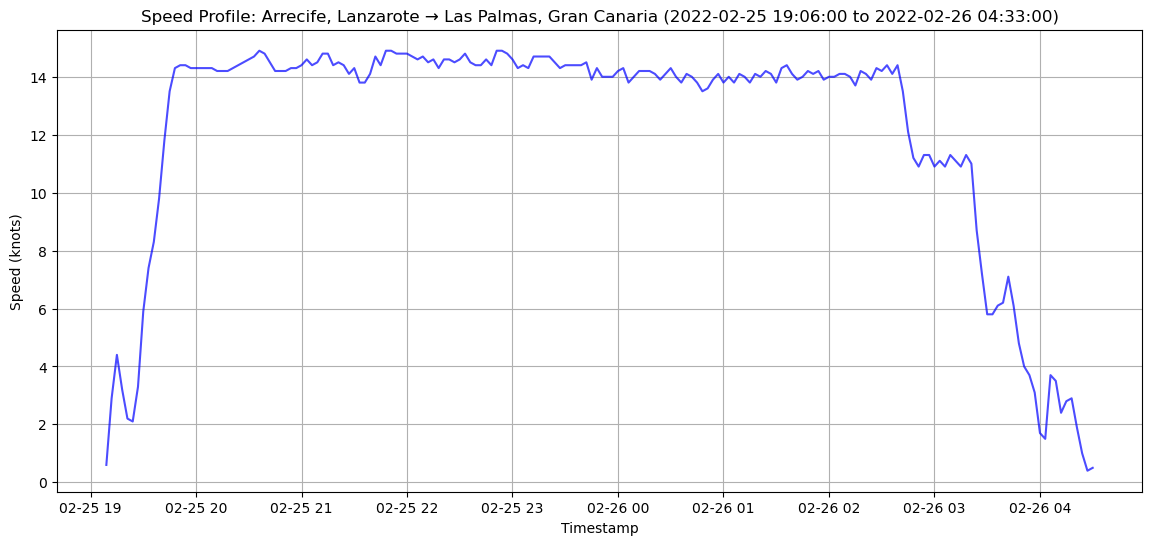

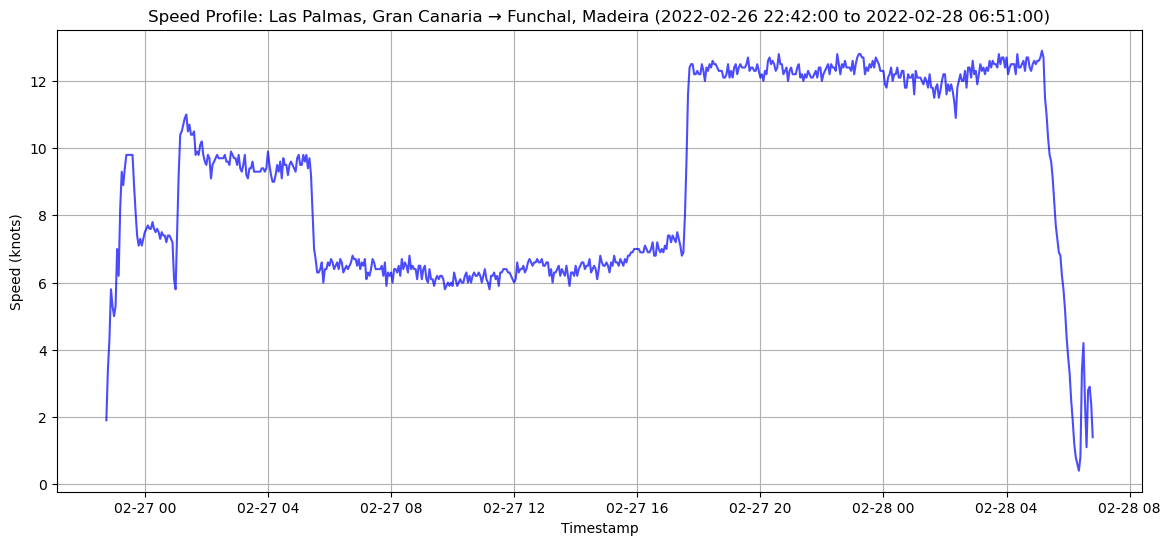

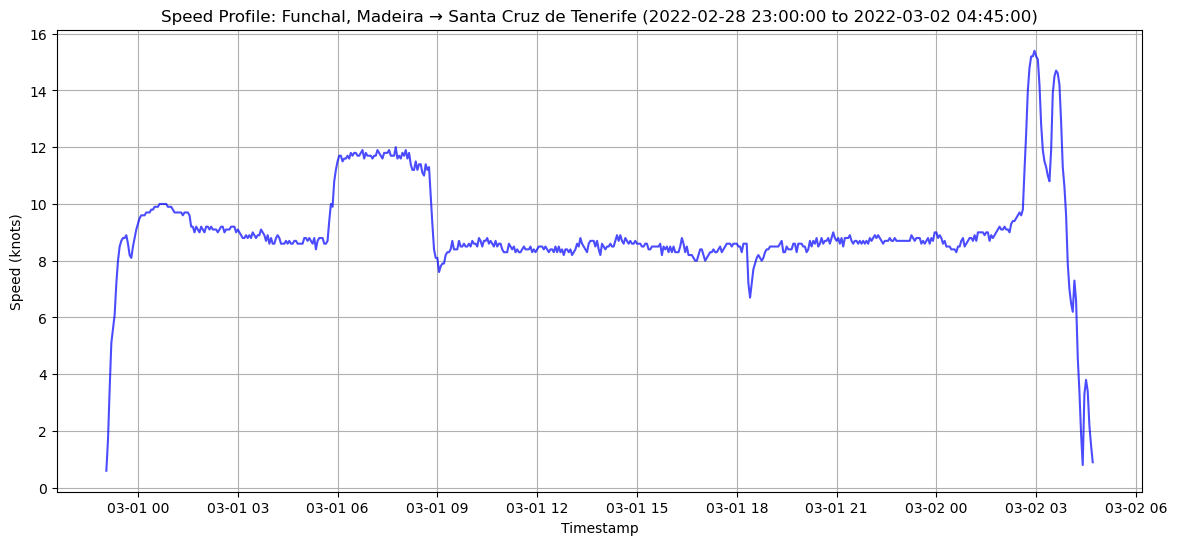

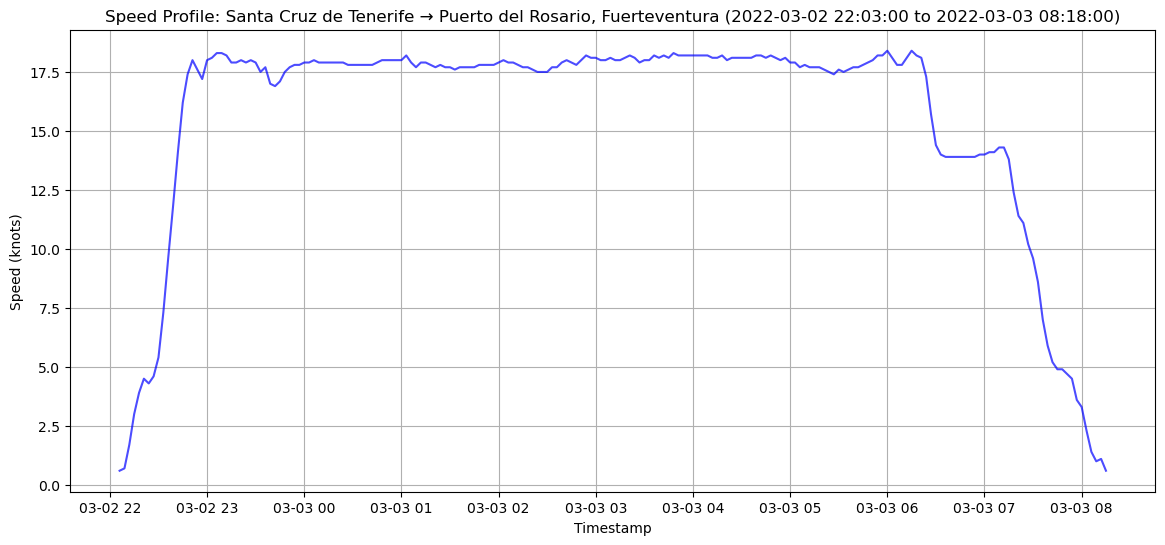

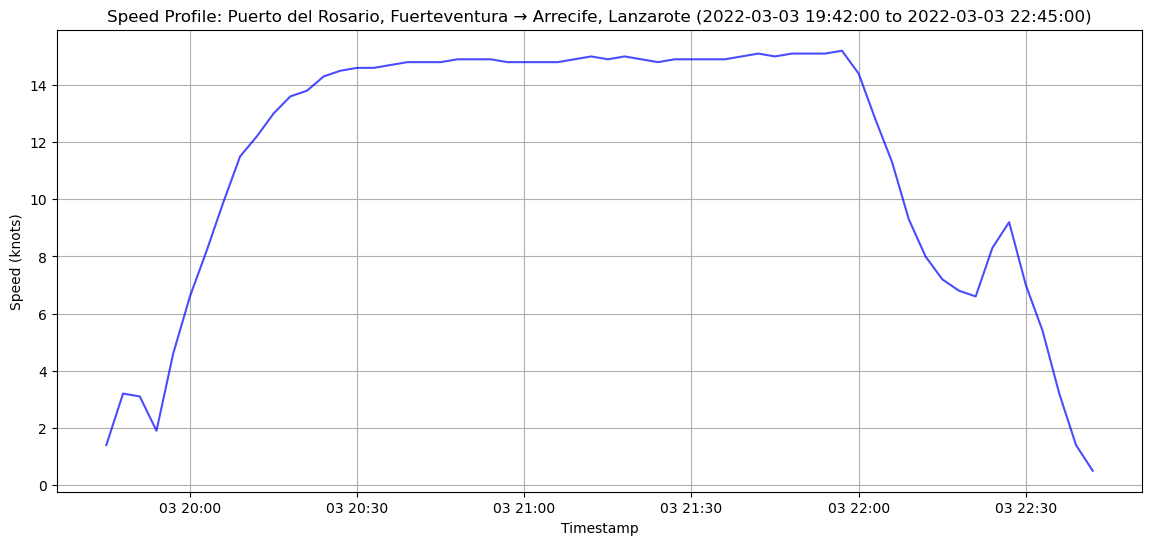

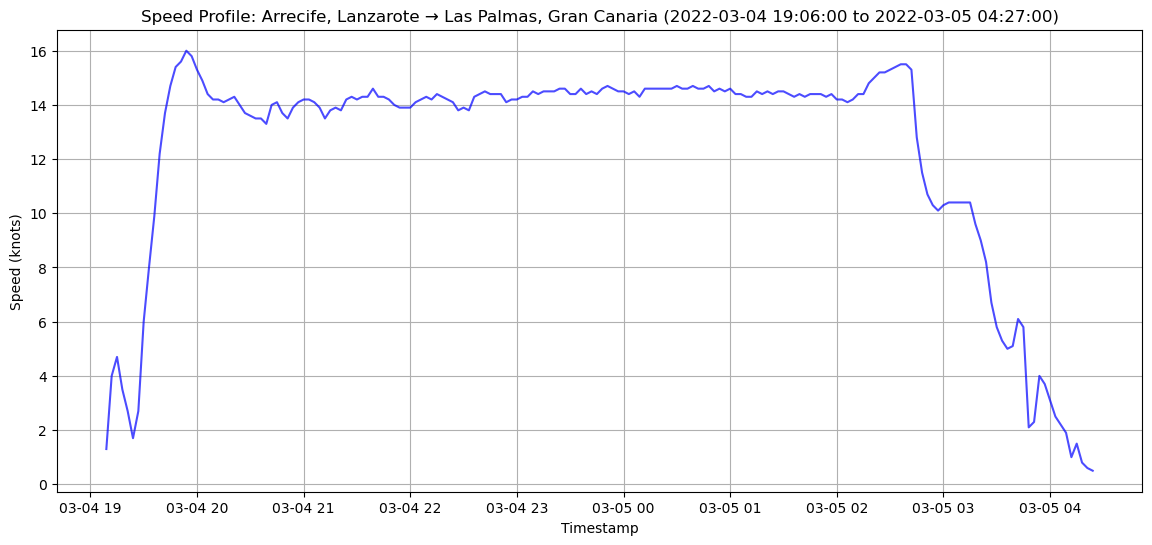

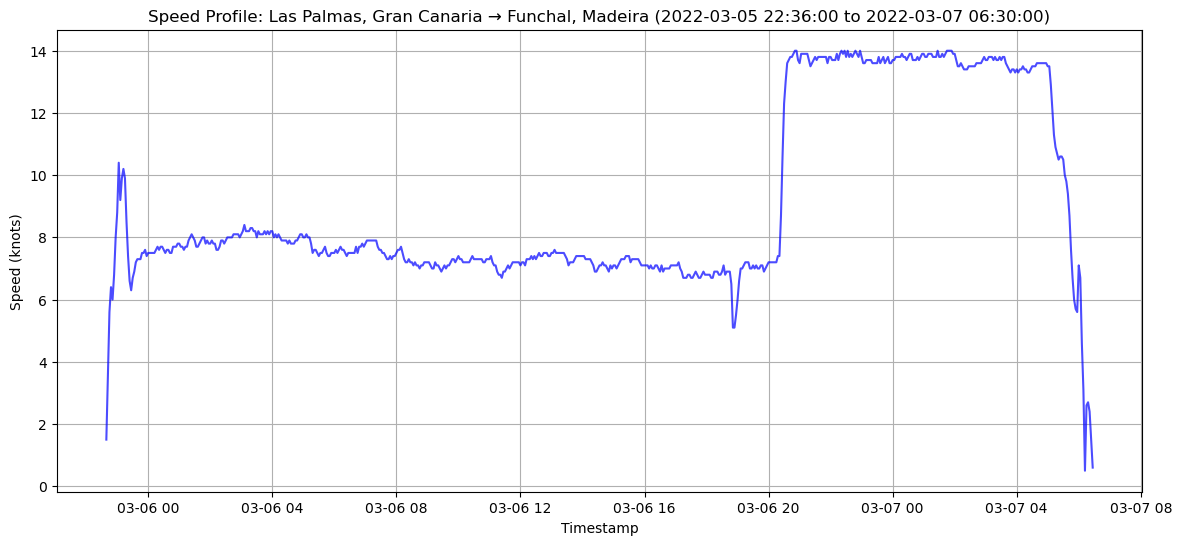

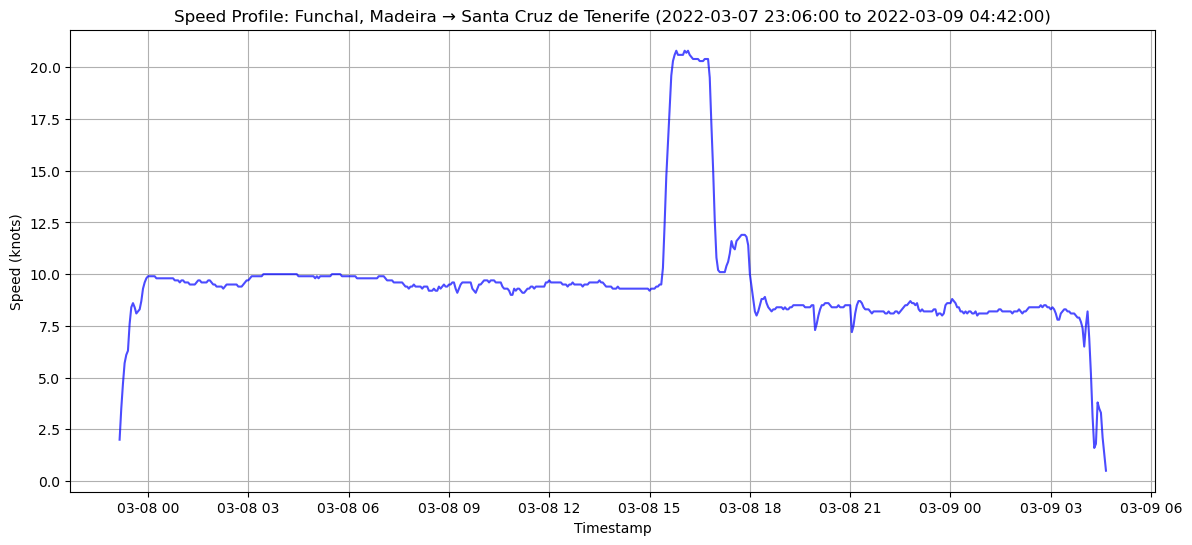

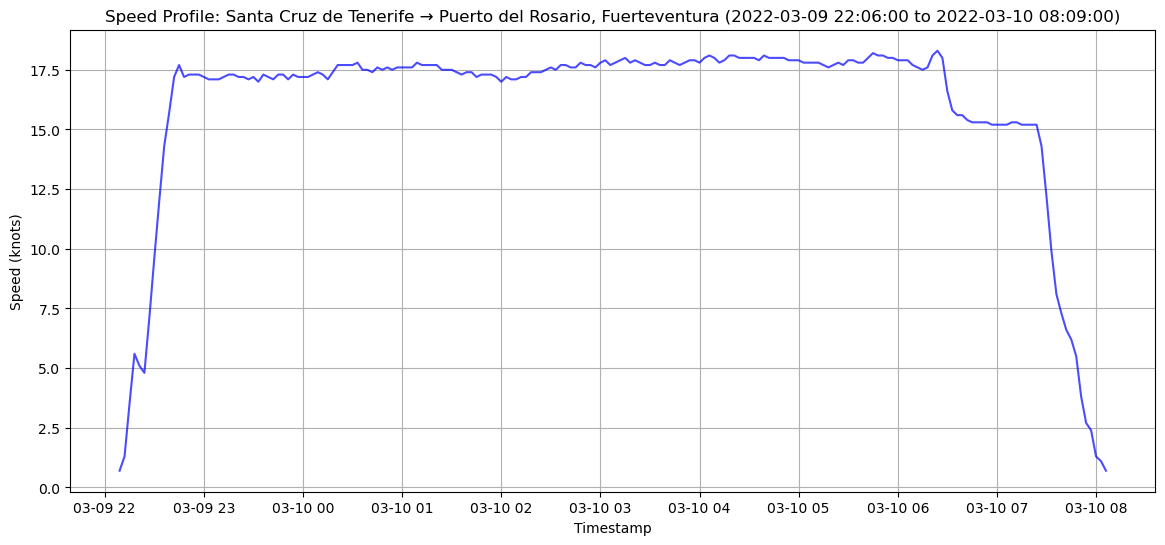

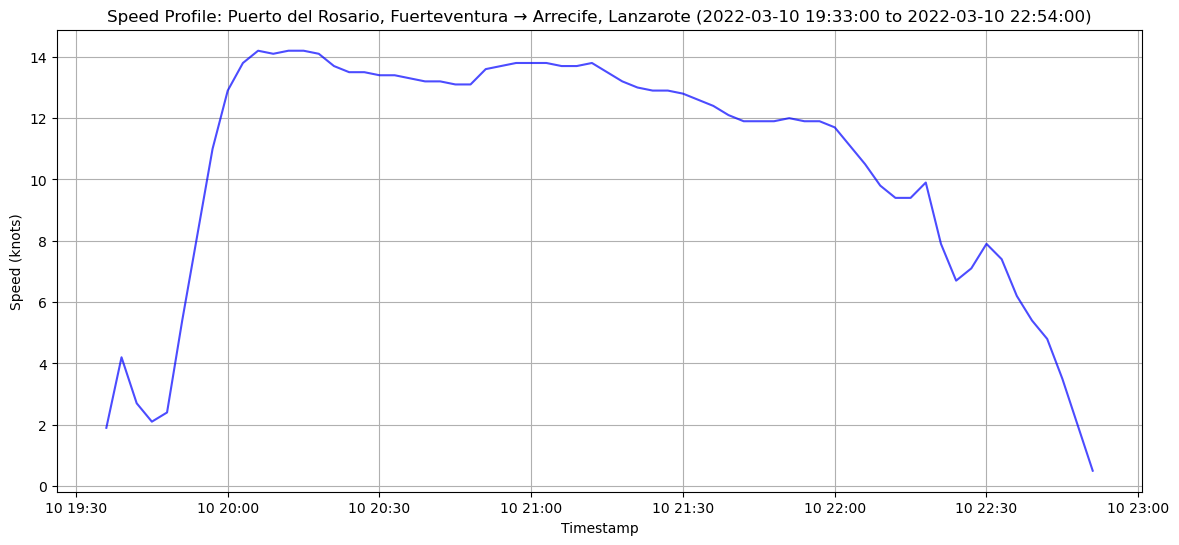

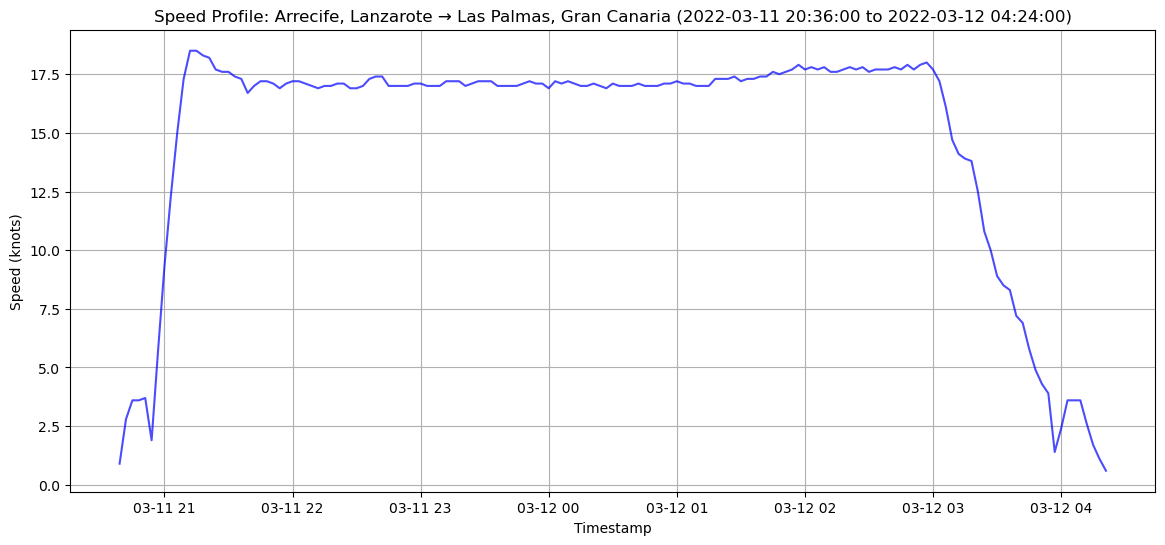

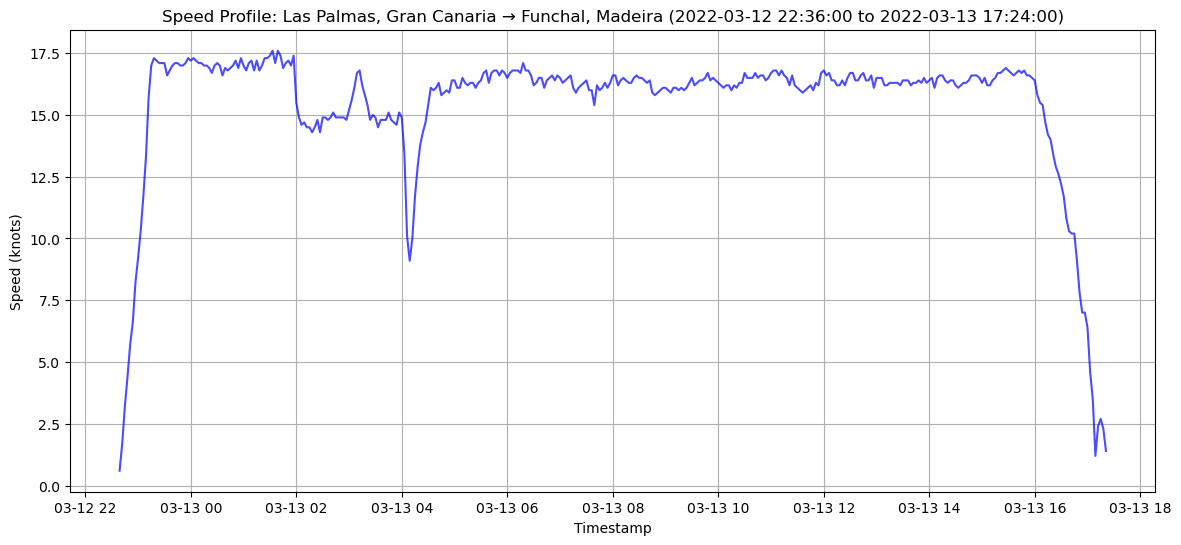

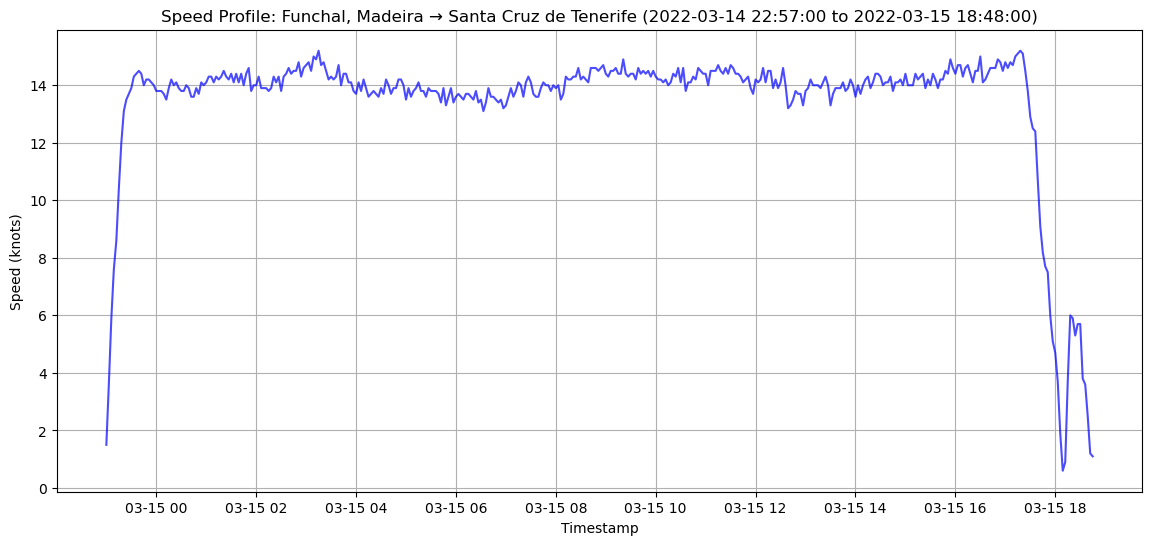

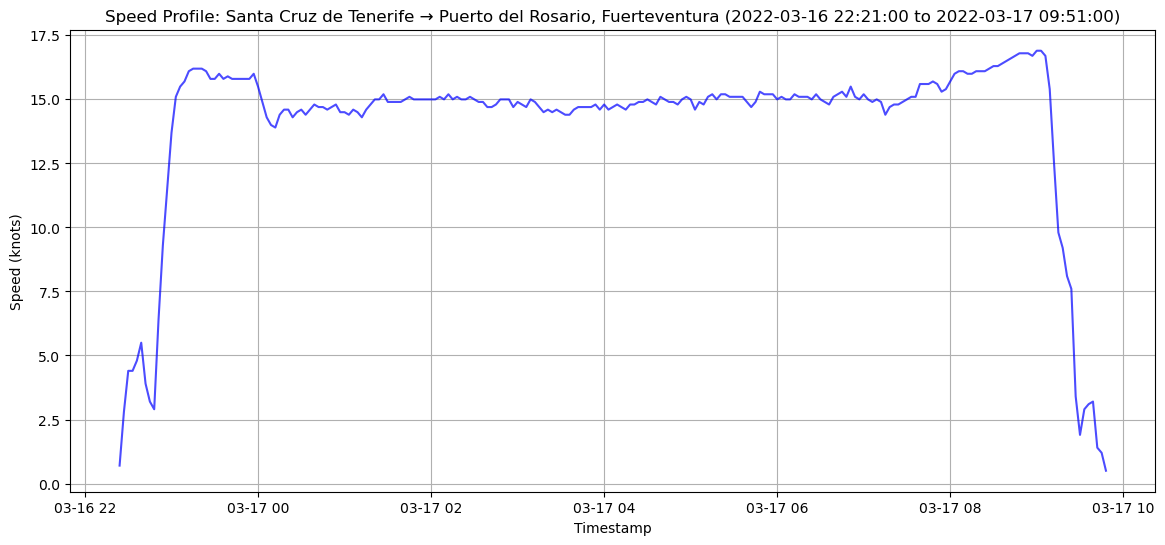

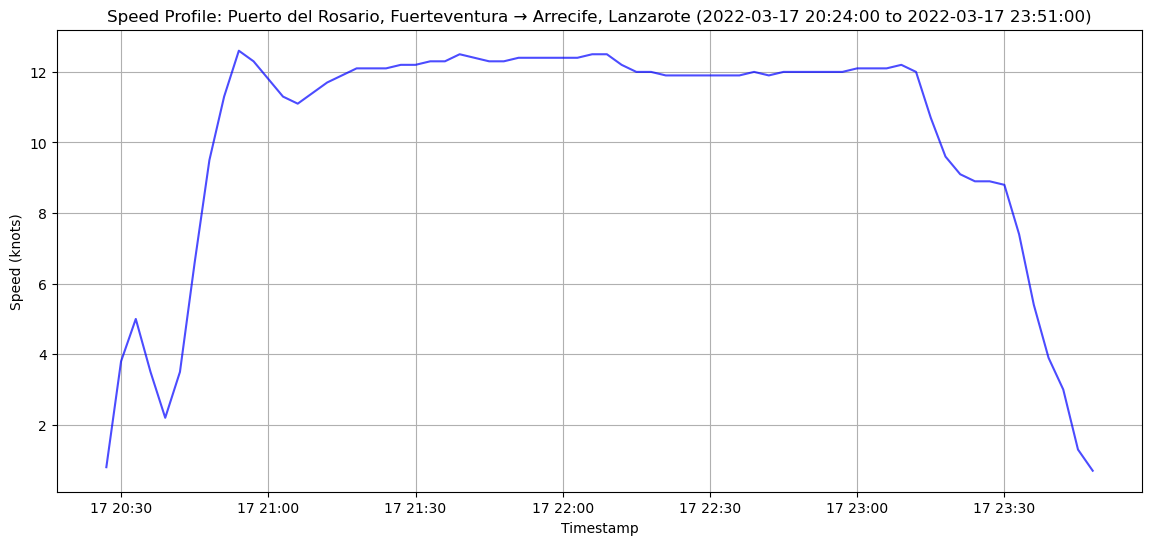

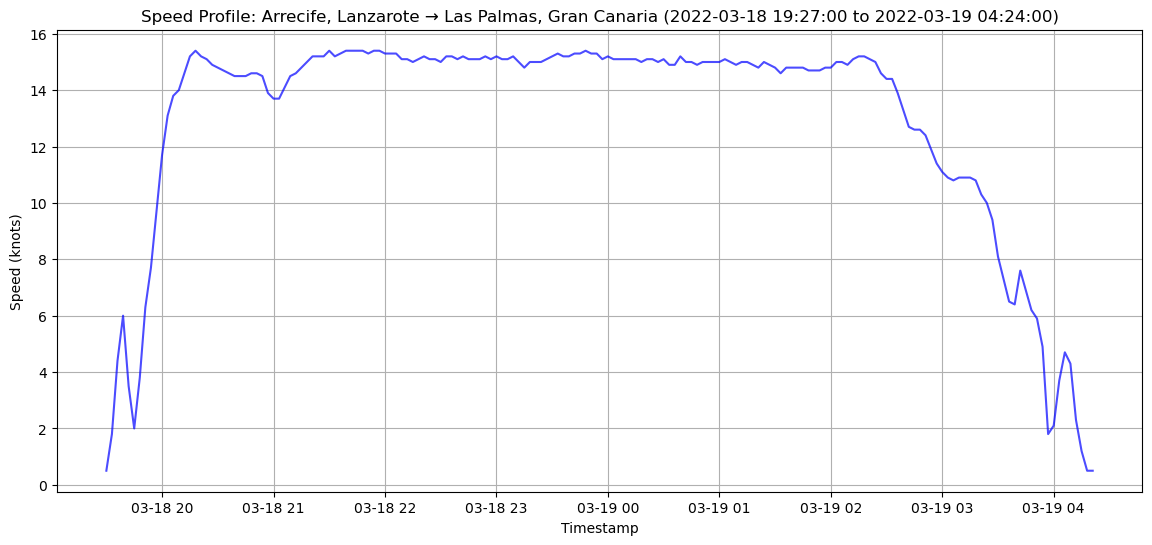

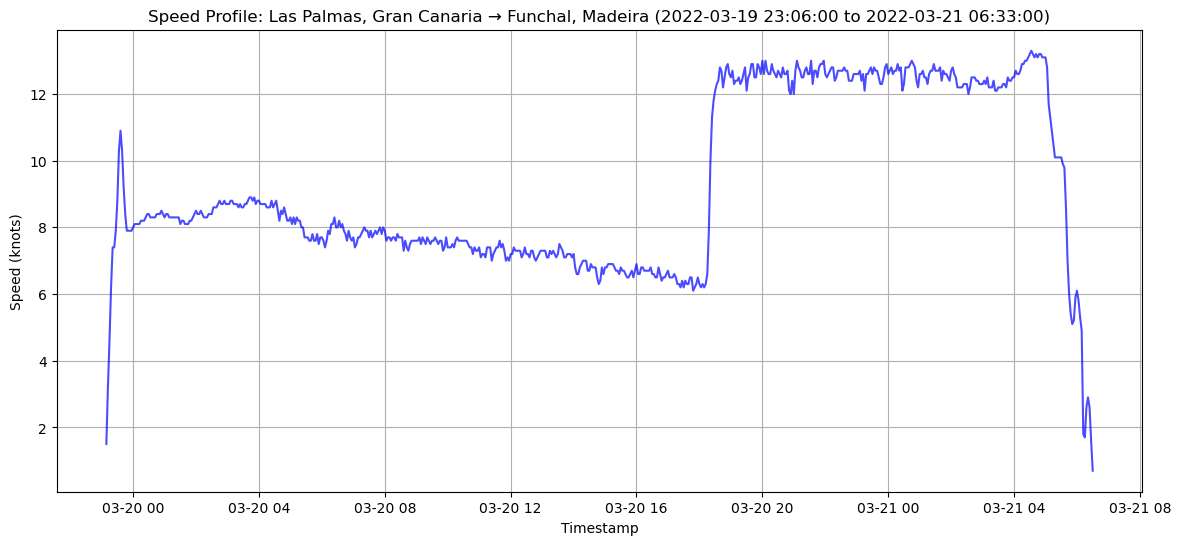

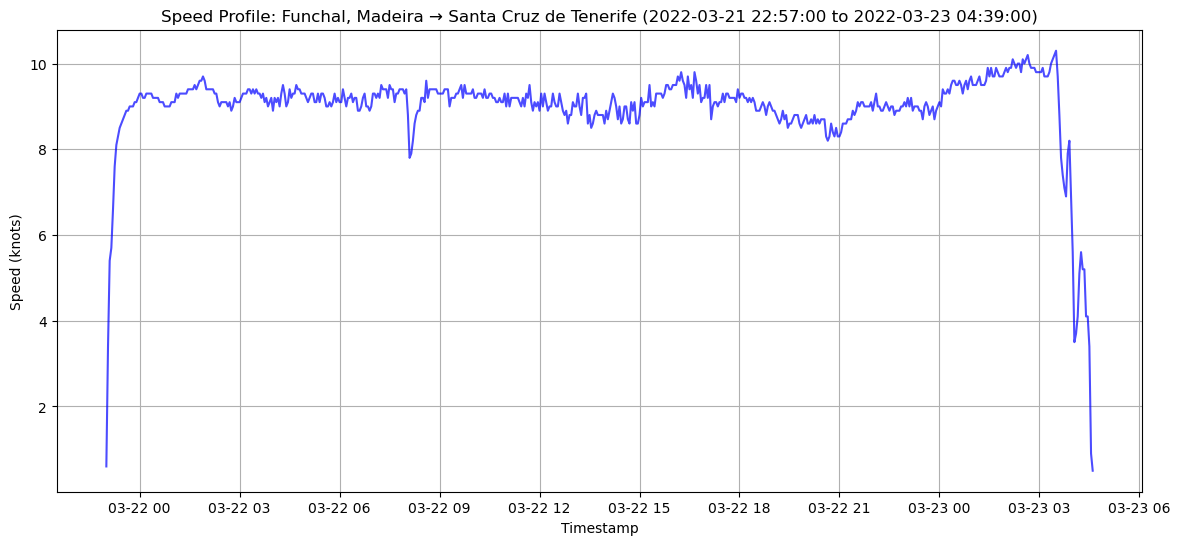

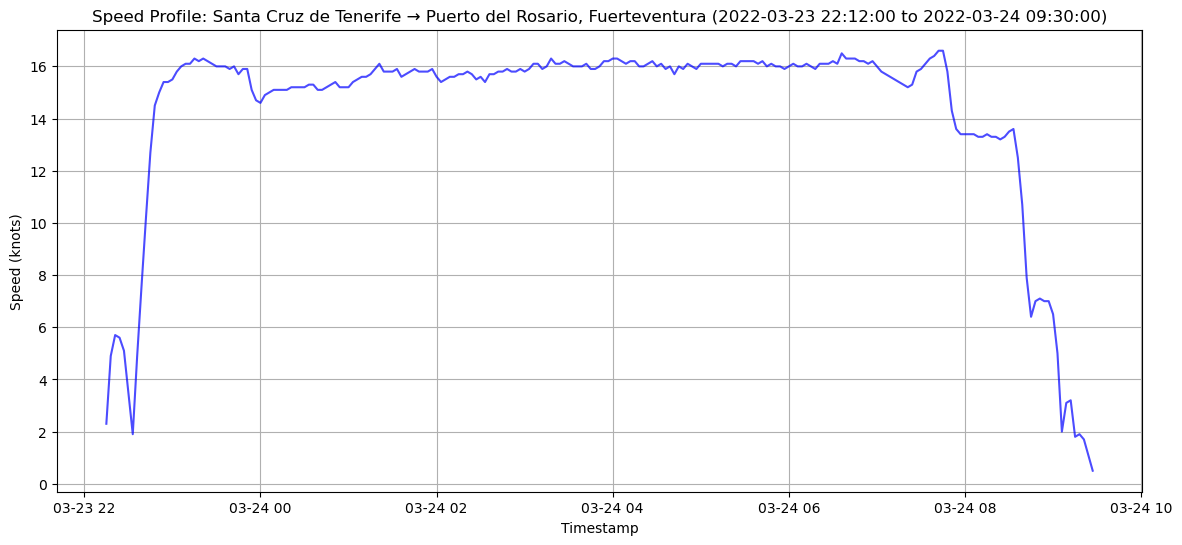

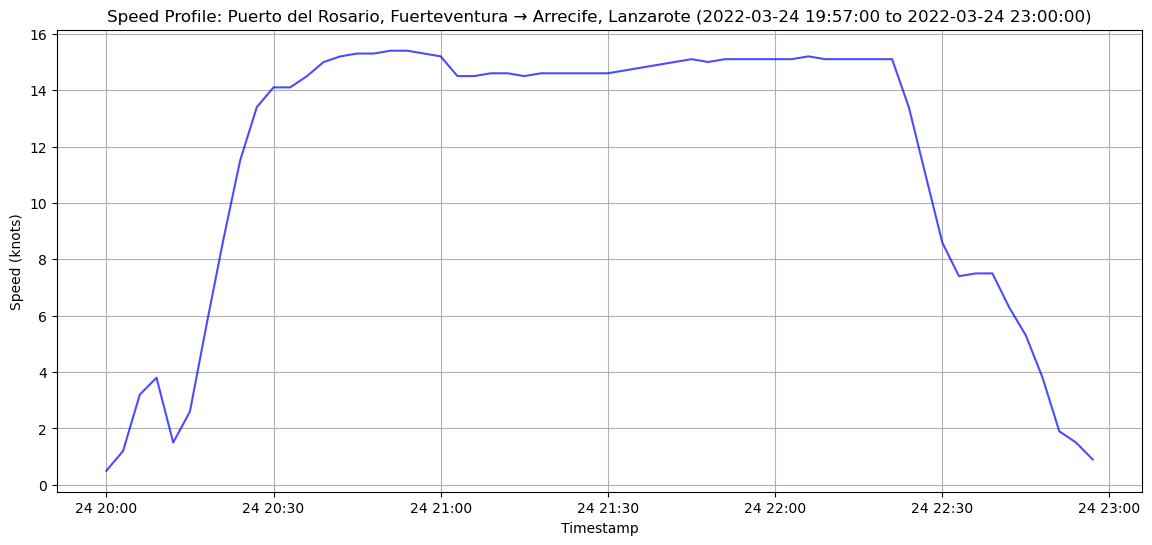

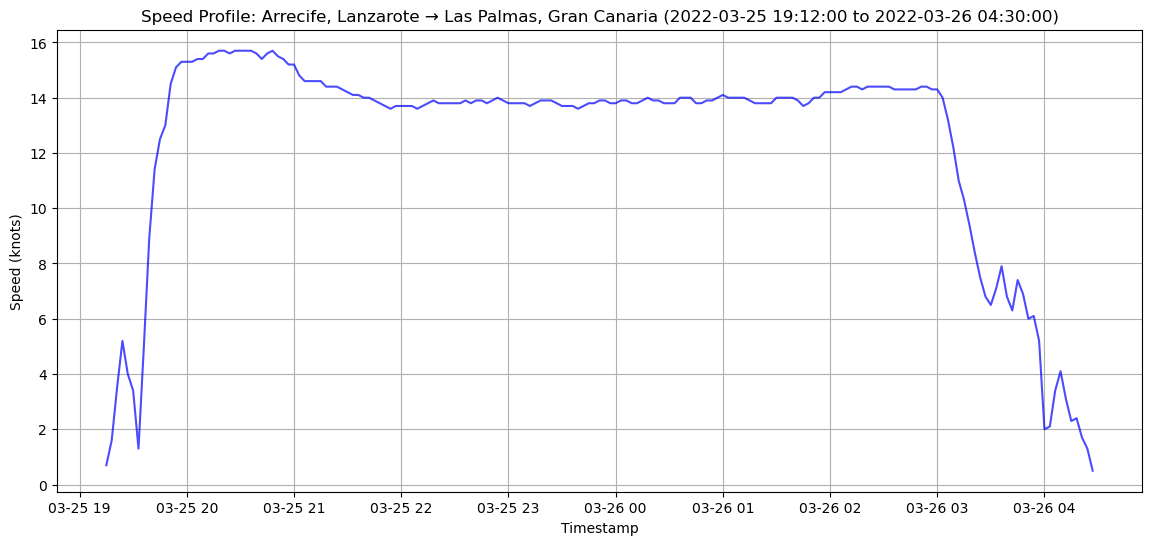

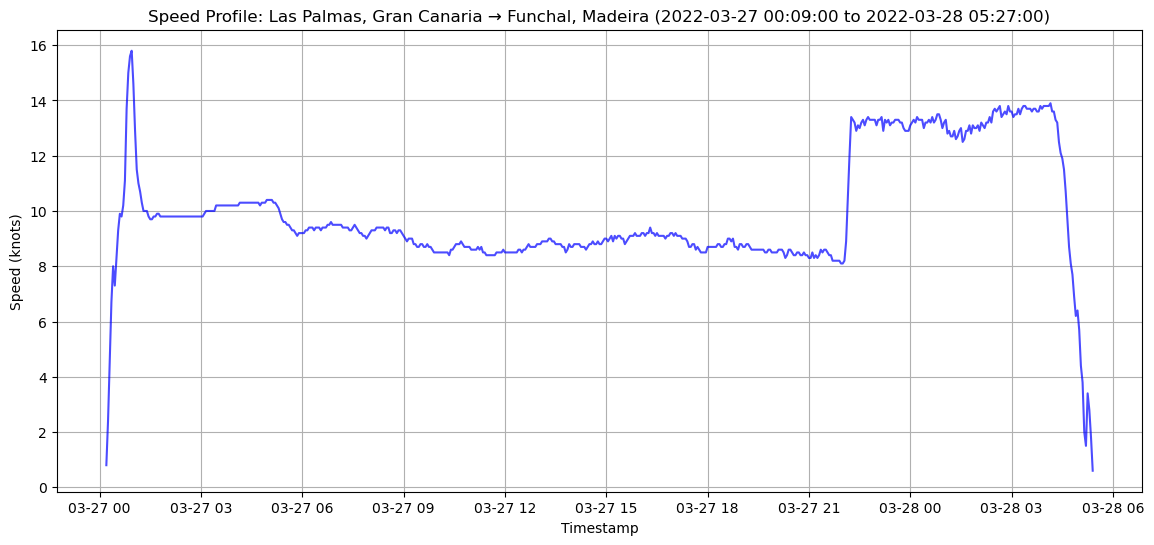

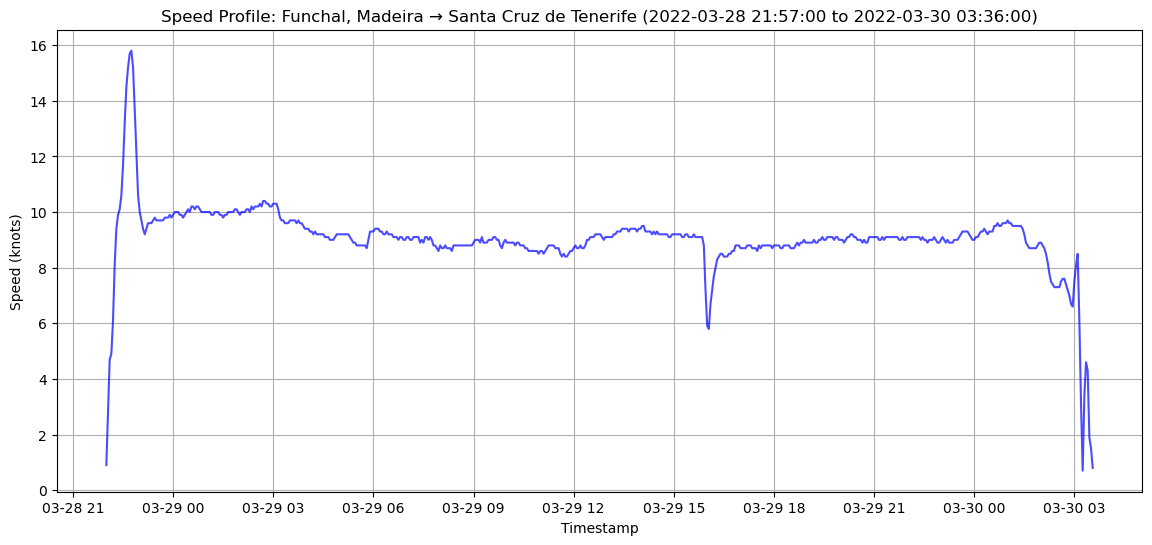

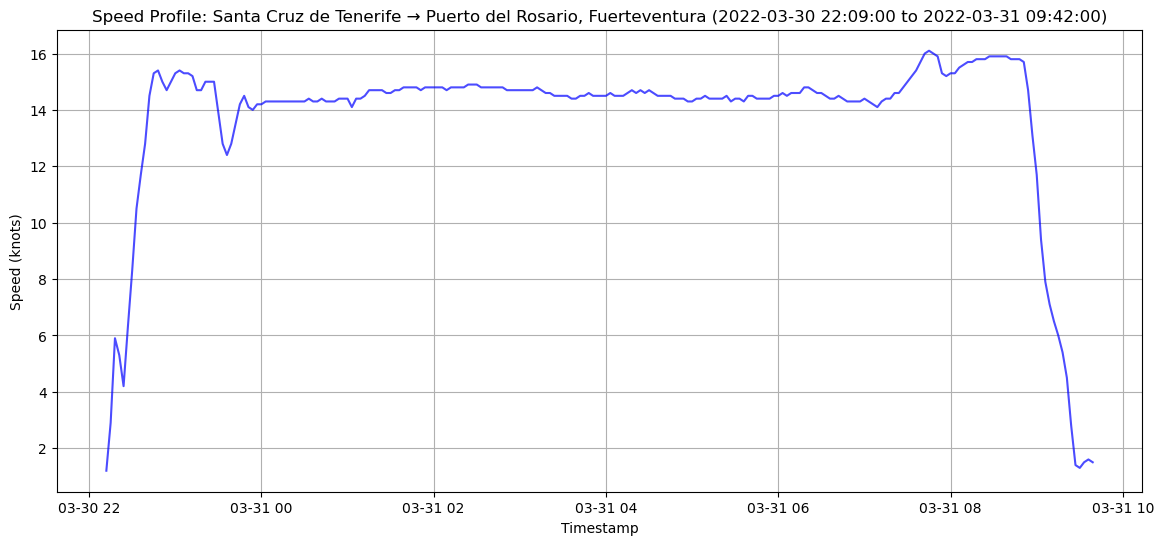

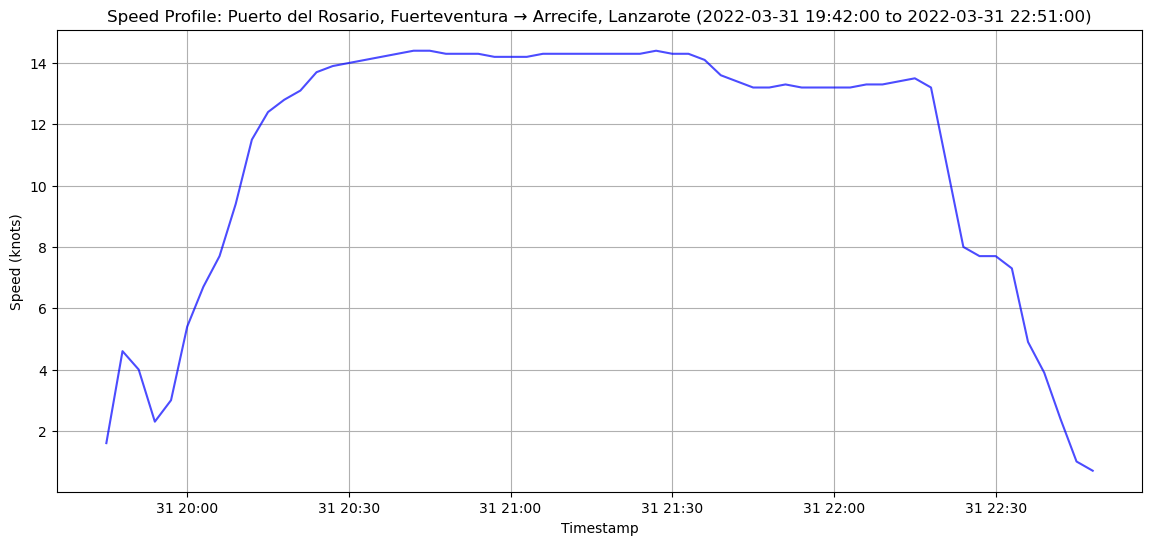

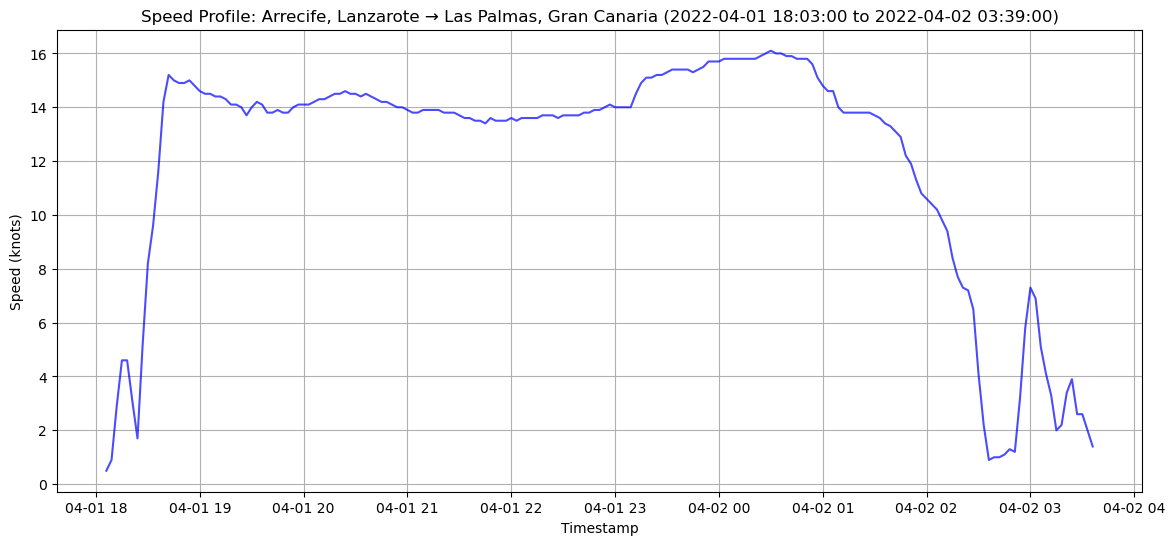

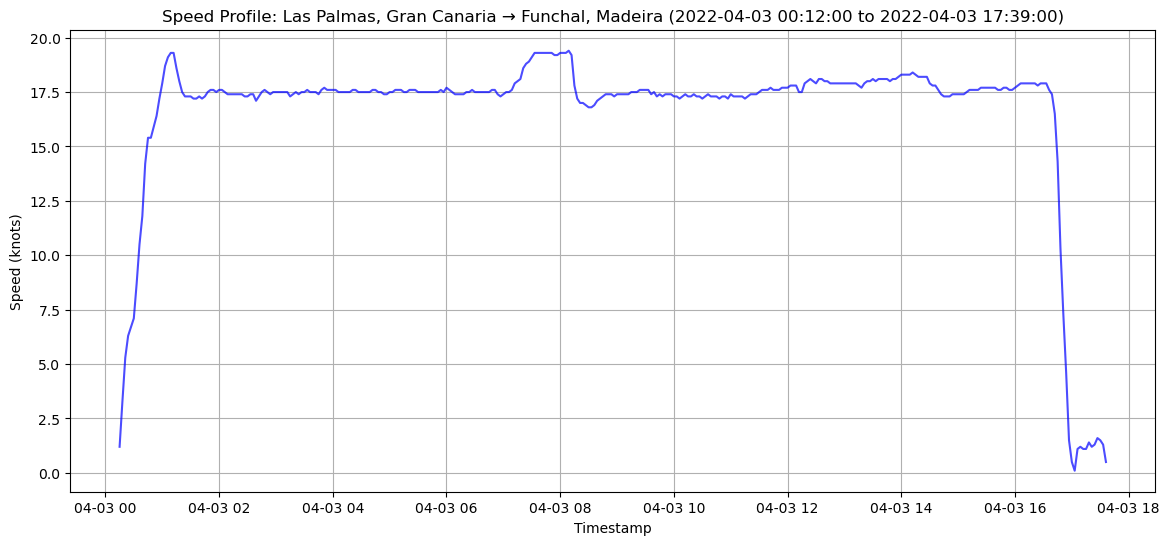

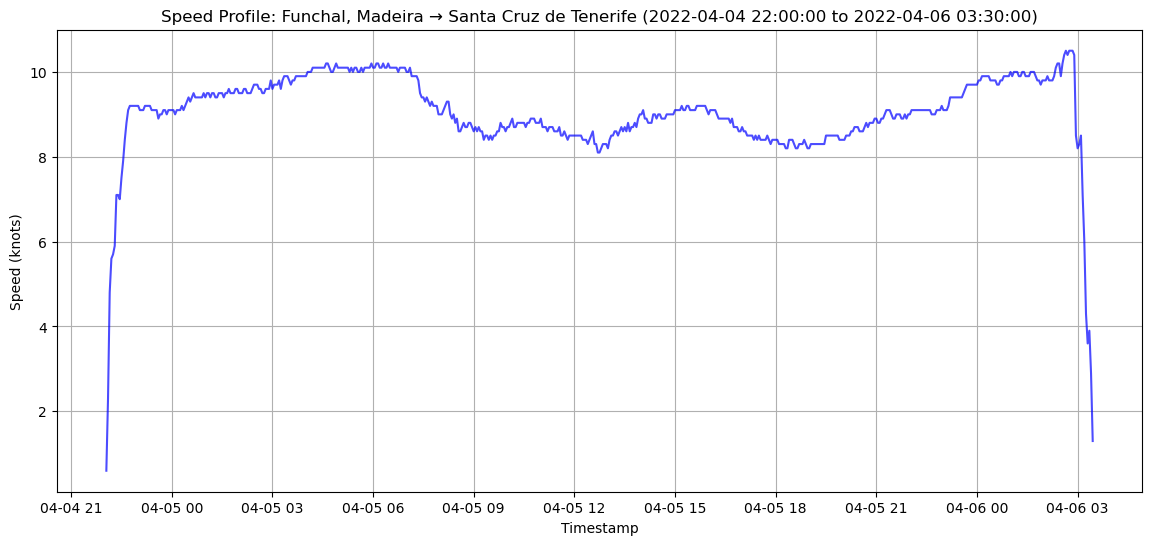

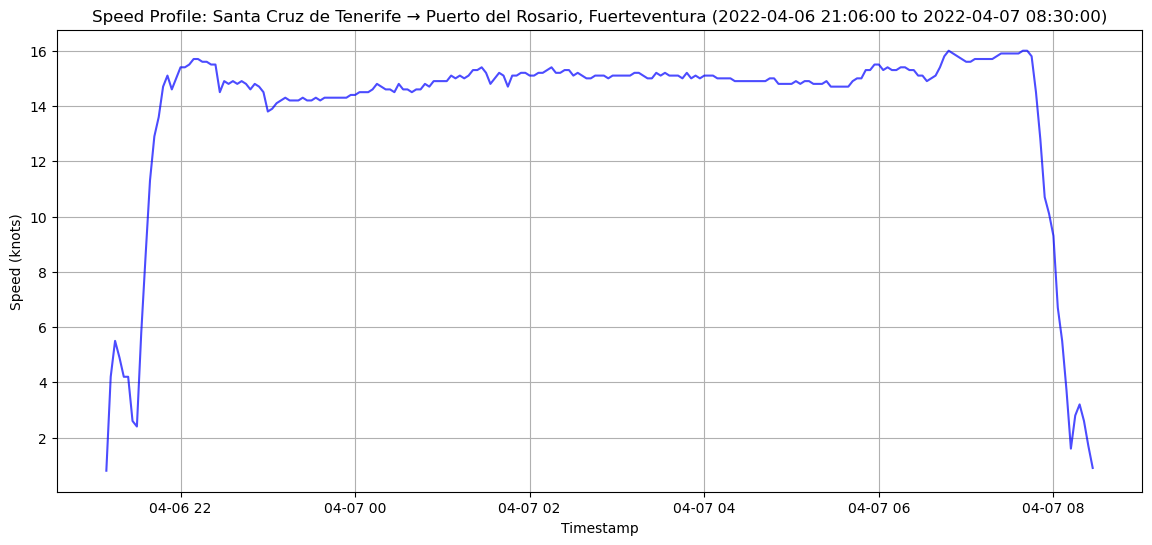

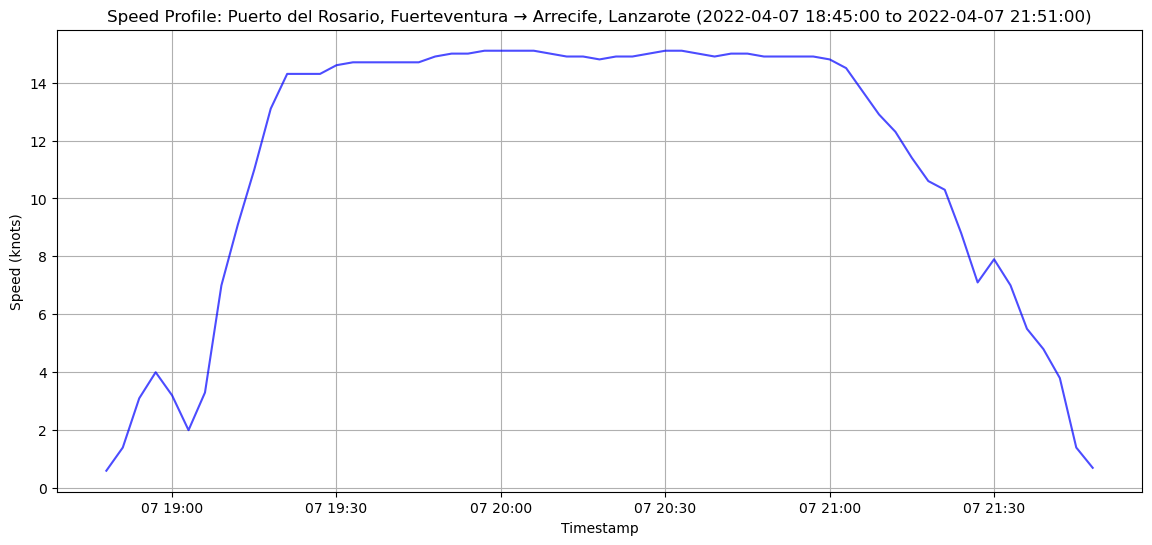

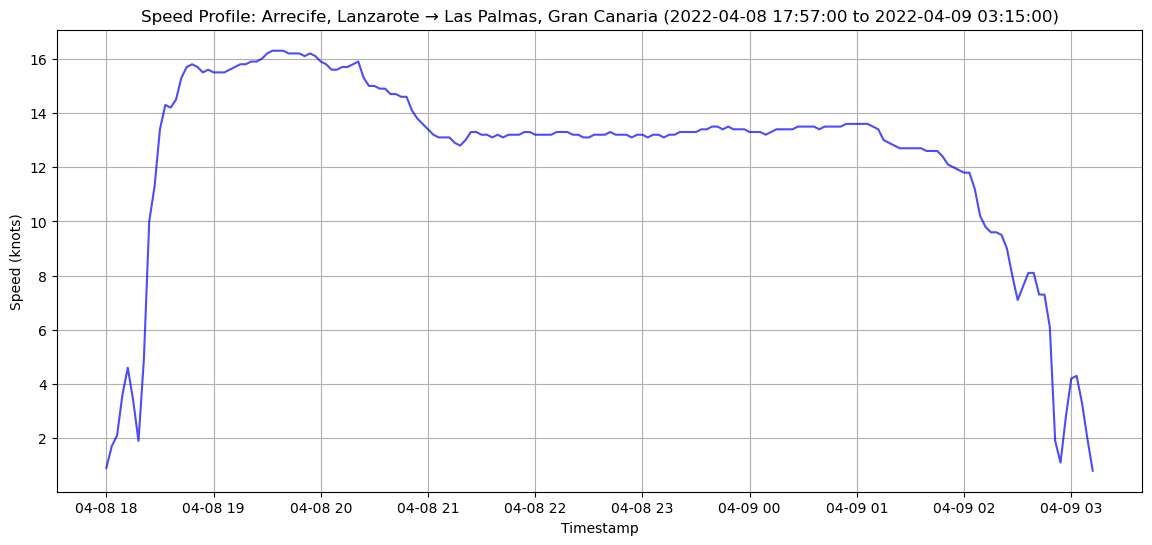

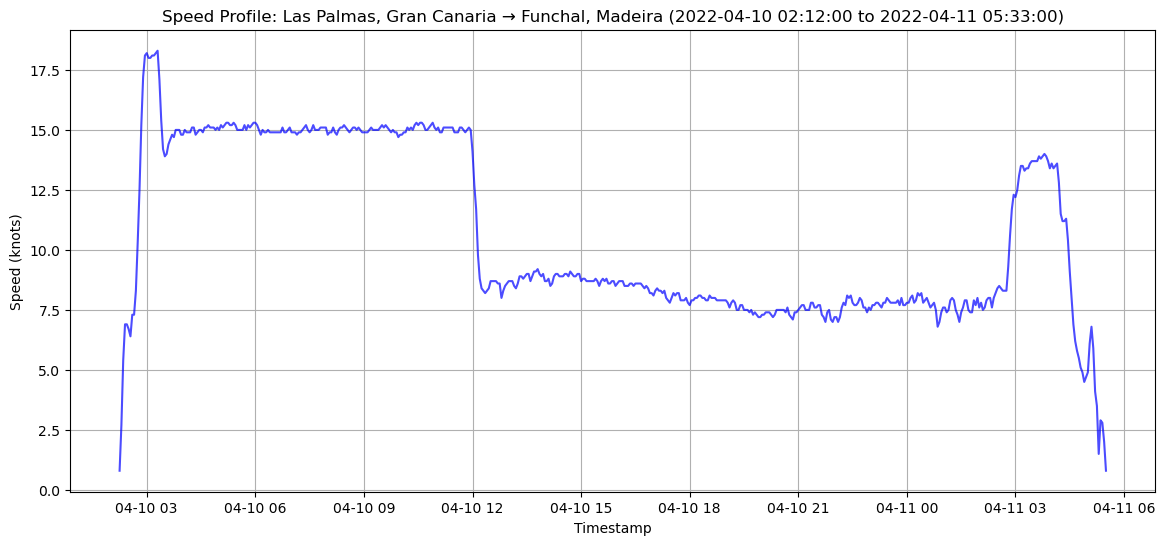

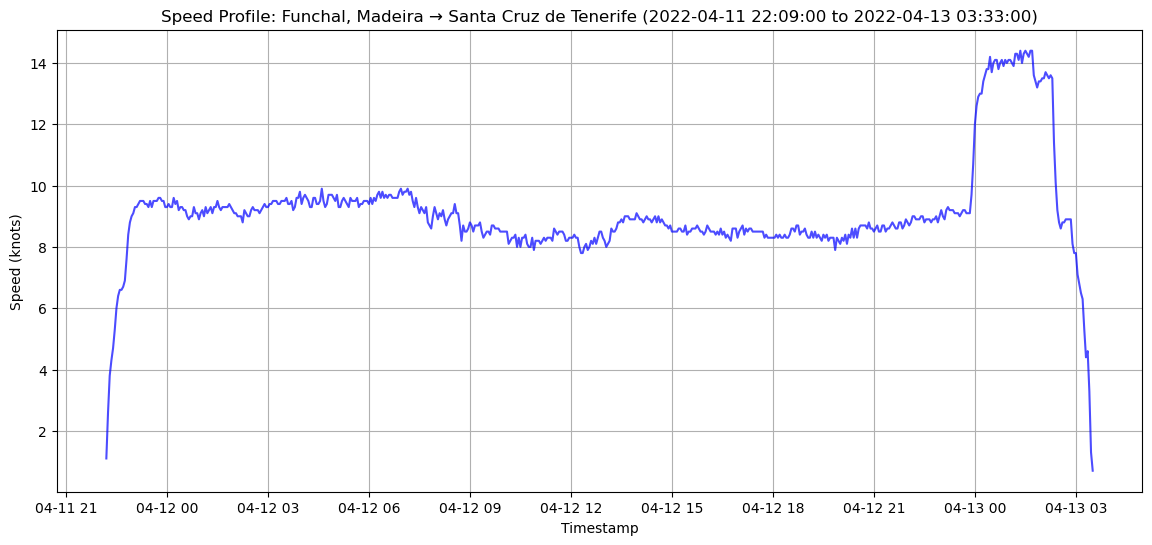

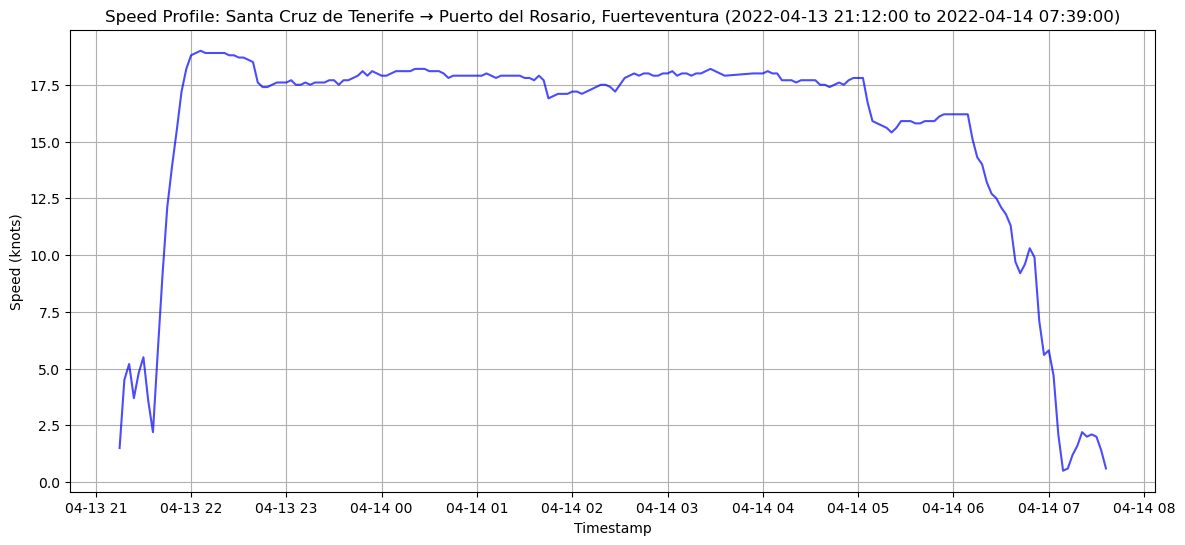

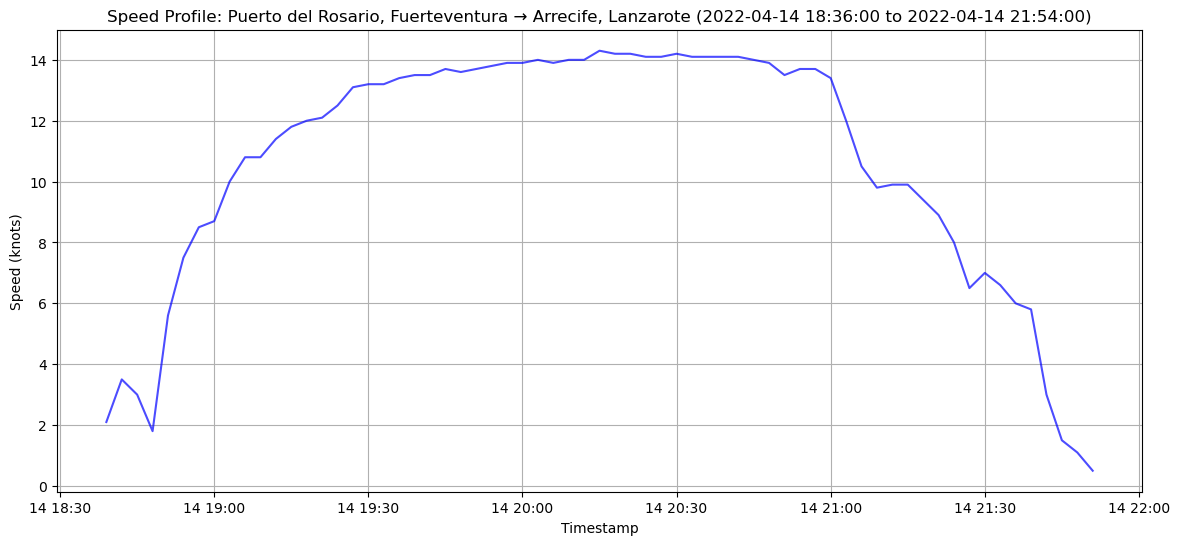

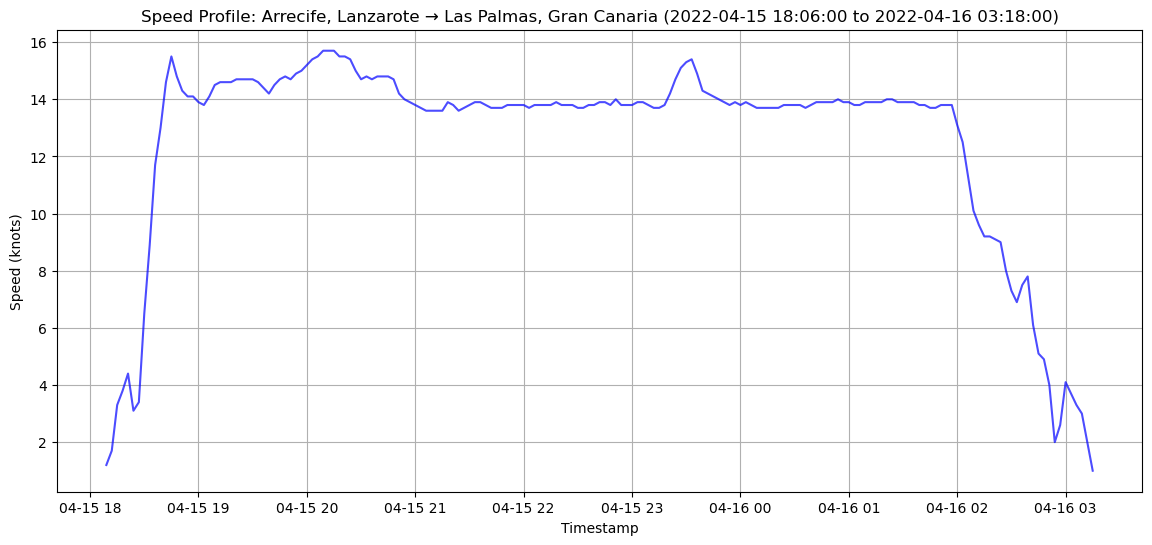

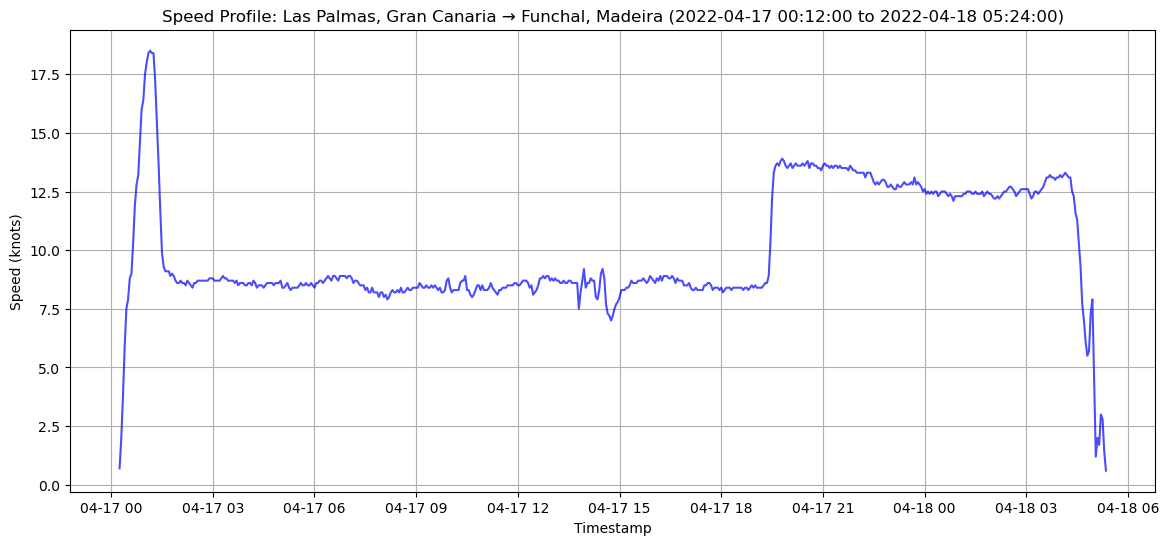

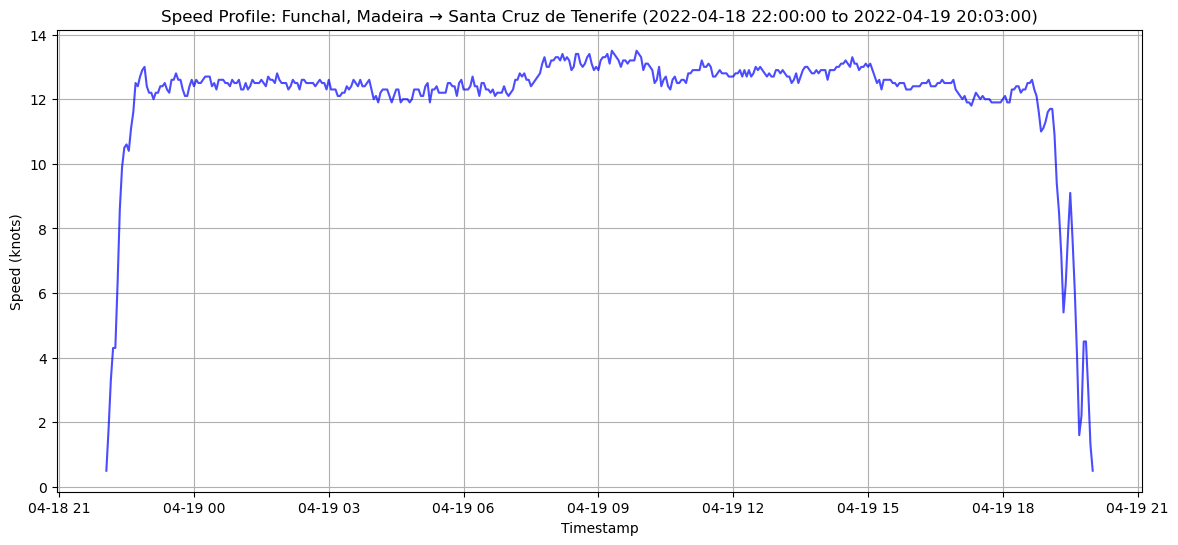

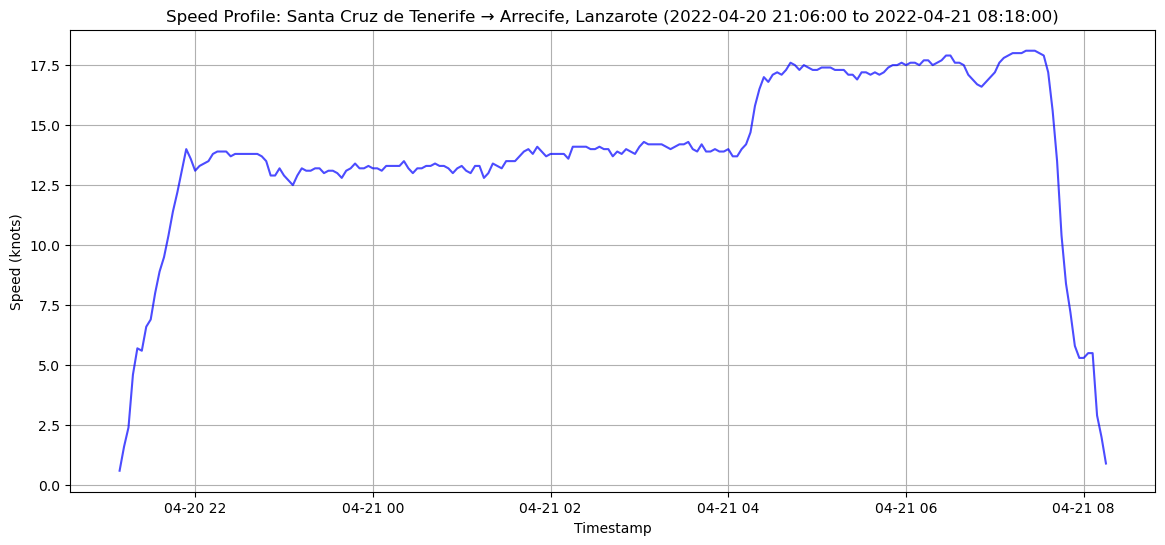

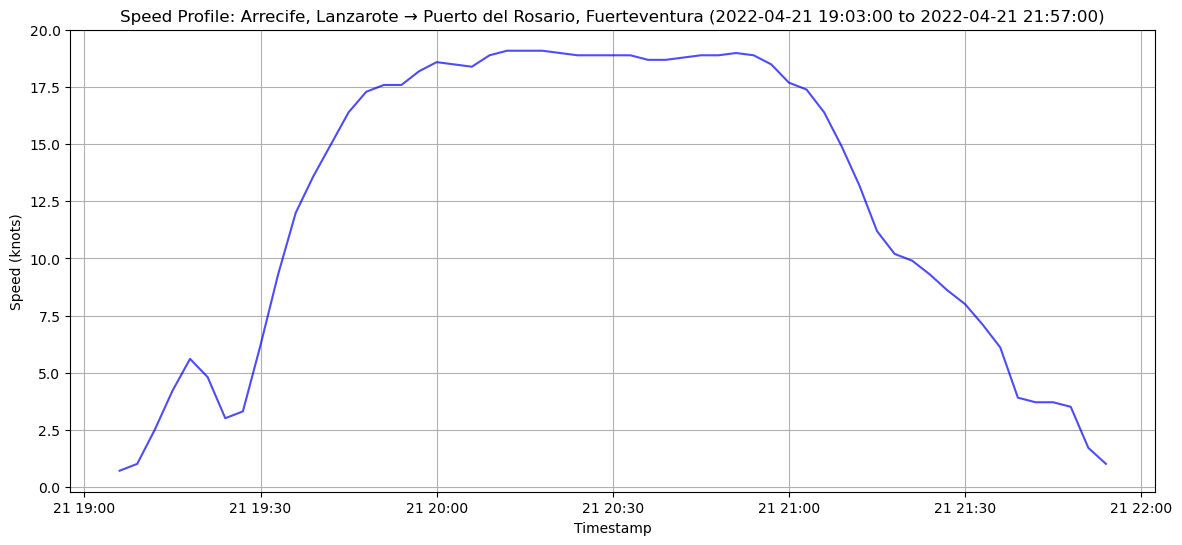

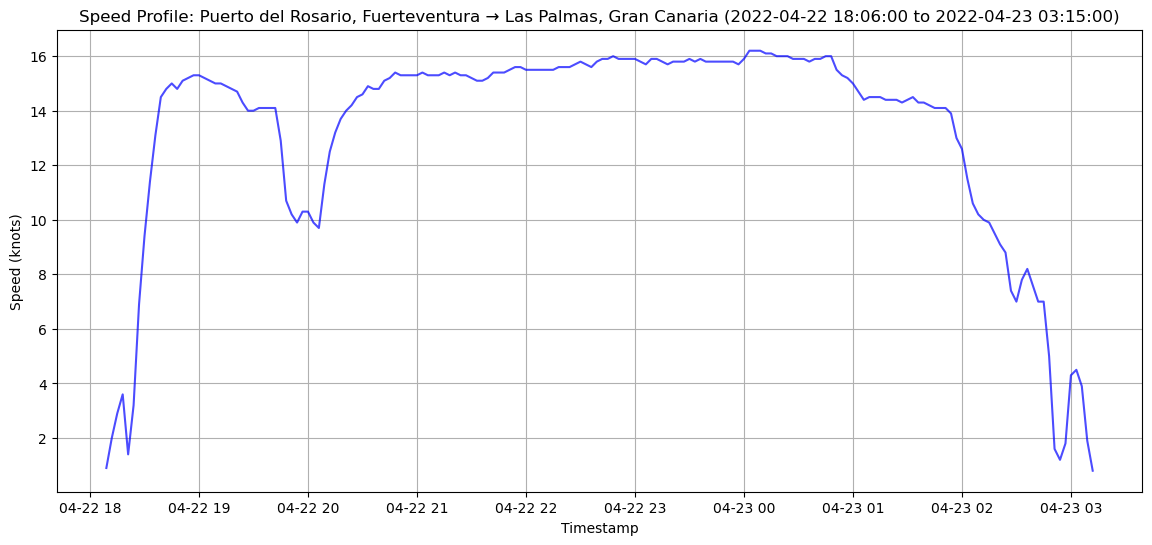

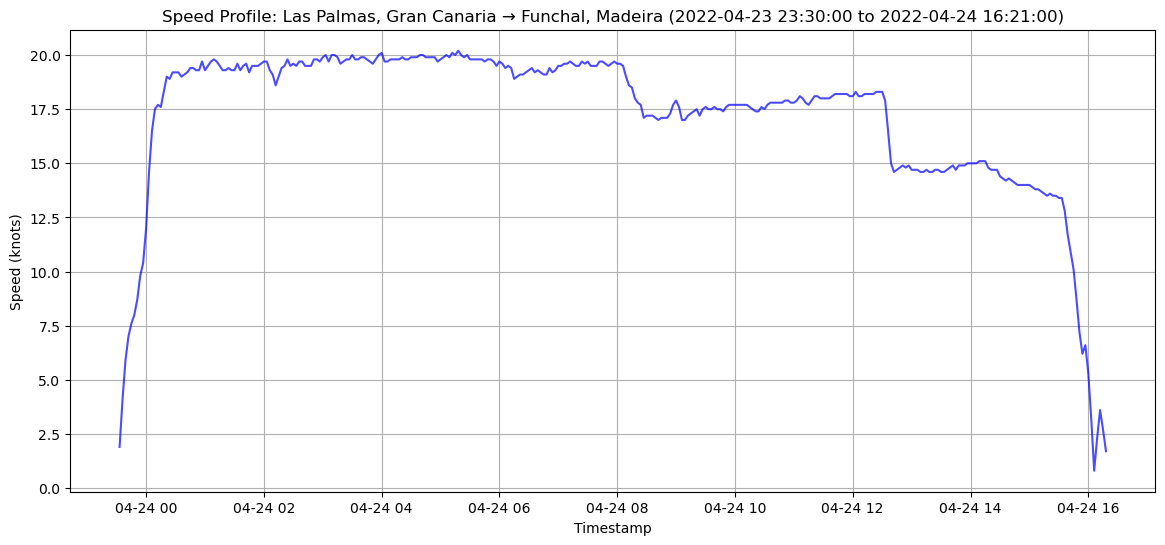

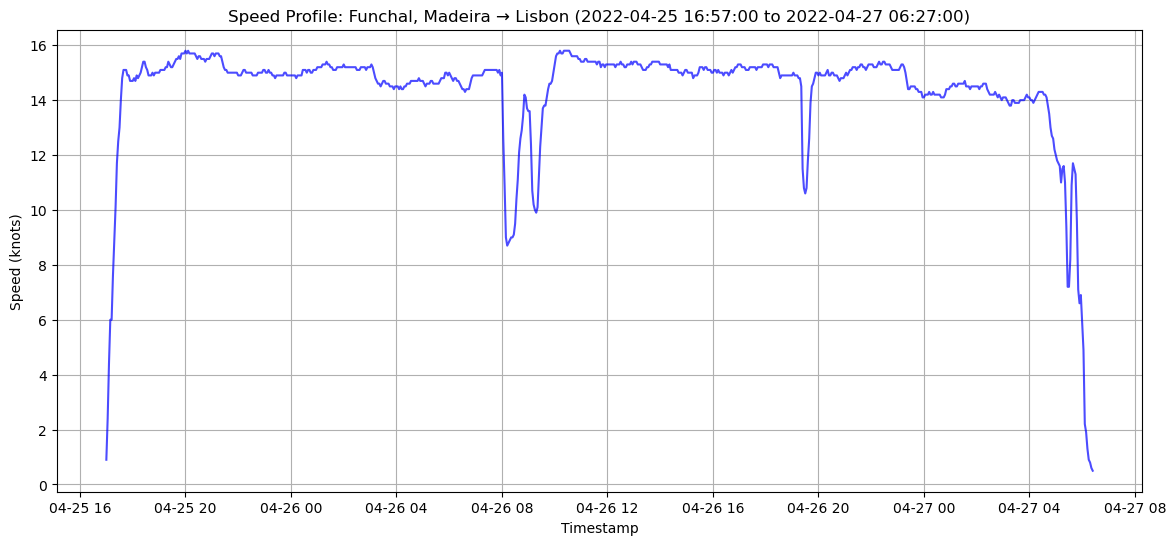

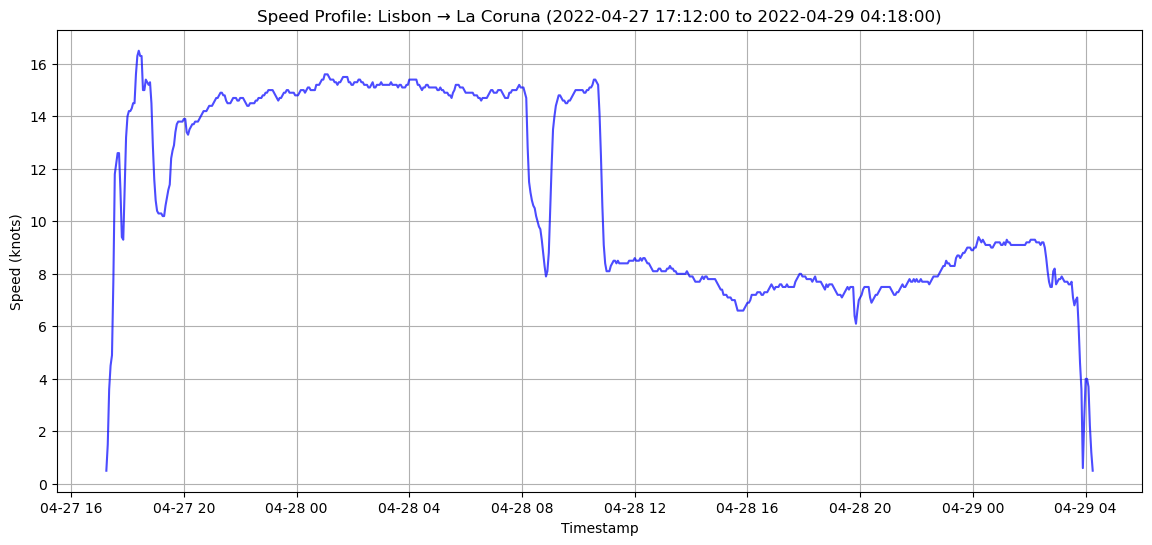

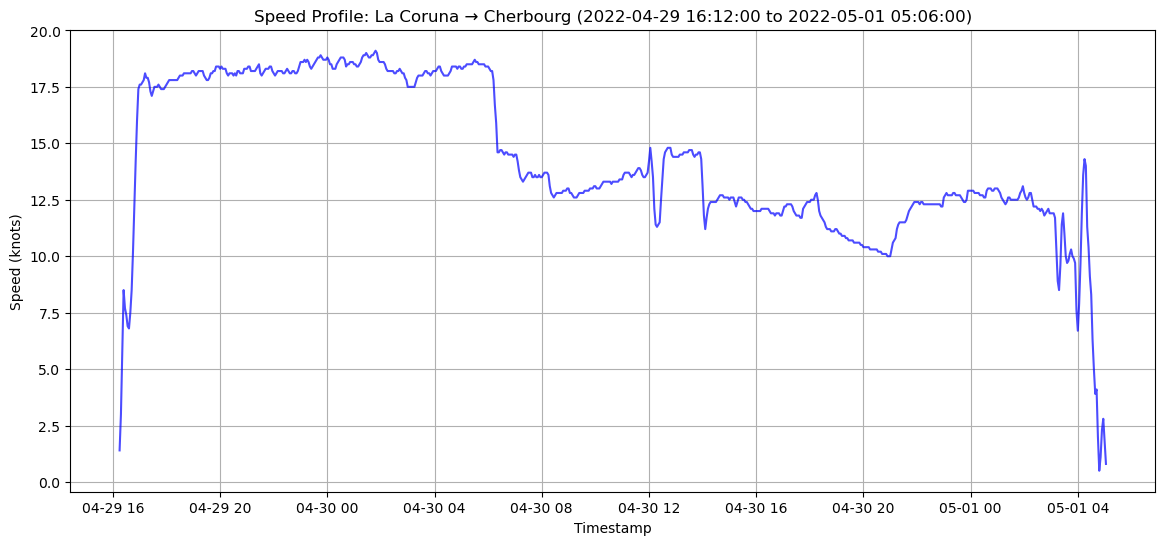

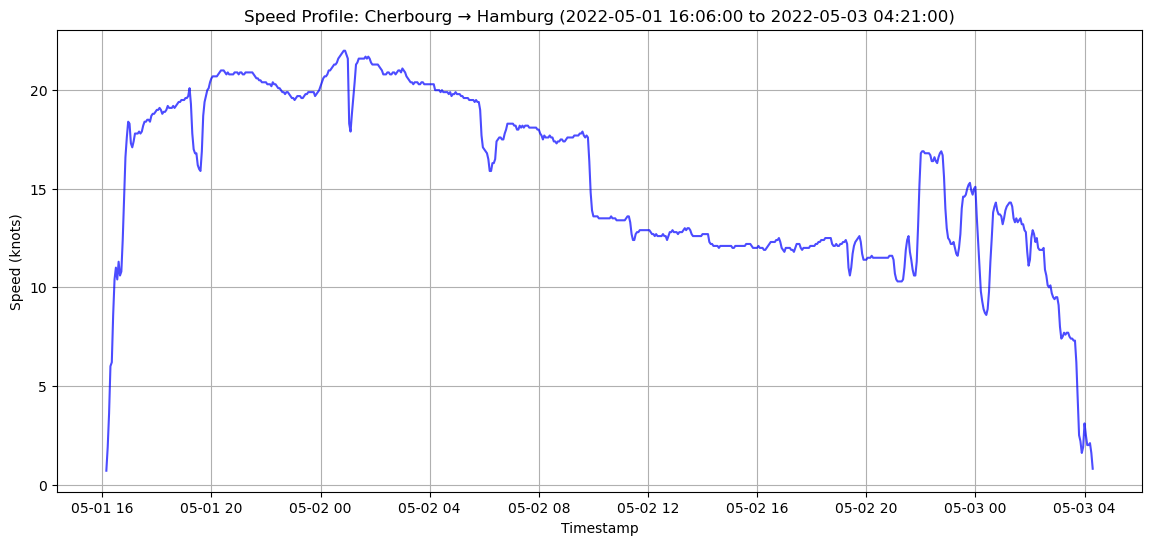

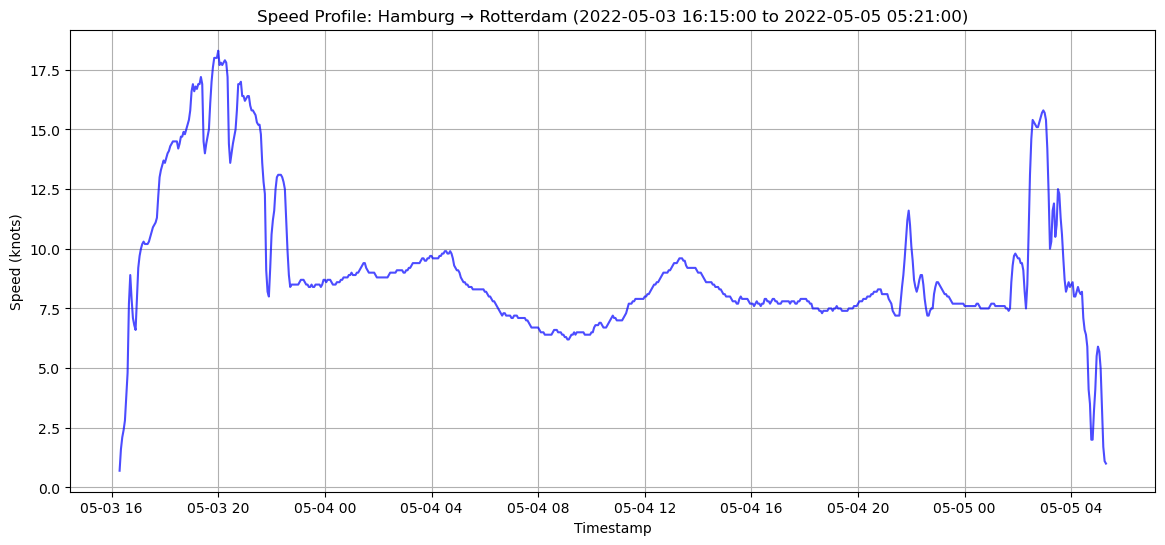

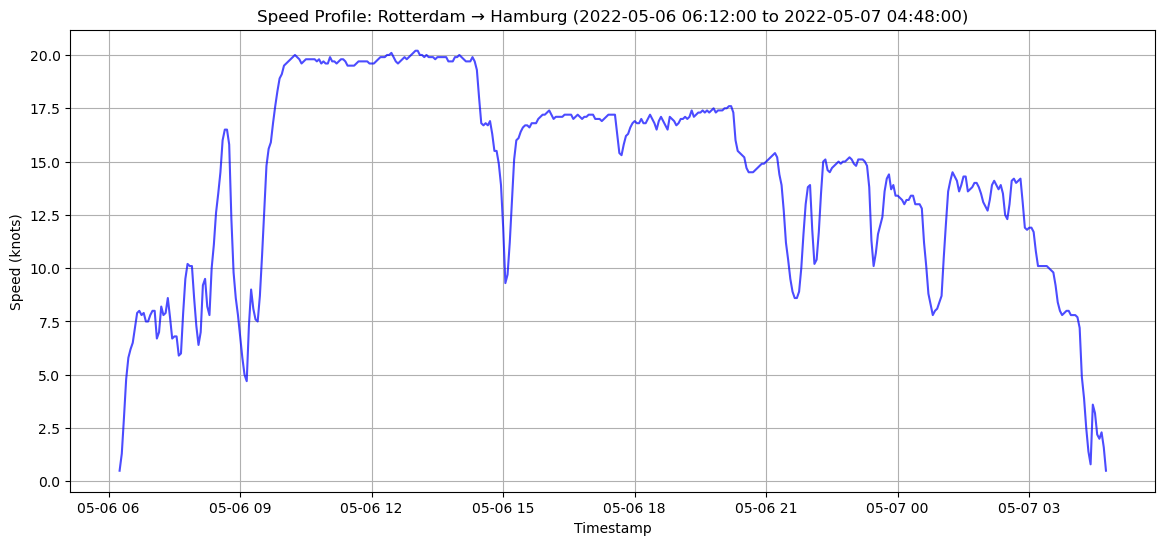

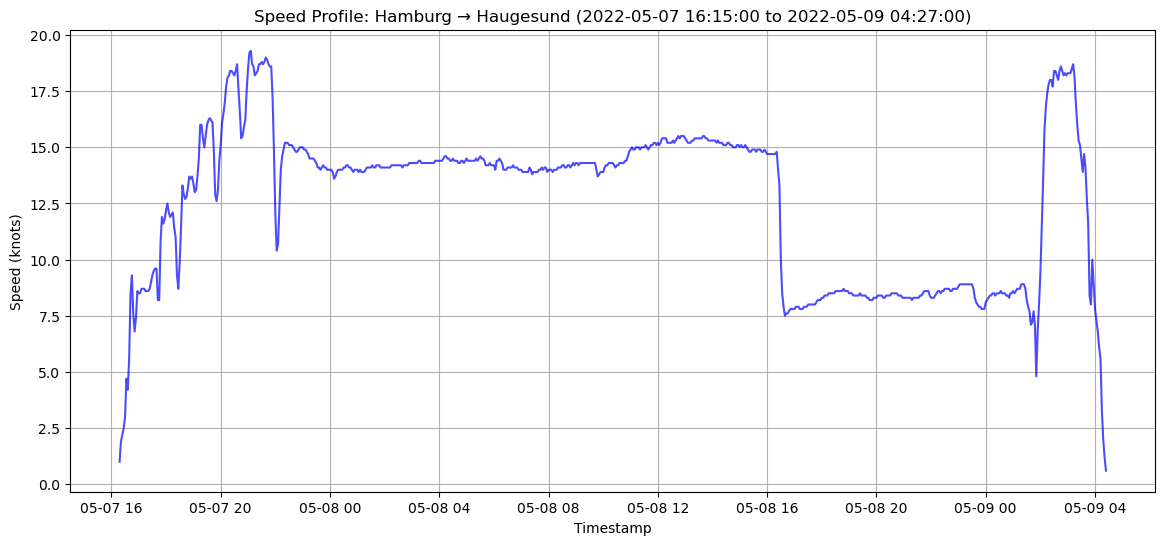

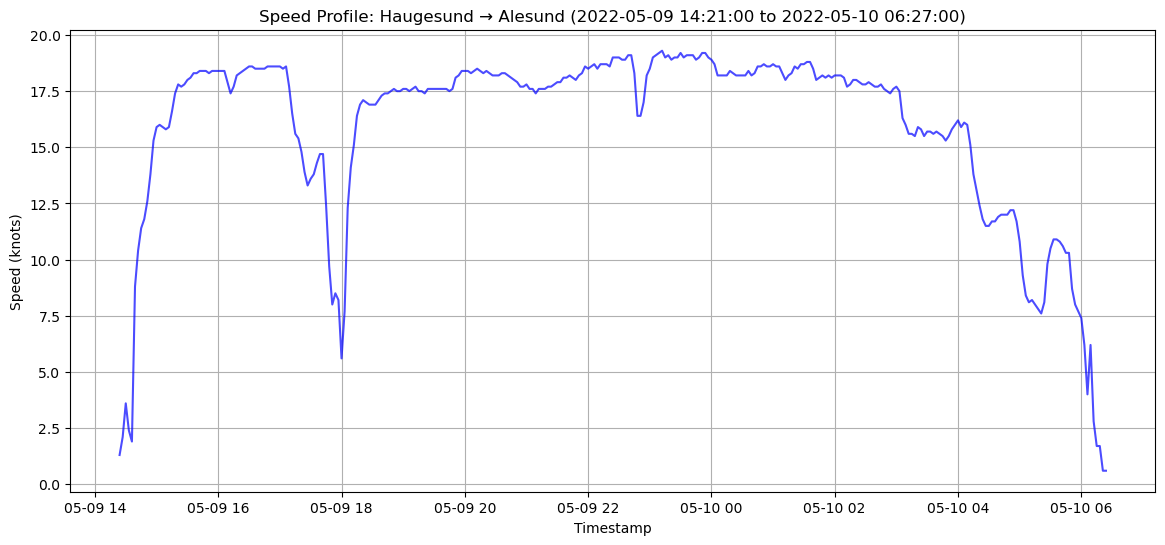

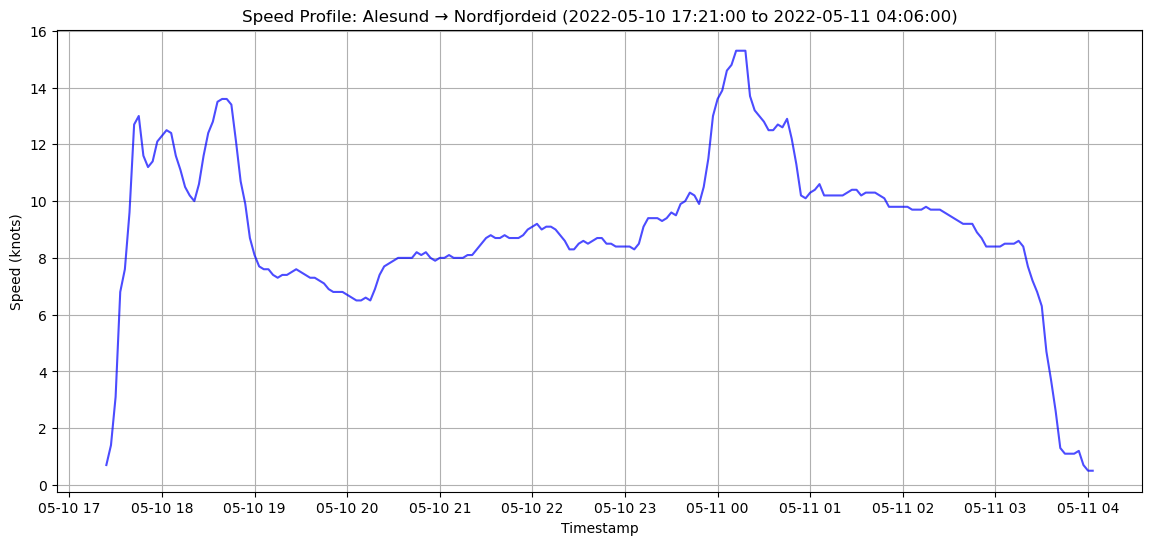

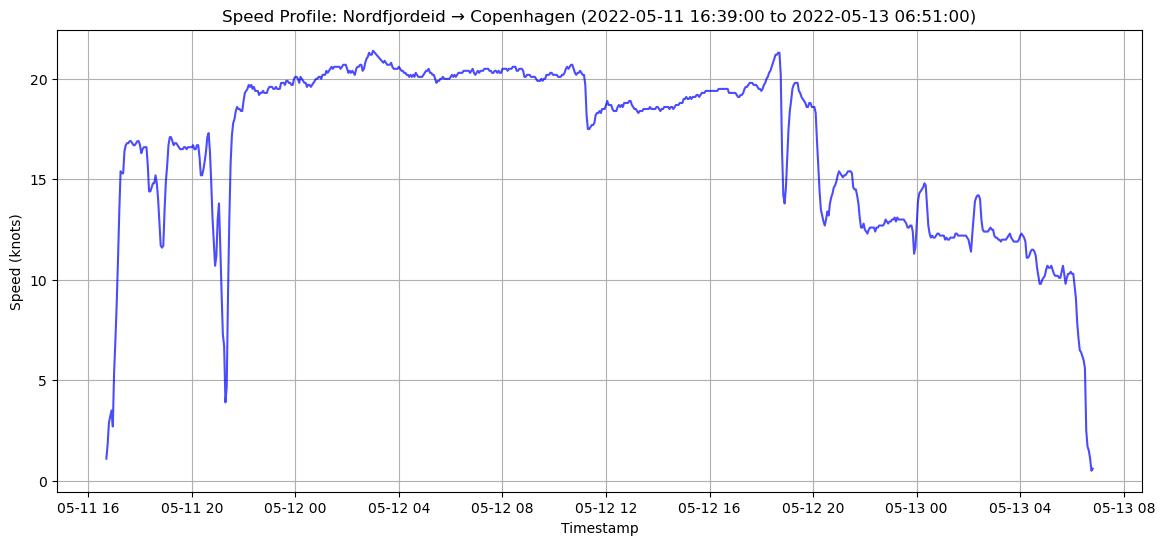

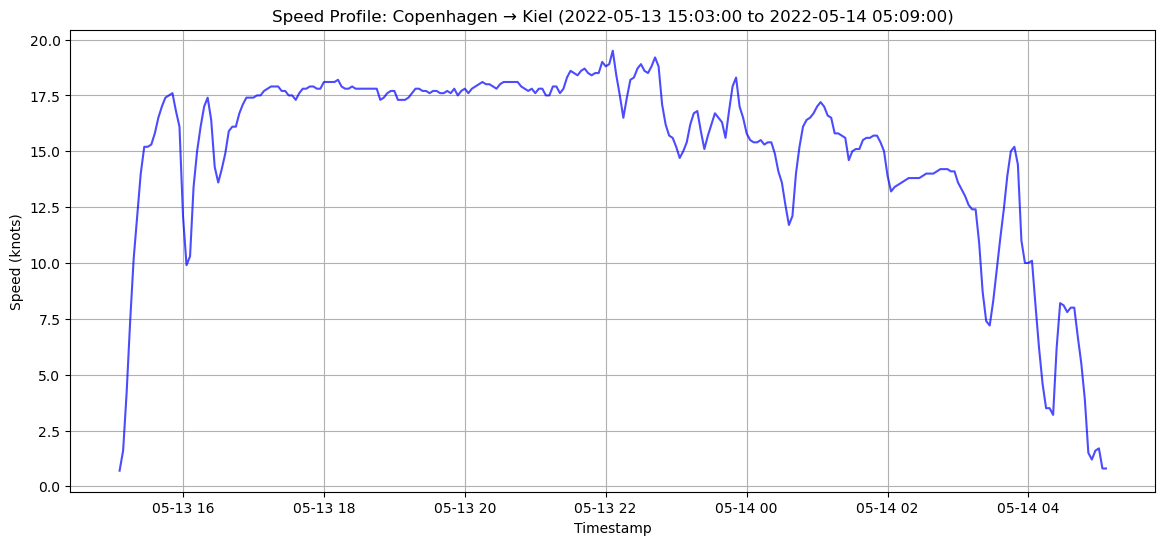

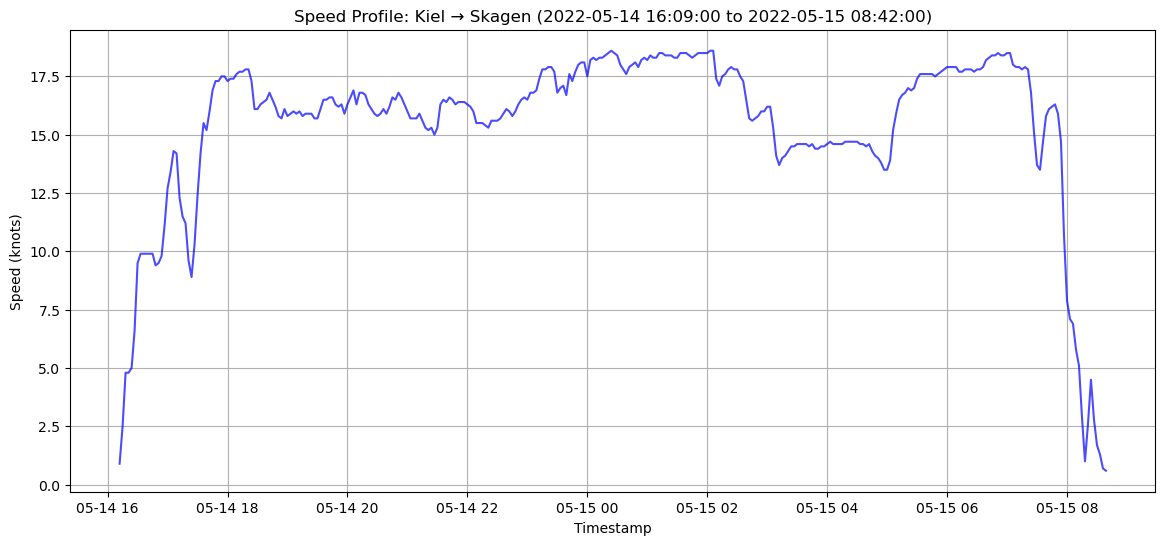

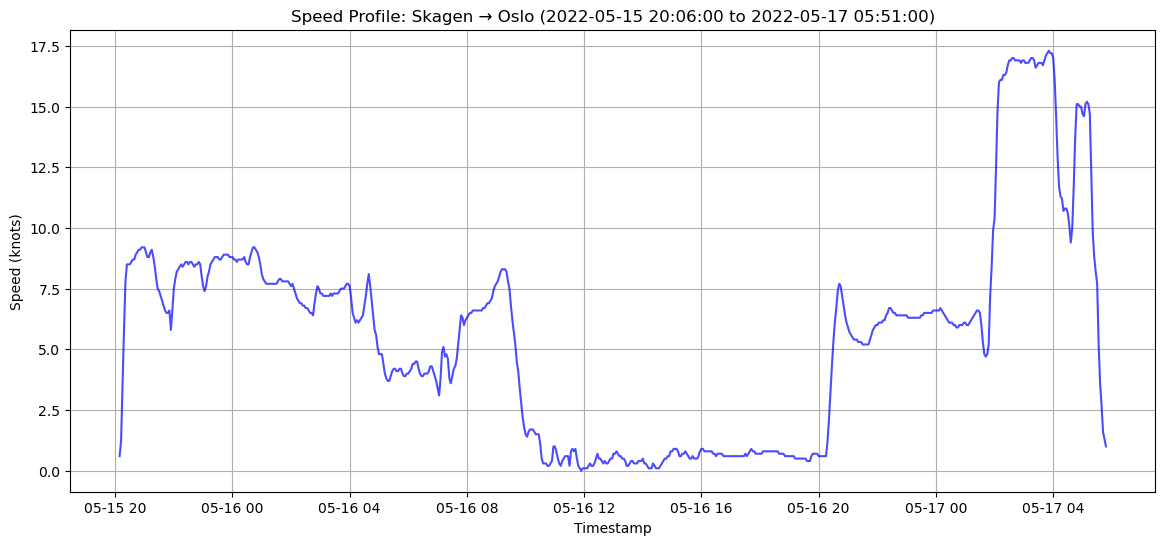

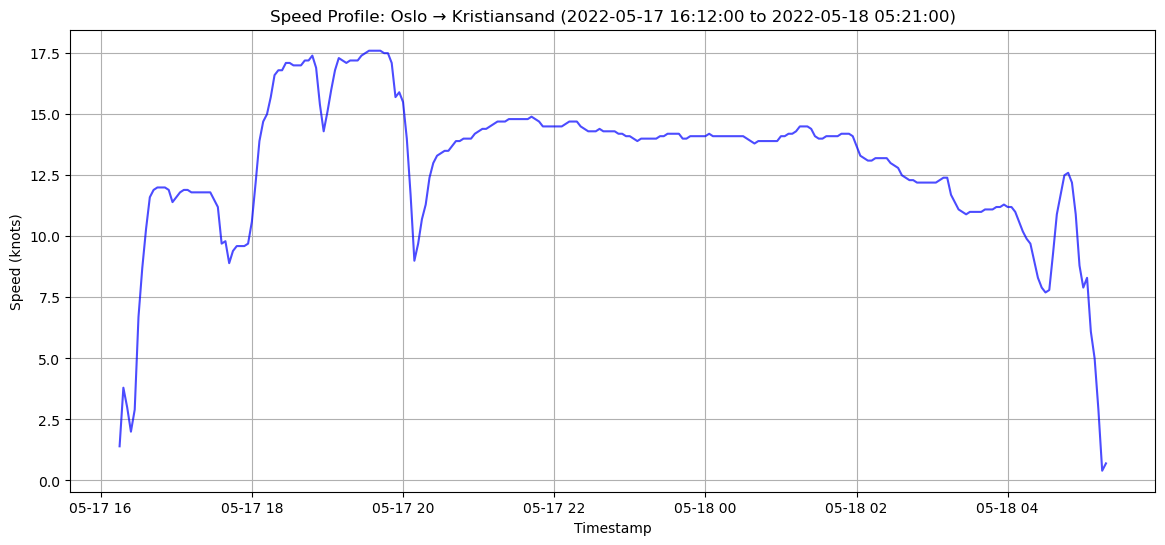

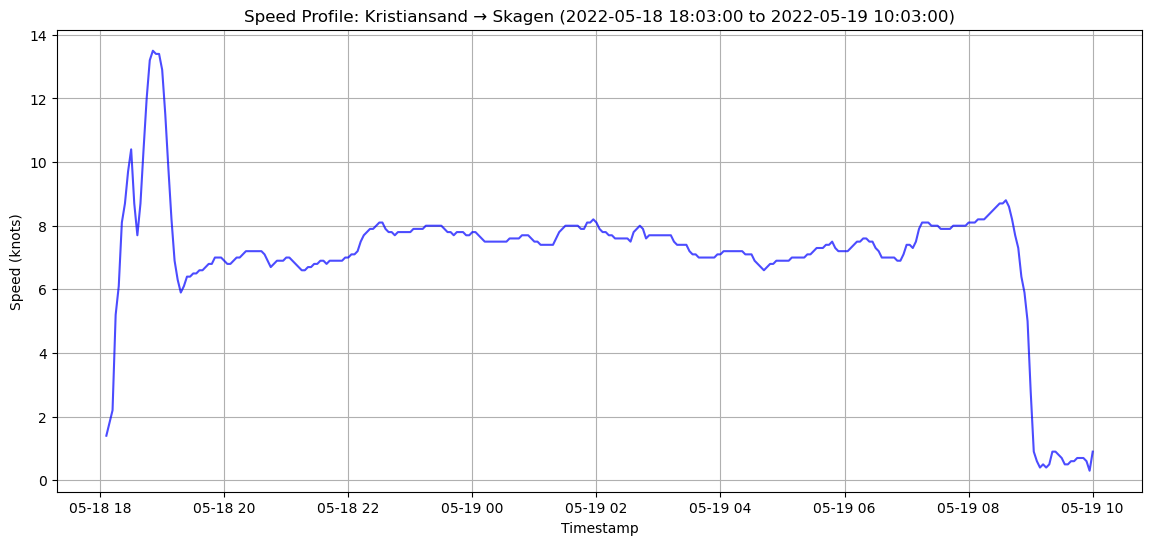

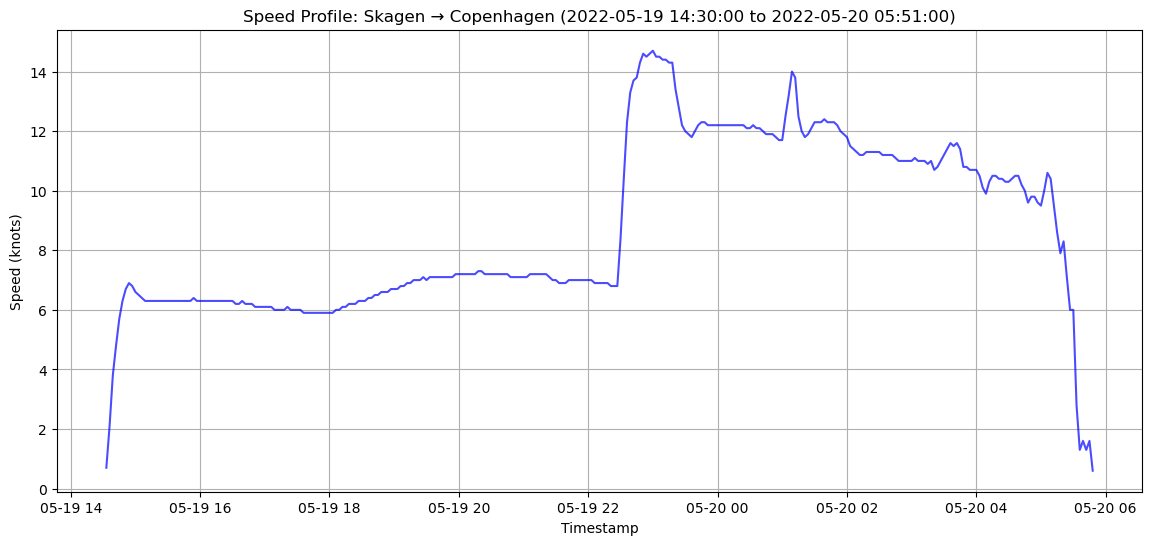

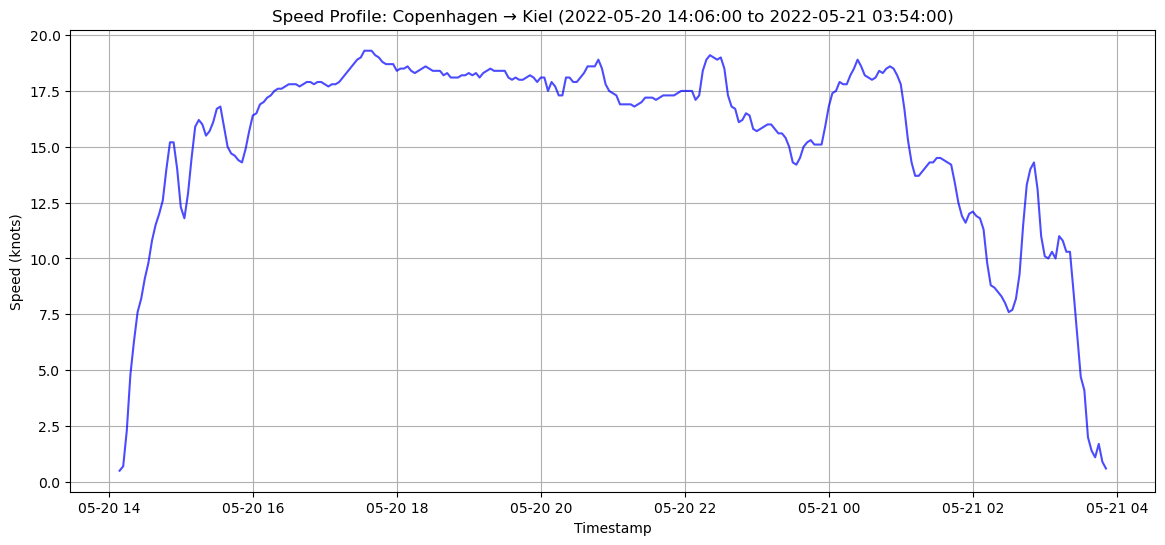

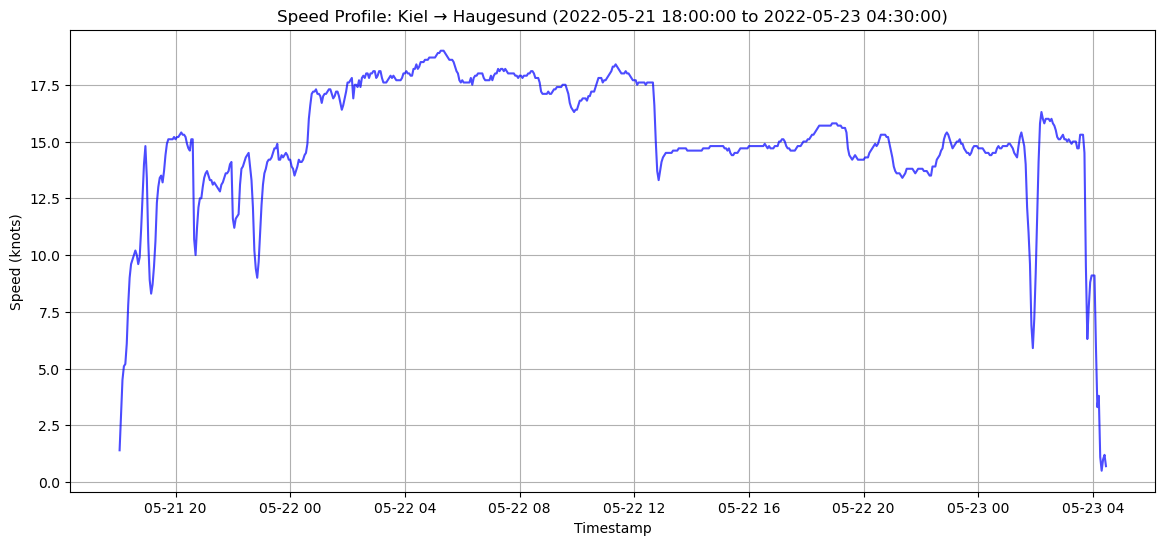

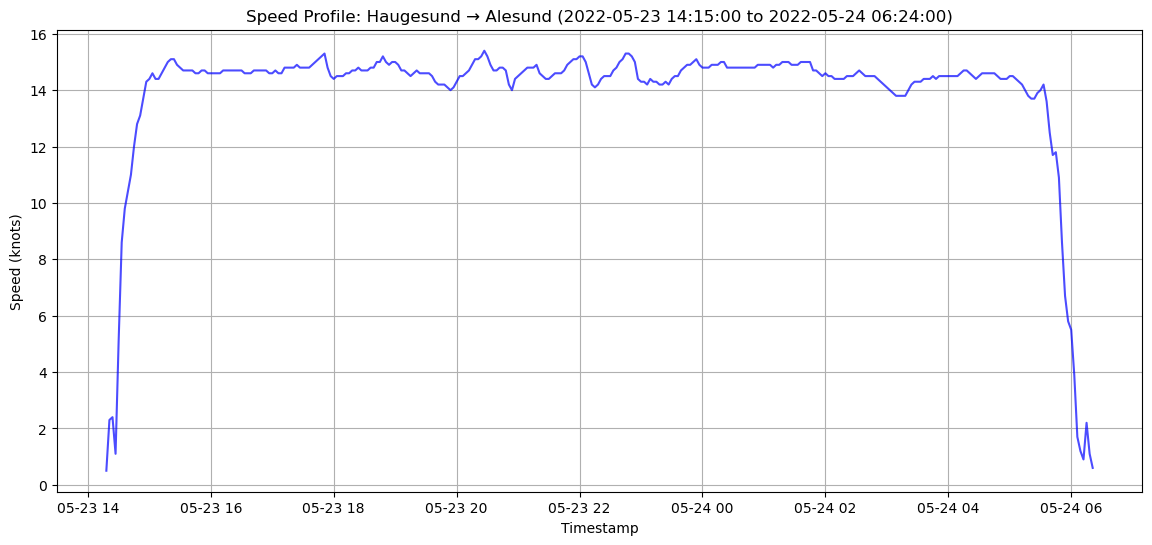

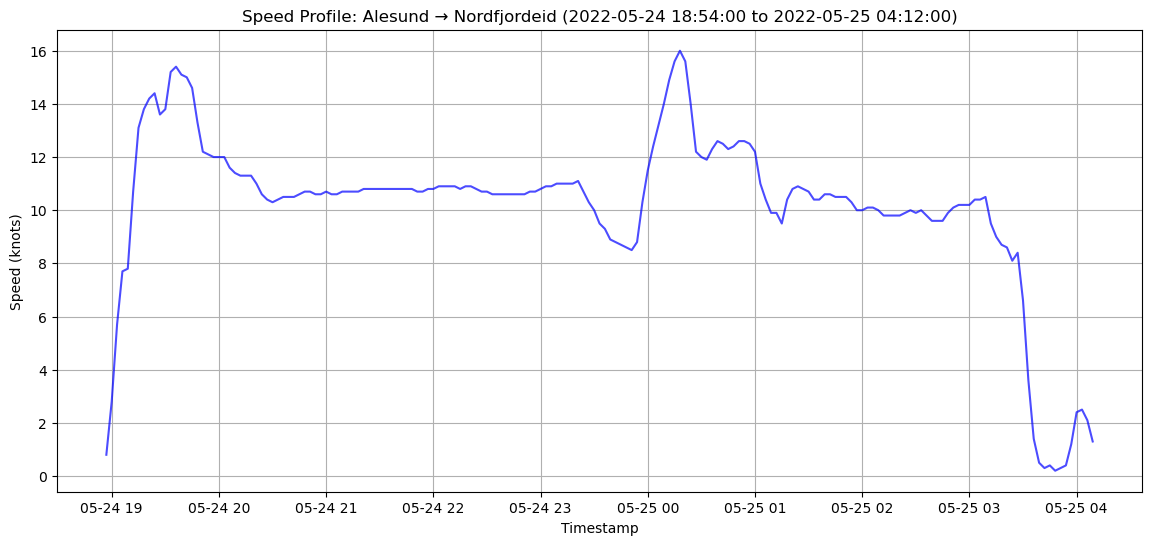

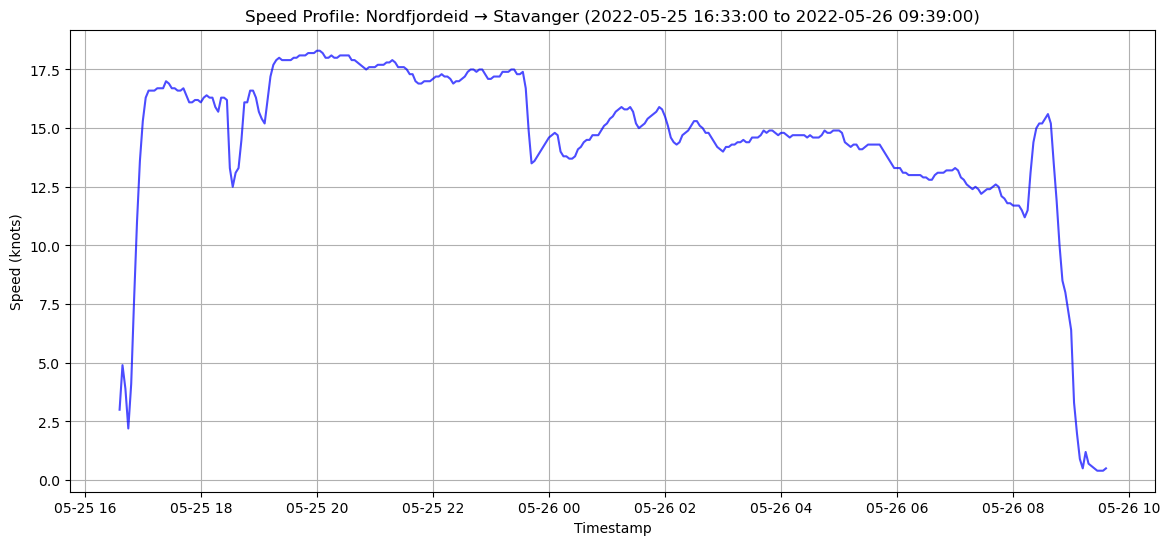

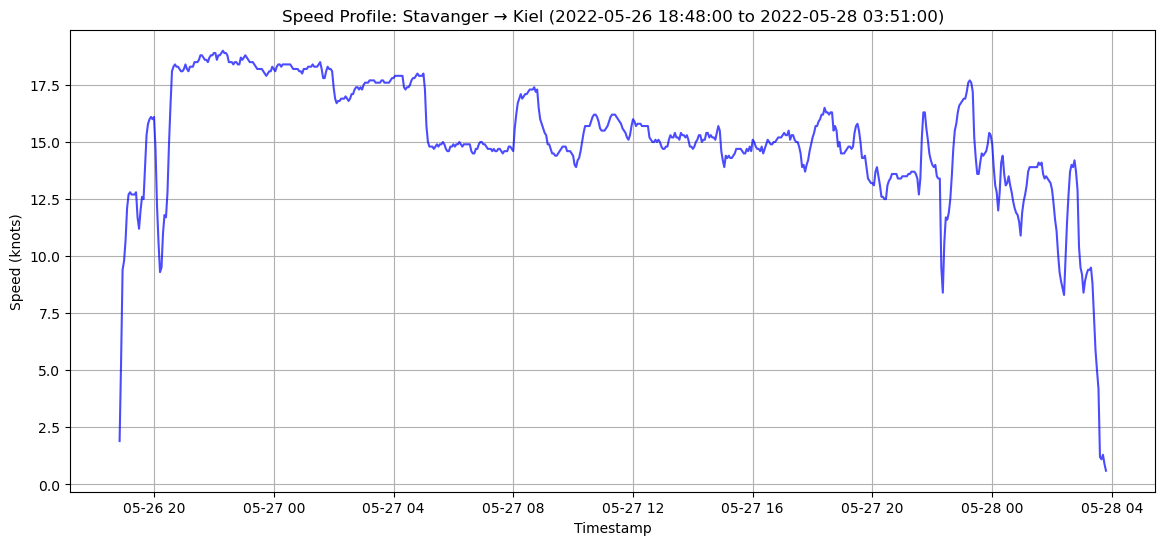

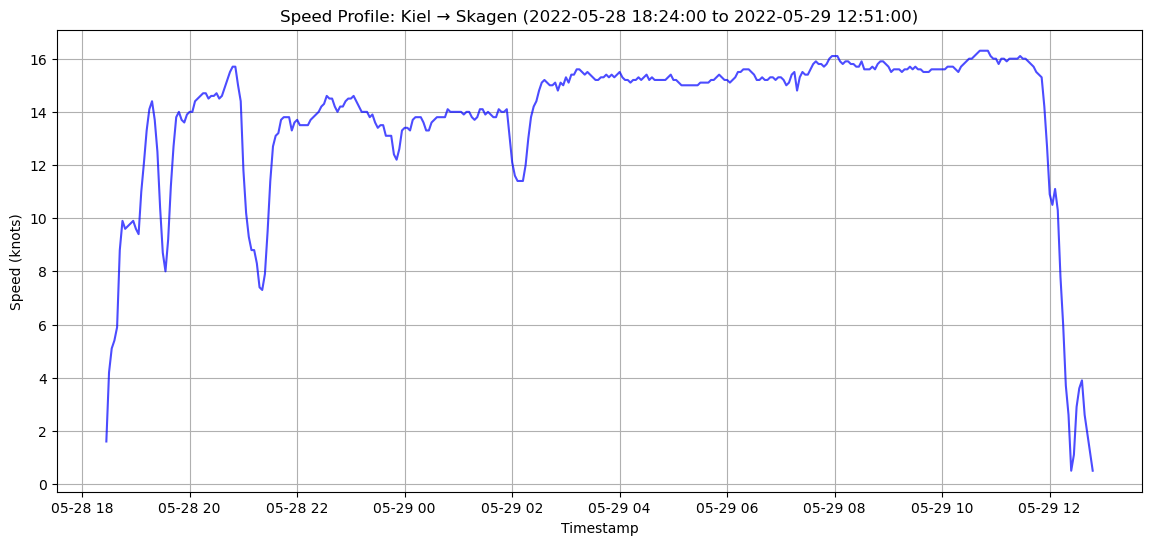

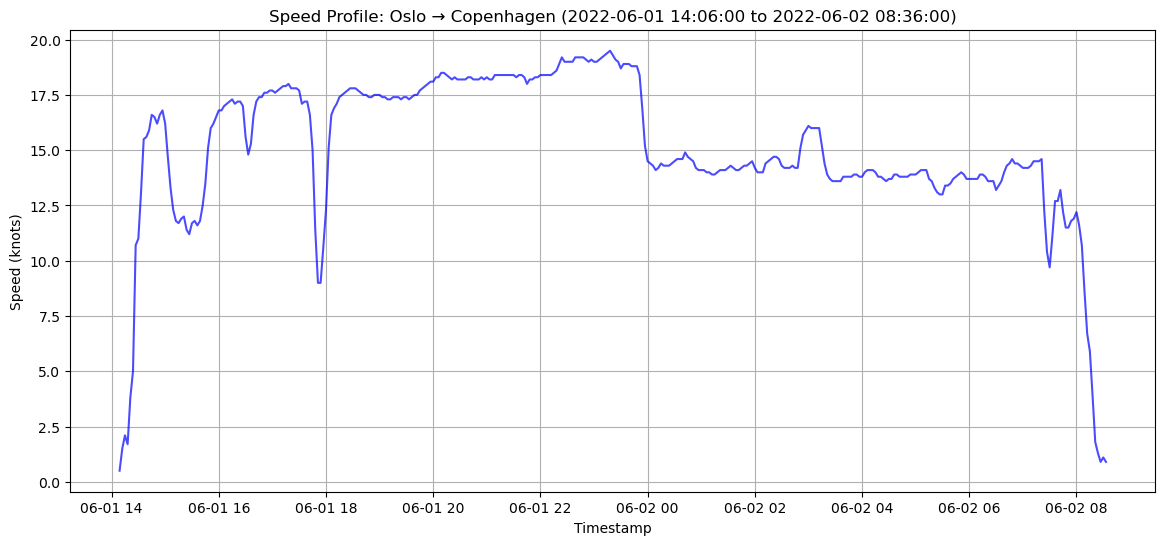

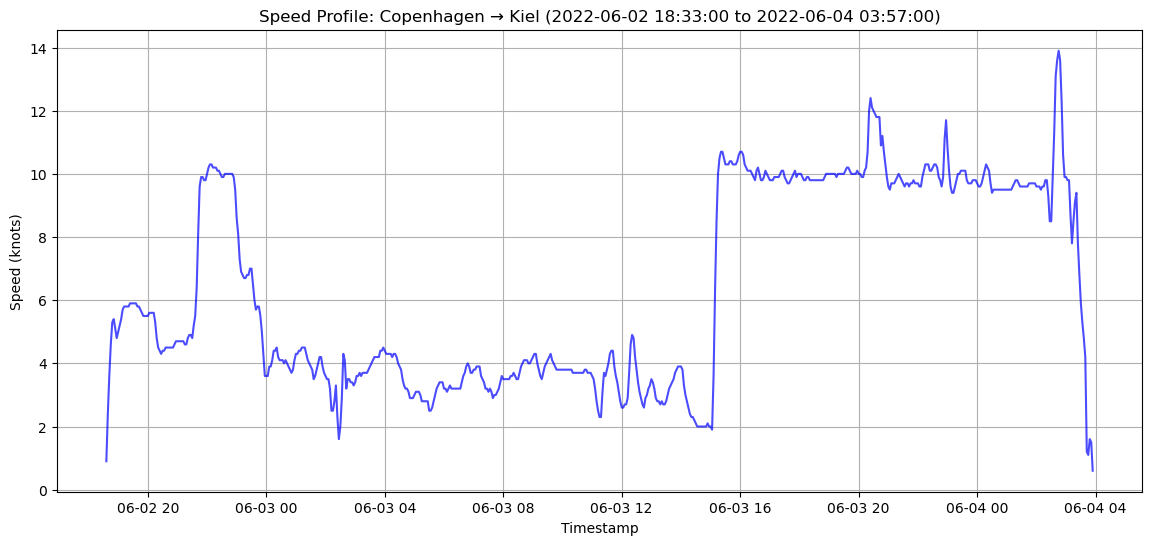

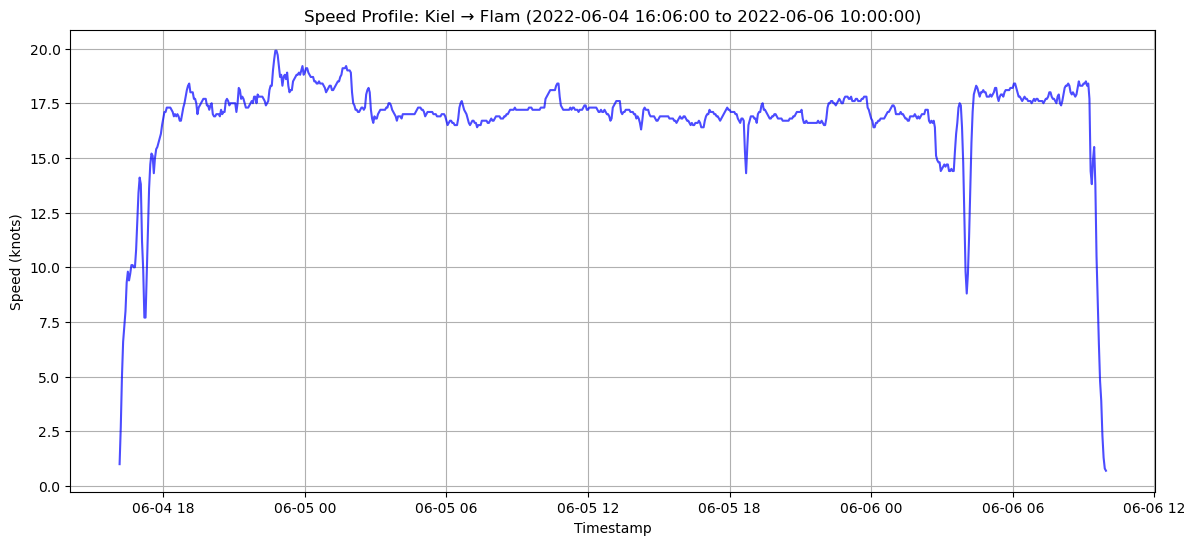

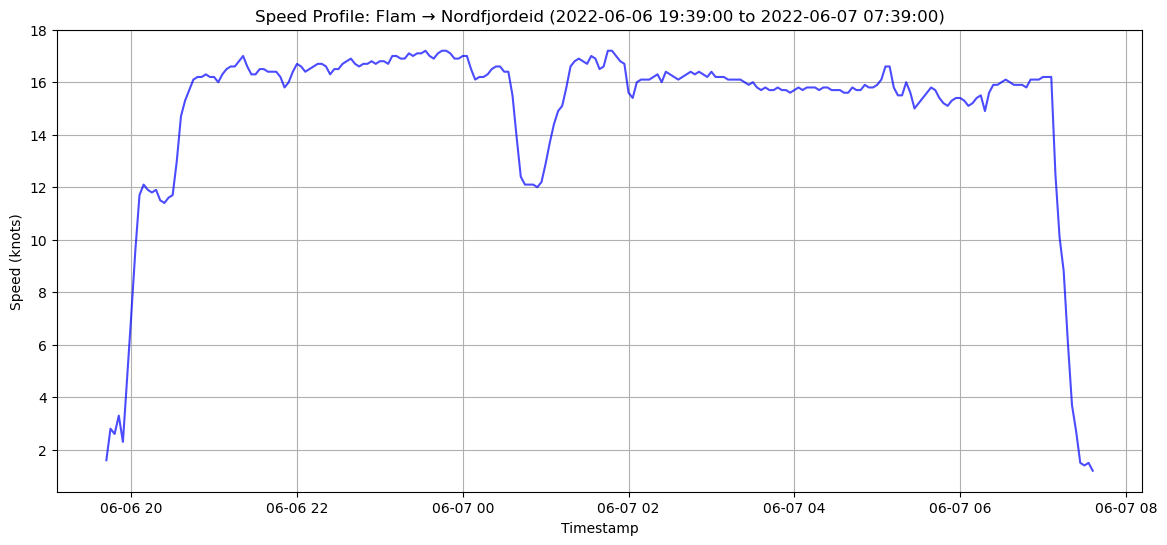

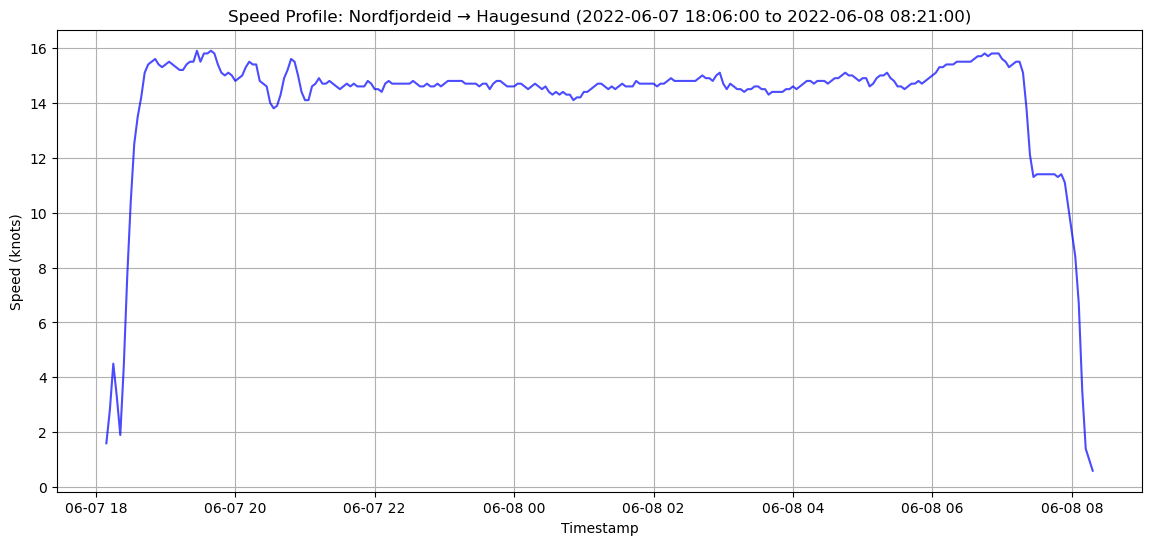

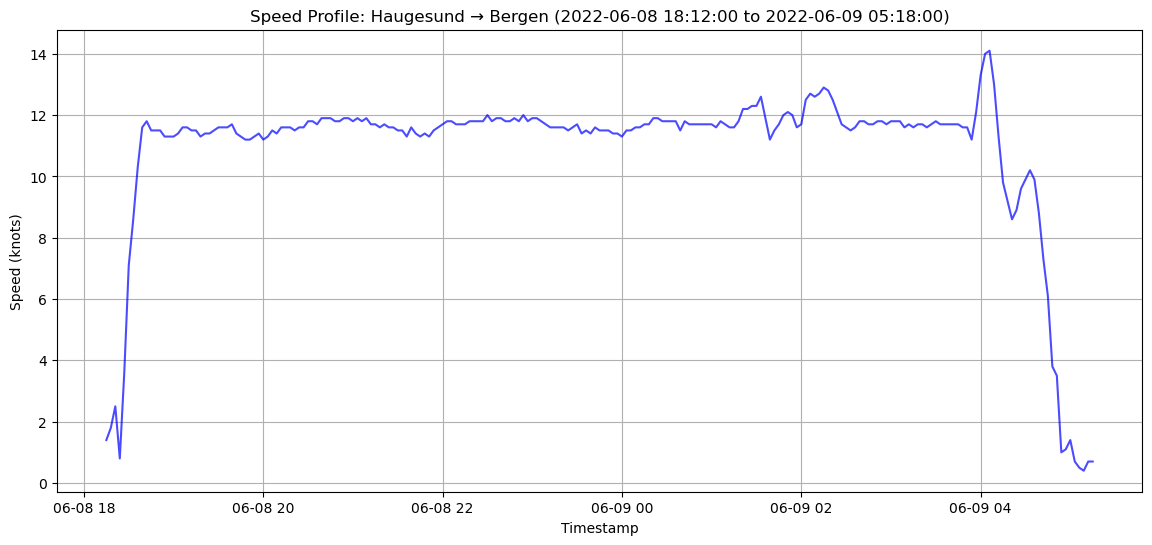

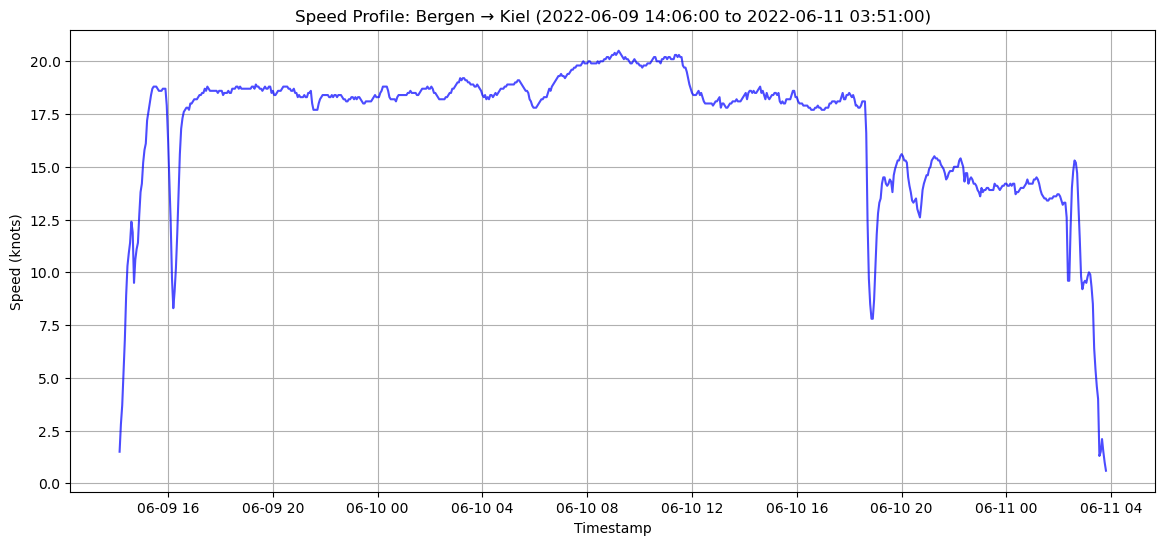

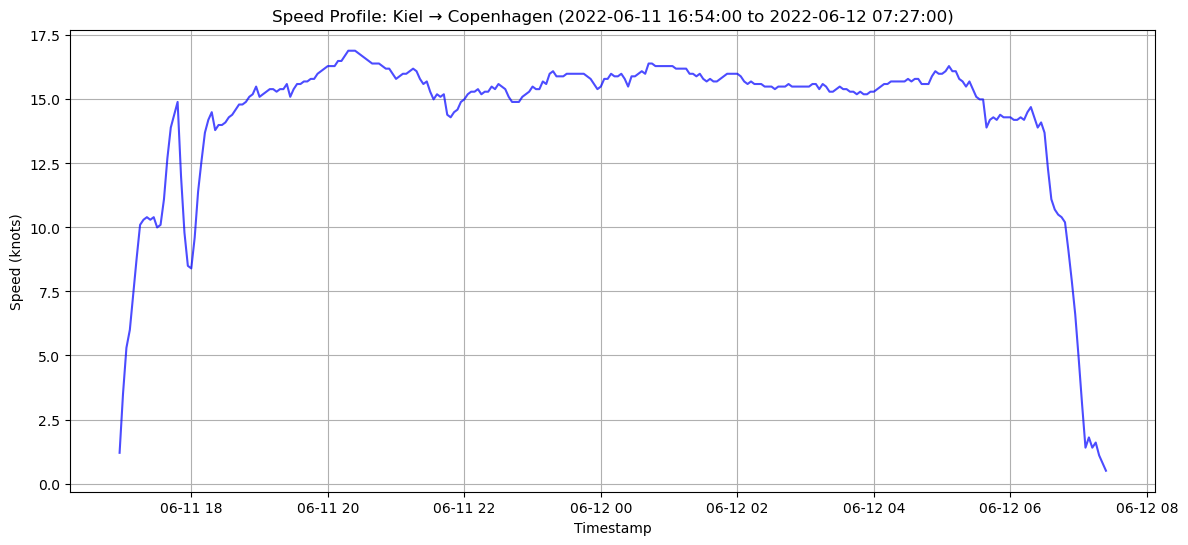

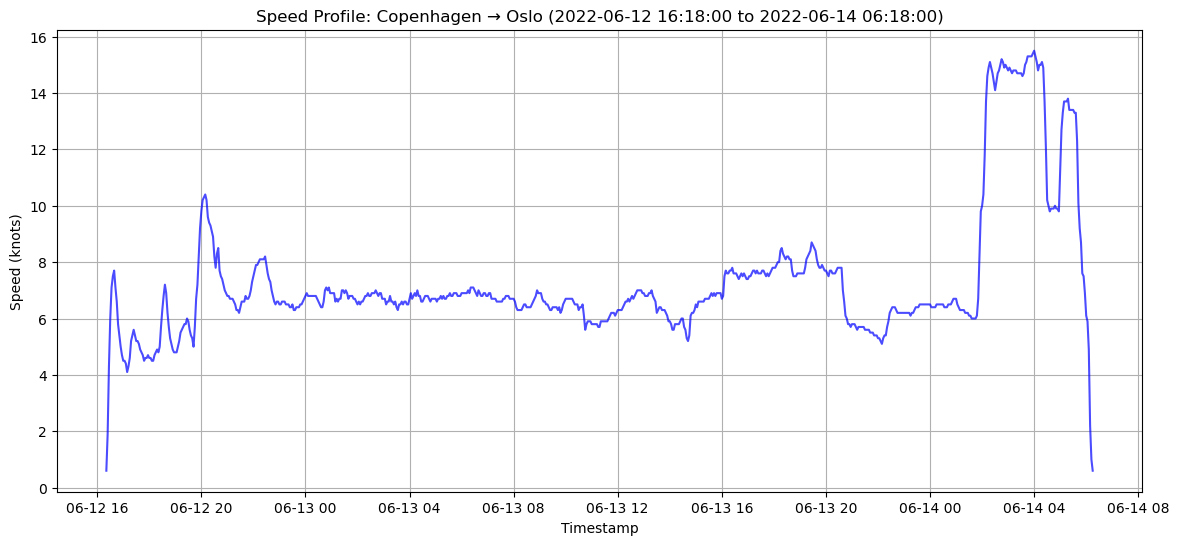

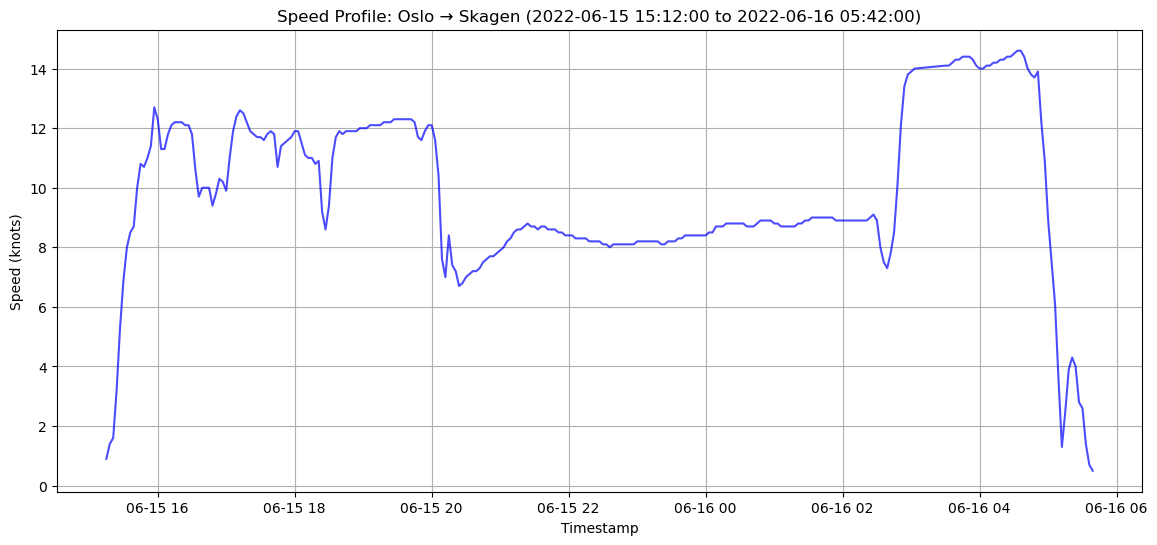

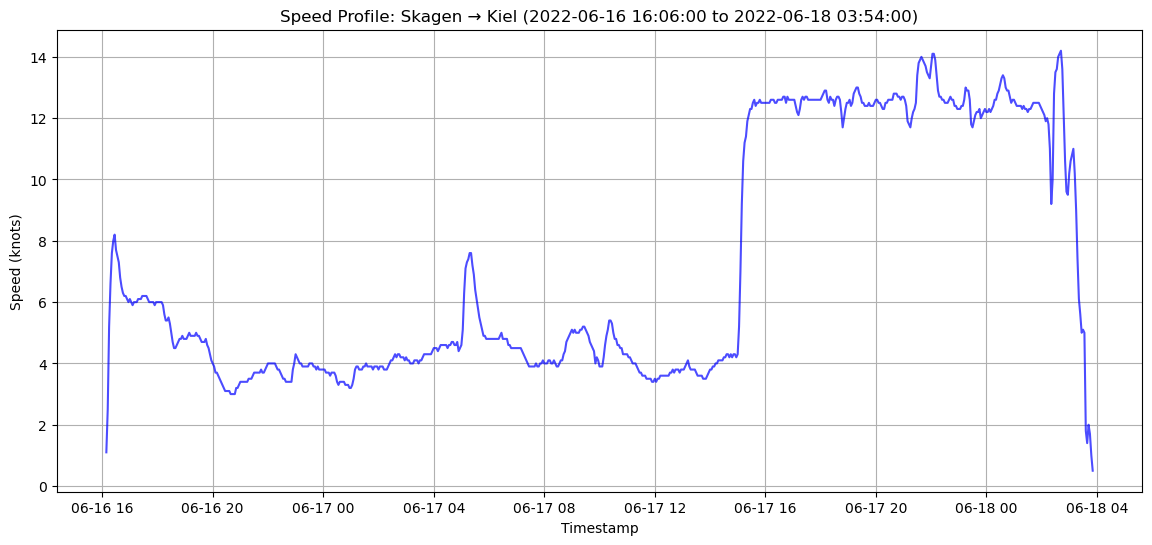

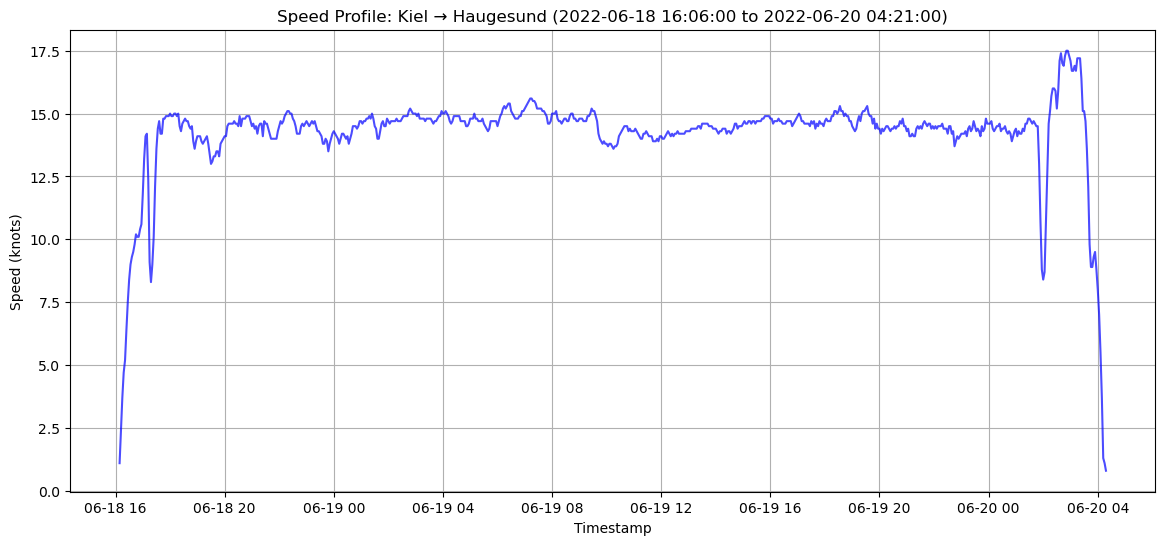

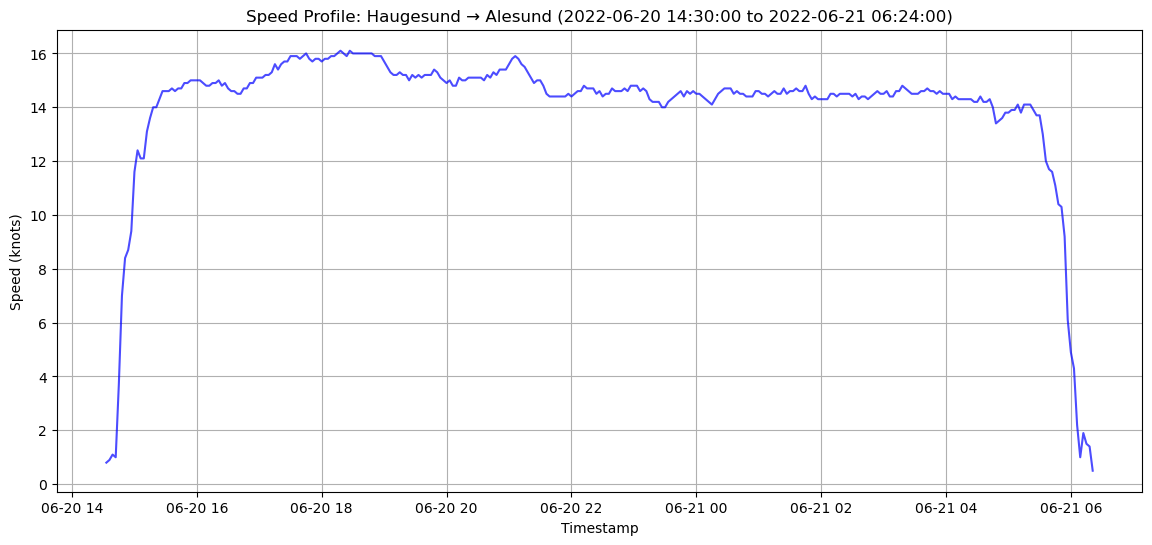

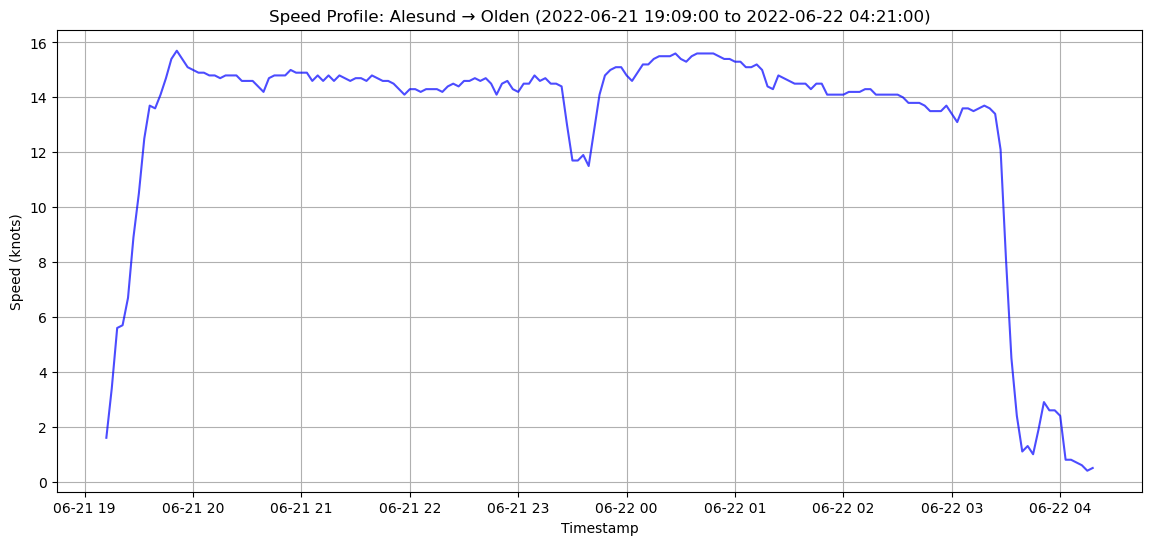

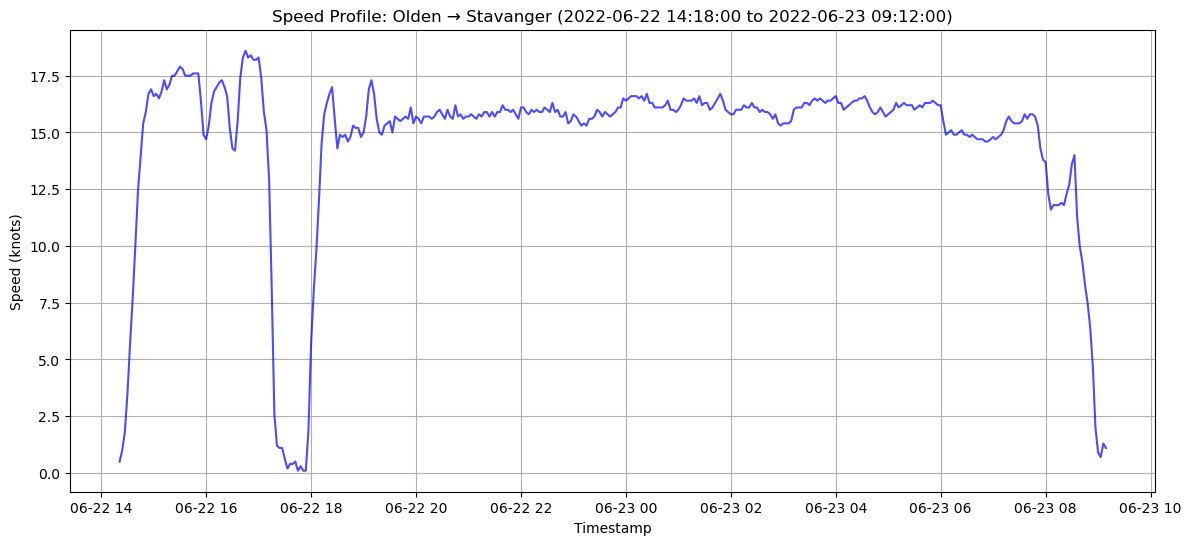

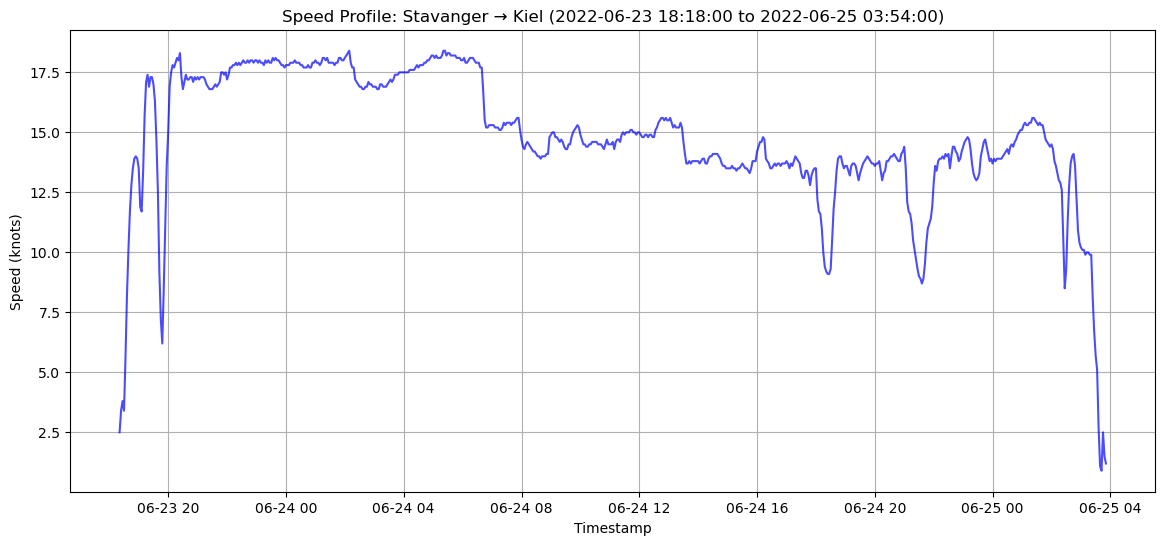

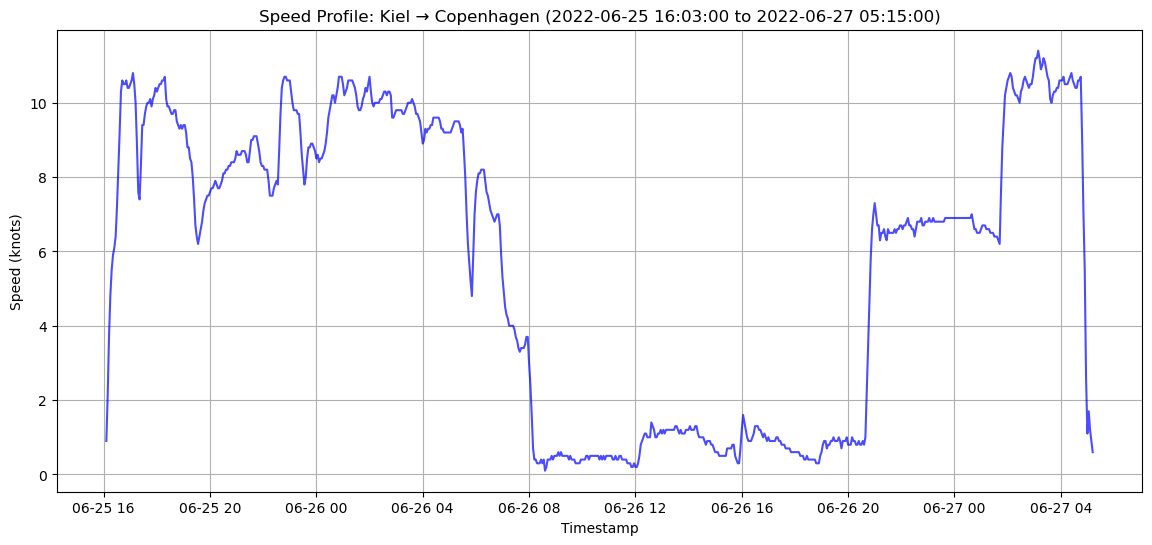

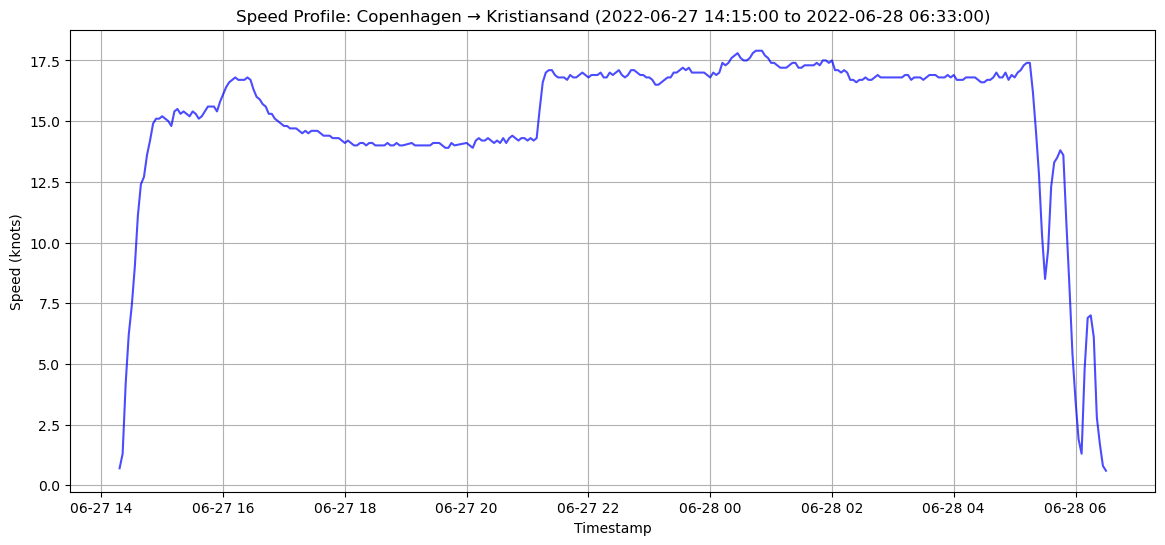

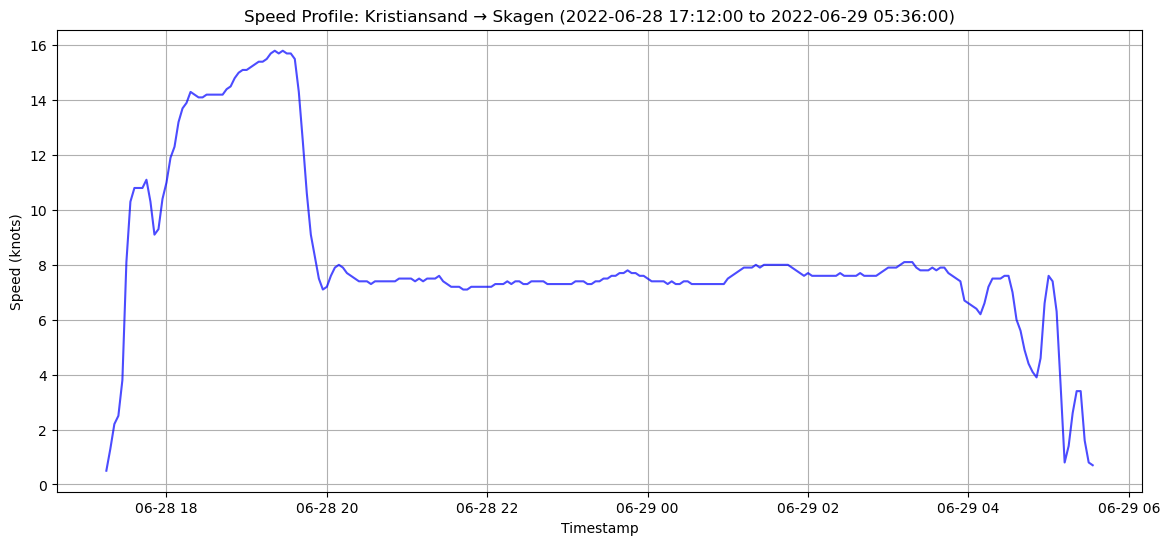

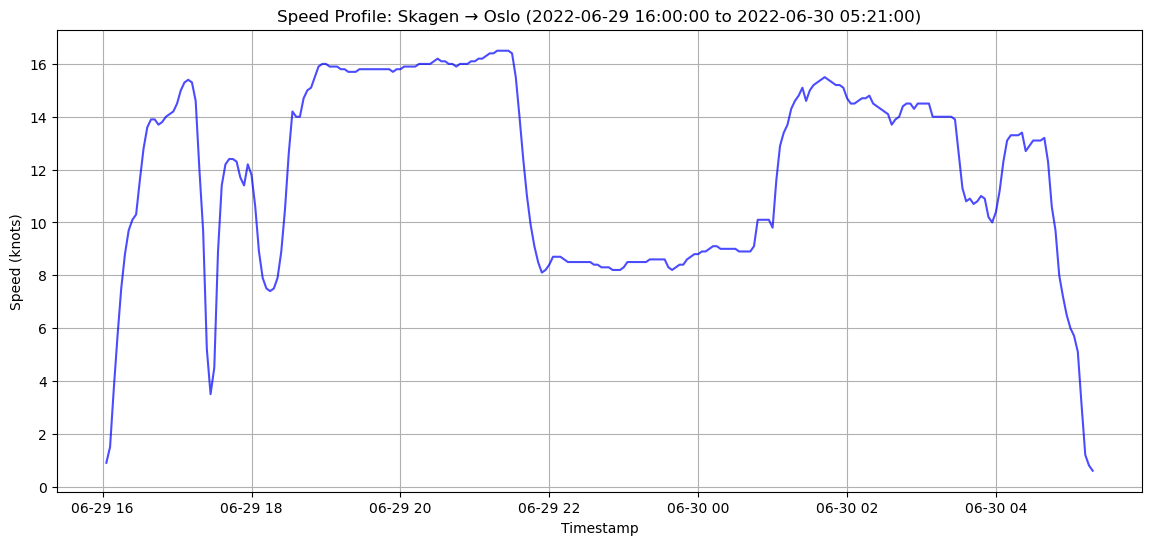

In [10]:
# Define the directory where plots will be saved
plot_dir = "plot"

# Create the "plot" folder if it doesn't exist
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
# Loop through port_calls_df to find transitions between different ports
for i in range(len(port_calls_df) - 1):
    current_port = port_calls_df.iloc[i]['port']
    next_port = port_calls_df.iloc[i + 1]['port']
    
    # Check if the port changes (i.e., ship departs to a new port)
    if current_port != next_port:
        start_time = port_calls_df.iloc[i]['end_time']  # Departure from current port
        end_time = port_calls_df.iloc[i + 1]['start_time']  # Arrival at next port
        
        # Filter the data for the sailing segment
        segment = data[(data['utc_time'] > start_time) & (data['utc_time'] < end_time)]
        
        # Only plot if there’s data in the segment
        if not segment.empty:
            plt.figure(figsize=(14, 6))
            plt.plot(segment['utc_time'], segment['SpeedOverGround'], color='blue', alpha=0.7)
            plt.title(f"Speed Profile: {current_port} → {next_port} ({start_time} to {end_time})")
            plt.xlabel('Timestamp')
            plt.ylabel('Speed (knots)')
            plt.grid(True)
            # Update the filename to include the "plot" directory
            filename = os.path.join(plot_dir, f"{i}_speed_profile_{current_port}_to_{next_port}.png")
            # Save the plot and close it
            plt.savefig(filename)
            plt.show()
            plt.close()

#### Q6
What was the **total time spent** in each port?

**Answer**

```text
Santa Cruz de Tenerife              479 hours   27 minutes
Las Palmas, Gran Canaria            341 hours   45 minutes
Arrecife, Lanzarote                 273 hours    0 minutes
Funchal, Madeira                    258 hours    6 minutes
Brest                               225 hours    0 minutes
IJmuiden                            191 hours   39 minutes
Puerto del Rosario, Fuerteventura   163 hours   42 minutes
Lisbon                              151 hours   21 minutes
Oslo                                 96 hours   42 minutes
Kiel                                 89 hours   12 minutes
Hamburg                              86 hours   48 minutes
Rotterdam                            64 hours   27 minutes
Kristiansand                         49 hours   21 minutes
Skagen                               46 hours    0 minutes
Copenhagen                           44 hours   15 minutes
Haugesund                            39 hours   39 minutes
Alesund                              36 hours    9 minutes
Nordfjordeid                         35 hours   15 minutes
La Coruna                            22 hours   51 minutes
Stavanger                            18 hours   15 minutes
Barcelona                            13 hours   48 minutes
Cherbourg                            11 hours    0 minutes
Olden                                 9 hours   57 minutes
Flam                                  9 hours   39 minutes
Bergen                                8 hours   48 minutes
Zeebrugge                             7 hours   36 minutes
```

In [11]:
total_time_per_port = port_calls_df.groupby('port')['duration'].sum()

# Sort by total duration descending
total_time_per_port = total_time_per_port.sort_values(ascending=False)

# Convert to hours and minutes 
def format_duration(td):
    total_minutes = int(td.total_seconds() // 60)
    hours = total_minutes // 60
    minutes = total_minutes % 60
    return f"{hours:>3} hours   {minutes:>2} minutes"

formatted_time = total_time_per_port.apply(format_duration)

# Dynamically determine the max width of port names
max_port_name_length = max(len(port) for port in formatted_time.index)

print("Total time spent in each port:\n")
for port, duration in formatted_time.items():
    print(f"{port:<{max_port_name_length}}   {duration}")


Total time spent in each port:

Santa Cruz de Tenerife              479 hours   27 minutes
Las Palmas, Gran Canaria            341 hours   45 minutes
Arrecife, Lanzarote                 273 hours    0 minutes
Funchal, Madeira                    258 hours    6 minutes
Brest                               225 hours    0 minutes
IJmuiden                            191 hours   39 minutes
Puerto del Rosario, Fuerteventura   163 hours   42 minutes
Lisbon                              151 hours   21 minutes
Oslo                                 96 hours   42 minutes
Kiel                                 89 hours   12 minutes
Hamburg                              86 hours   48 minutes
Rotterdam                            64 hours   27 minutes
Kristiansand                         49 hours   21 minutes
Skagen                               46 hours    0 minutes
Copenhagen                           44 hours   15 minutes
Haugesund                            39 hours   39 minutes
Alesund                 


#### Q7
How often was each port called?  
→ Please differentiate between **unique port calls**.

**Answer**

```text
Number of calls per port:
Santa Cruz de Tenerife               120
IJmuiden                              53
Las Palmas, Gran Canaria              15
Arrecife, Lanzarote                   14
Funchal, Madeira                      14
Puerto del Rosario, Fuerteventura     14
Kiel                                   7
Skagen                                 6
Oslo                                   5
Hamburg                                5
Copenhagen                             5
Nordfjordeid                           4
Haugesund                              4
Kristiansand                           4
Rotterdam                              3
Alesund                                3
Lisbon                                 3
La Coruna                              2
Stavanger                              2
Brest                                  1
Cherbourg                              1
Zeebrugge                              1
Barcelona                              1
Flam                                   1
Bergen                                 1
Olden                                  1
```


In [12]:
port_call_counts = port_calls_df['port'].value_counts()
print("Number of calls per port:")
print(port_call_counts)

Number of calls per port:
port
Santa Cruz de Tenerife               120
IJmuiden                              53
Las Palmas, Gran Canaria              15
Arrecife, Lanzarote                   14
Funchal, Madeira                      14
Puerto del Rosario, Fuerteventura     14
Kiel                                   7
Skagen                                 6
Oslo                                   5
Hamburg                                5
Copenhagen                             5
Nordfjordeid                           4
Haugesund                              4
Kristiansand                           4
Rotterdam                              3
Alesund                                3
Lisbon                                 3
La Coruna                              2
Stavanger                              2
Brest                                  1
Cherbourg                              1
Zeebrugge                              1
Barcelona                              1
Flam                      

## 🚀 Speed & Distance Insights (Q8 and Q9)


### Q8

What was the **highest average speed** between two ports?

**Answer**
```text
Highest average speed between two ports: 17.23 knots
```

In [13]:
# Identify sailing segments
port_calls_df = port_calls_df.sort_values('start_time')
sailing_segments = []
for i in range(len(port_calls_df) - 1):
    end_prev = port_calls_df.iloc[i]['end_time']
    start_next = port_calls_df.iloc[i + 1]['start_time']
    if end_prev < start_next:
        sailing_segments.append((end_prev, start_next))

# Include start and end of data if applicable
if data['utc_time'].min() < port_calls_df['start_time'].min():
    sailing_segments.insert(0, (data['utc_time'].min(), port_calls_df.iloc[0]['start_time']))
if data['utc_time'].max() > port_calls_df['end_time'].max():
    sailing_segments.append((port_calls_df.iloc[-1]['end_time'], data['utc_time'].max()))

# Calculate average speeds
average_speeds = []
for start, end in sailing_segments:
    segment_data = data[(data['utc_time'] > start) & (data['utc_time'] < end)]
    if len(segment_data) > 1:
        segment_distances = [calculate_distance(segment_data.iloc[j], segment_data.iloc[j + 1]) 
                             for j in range(len(segment_data) - 1)]
        total_distance = sum(segment_distances)
        total_time_hours = (segment_data['utc_time'].iloc[-1] - segment_data['utc_time'].iloc[0]).total_seconds() / 3600
        if total_time_hours > 0:
            avg_speed_knots = (total_distance / total_time_hours) / 1.852  # km/h to knots
            average_speeds.append(avg_speed_knots)

highest_avg_speed = max(average_speeds) if average_speeds else 0
print(f"Highest average speed between two ports: {highest_avg_speed:.2f} knots")


Highest average speed between two ports: 17.23 knots


### Q9

Can you create a few **interesting statistics/graphs**  
→ Focus on **speed, distance, sailing time**, etc.

**Answer**
```text
Cumulative distance travelled 62626.18 km
Average speed while sailing: 11.55 knots
Total sailing segments: 290

```

/var/folders/jb/8z0z81v948b24gtgwy8pv4780000gn/T/ipykernel_70943/608570053.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


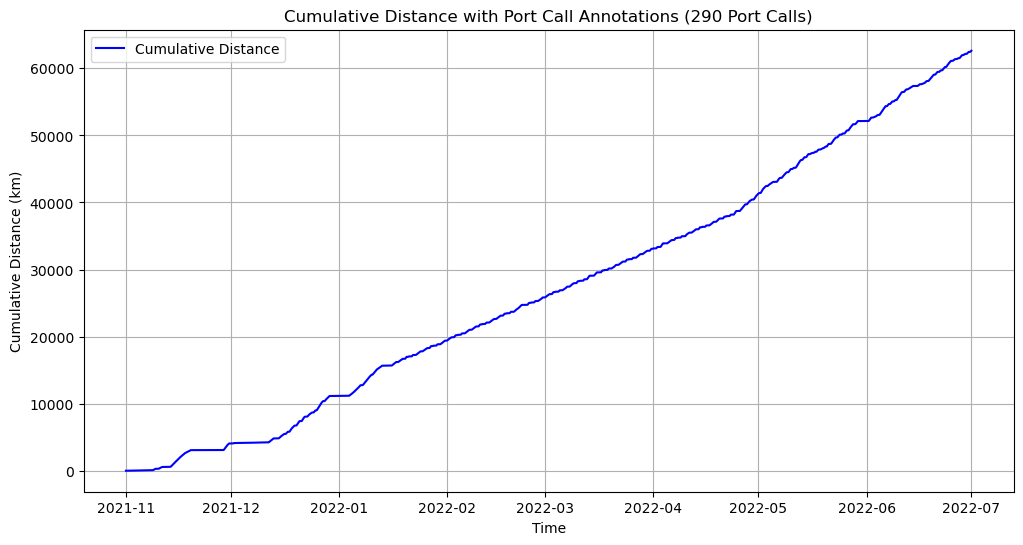

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'port_calls_df' is already loaded with 290 entries
# Example structure based on your sample:
# port_calls_df = pd.DataFrame({
#     'port': ['Santa Cruz de Tenerife', 'Santa Cruz de Tenerife', ..., 'Oslo'],
#     'start_time': pd.to_datetime(['2021-11-01 00:00:00', '2021-11-01 01:30:00', ..., '2022-06-30 05:21:00']),
#     'end_time': pd.to_datetime(['2021-11-01 01:24:00', '2021-11-01 03:00:00', ..., '2022-06-30 16:12:00']),
#     'duration': ['0 days 01:24:00', '0 days 01:30:00', ..., '0 days 10:51:00']
# })

# Reformat port_calls_df to the desired structure
port_calls = port_calls_df[['port', 'start_time', 'end_time']].rename(columns={'port': 'PortName'})

# Ensure start_time and end_time are datetime
port_calls['start_time'] = pd.to_datetime(port_calls['start_time'])
port_calls['end_time'] = pd.to_datetime(port_calls['end_time'])

# Assuming 'data' has ship movement data (with columns like utc_time, SpeedOverGround)
# Ensure 'data' is available and utc_time is datetime
# data = pd.read_csv('data.csv', parse_dates=['utc_time'])

# 1. Speed Profile by Voyage Segment
plt.figure(figsize=(12, 6))
for i in range(len(port_calls) - 1):
    start_time = port_calls['end_time'].iloc[i]
    end_time = port_calls['start_time'].iloc[i + 1]
    segment = data[(data['utc_time'] >= start_time) & (data['utc_time'] <= end_time)]
    if not segment.empty:
        normalized_time = np.linspace(0, 1, len(segment))
        plt.plot(normalized_time, segment['SpeedOverGround'], label=f'Voyage {i+1}: {port_calls["PortName"].iloc[i]} to {port_calls["PortName"].iloc[i+1]}')
plt.xlabel('Normalized Time (0 to 1)')
plt.ylabel('Speed Over Ground (knots)')
plt.title('Speed Profiles for Voyages Between Ports (290 Port Calls)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('speed_profile_voyages_290.png')
plt.close()

# 2. Distance Accumulation with Port Annotations
data['time_interval'] = data['utc_time'].diff().dt.total_seconds() / 3600  # in hours
data['distance_km'] = data['SpeedOverGround'] * data['time_interval'] * 1.852  # knots to km
data['cumulative_distance'] = data['distance_km'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(data['utc_time'], data['cumulative_distance'], color='blue', label='Cumulative Distance')
plt.xlabel('Time')
plt.ylabel('Cumulative Distance (km)')
plt.title('Cumulative Distance with Port Call Annotations (290 Port Calls)')
plt.legend()
plt.grid(True)
plt.savefig('Cumulative Distance of the ship.png')
plt.show()
print("")


In [15]:
print(f"Cummulative distance travelled {data['cumulative_distance'].iloc[-1]:.2f} km")

Cummulative distance travelled 62626.18 km


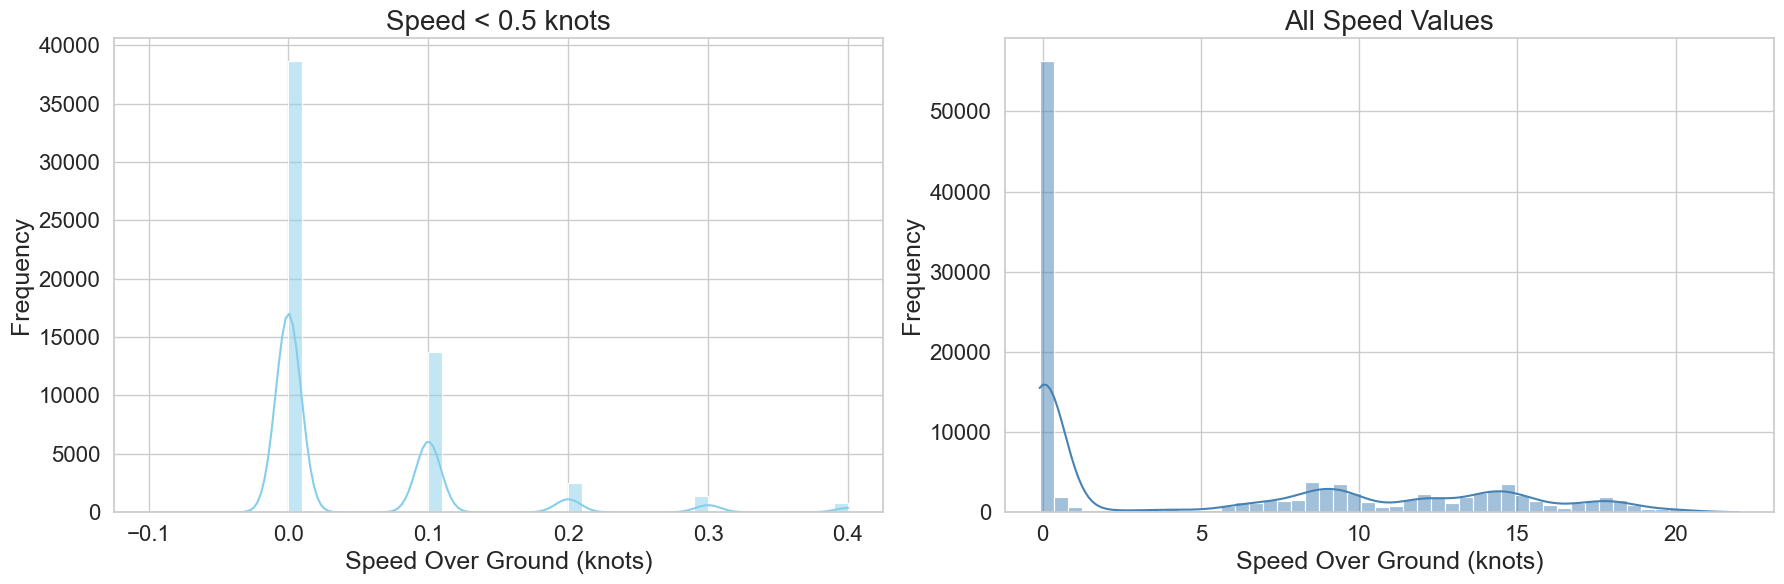

In [16]:

# Set a nice style
sns.set(style="whitegrid")

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histogram for speeds less than 0.5 knots (zoomed in on low speeds)
sns.histplot(data[data['SpeedOverGround'] < 0.5]['SpeedOverGround'], 
             bins=50, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Speed < 0.5 knots', fontsize=20)
axes[0].set_xlabel('Speed Over Ground (knots)', fontsize=18)
axes[0].set_ylabel('Frequency', fontsize=18)
axes[0].tick_params(axis='both', labelsize=16)  # ← increase tick label size

# Histogram for all speeds
sns.histplot(data['SpeedOverGround'], 
             bins=50, kde=True, color='steelblue', ax=axes[1])
axes[1].set_title('All Speed Values', fontsize=20)
axes[1].set_xlabel('Speed Over Ground (knots)', fontsize=18)
axes[1].set_ylabel('Frequency', fontsize=18)
axes[1].tick_params(axis='both', labelsize=16)  # ← increase tick label size

# Adjust spacing between plots
plt.tight_layout()
plt.savefig('Speed histogram.png')
# Show the plots
plt.show()

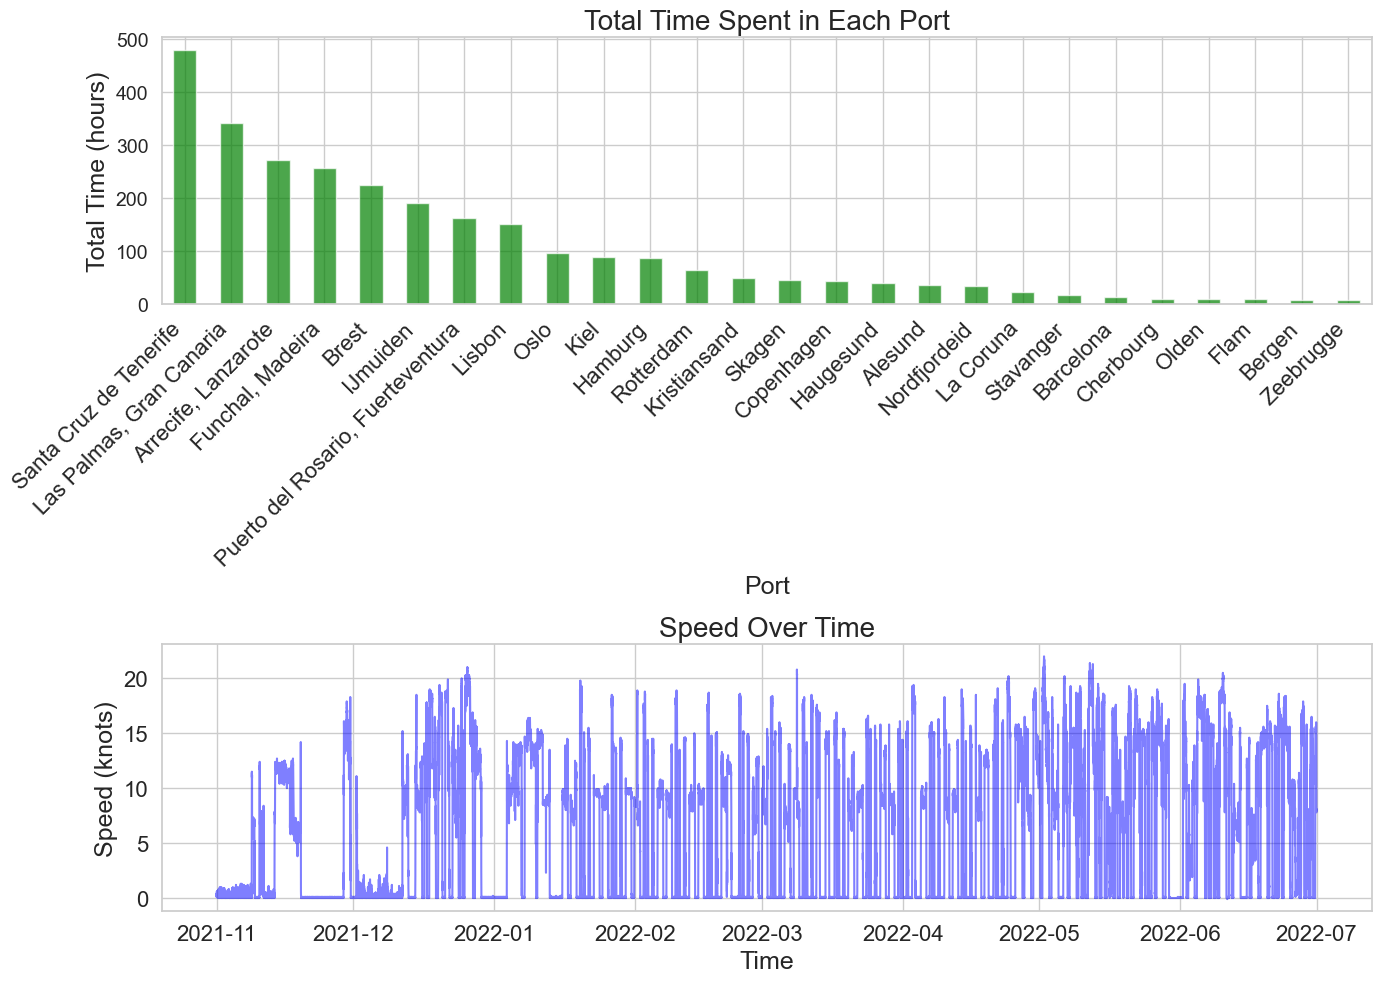

Average speed while sailing: 11.55 knots
Total sailing segments: 290


In [17]:
# Create a 2-row, 1-column subplot
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Bar chart of total time per port (in hours) → axes[0]
total_time_hours = total_time_per_port.dt.total_seconds() / 3600
total_time_hours.sort_values(ascending=False).plot(
    kind='bar',
    ax=axes[0],
    color='green',
    alpha=0.7
)
axes[0].set_title('Total Time Spent in Each Port', fontsize=20)
axes[0].set_xlabel('Port', fontsize=18)
axes[0].set_ylabel('Total Time (hours)', fontsize=18)
axes[0].tick_params(axis='x', labelsize=16, rotation=45)
axes[0].tick_params(axis='y', labelsize=14)
# Adjust X ticks to prevent overlap
axes[0].tick_params(axis='x', labelsize=16)  # X ticks font size set to 16
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")  # Adjust rotation and alignment

# Plot 2: Speed over time → axes[1]
axes[1].plot(data['utc_time'], data['SpeedOverGround'], color='blue', alpha=0.5)
axes[1].set_title('Speed Over Time', fontsize=20)
axes[1].set_xlabel('Time', fontsize=18)
axes[1].set_ylabel('Speed (knots)', fontsize=18)
axes[1].grid(True)
axes[1].tick_params(axis='both', labelsize=16)

# Layout and show
plt.tight_layout()
plt.savefig('total time spent in each port bar and speed over time.png', dpi=300, bbox_inches='tight')
plt.show()

# Stats
print(f"Average speed while sailing: {data[data['SpeedOverGround']>=0.5]['SpeedOverGround'].mean():.2f} knots")
print(f"Total sailing segments: {len(sailing_segments)}")


## 🕒 Port Call Insights (Q10 and Q11)



### Q10 

What was the **longest and shortest port call**?

**Answer**

```text
Longest port call: Brest with duration of 9 days 09 hours and 00 minutes
Shortest port call: Santa Cruz de Tenerife with duration of 0 days 00 hours and 30 minutes
```


In [18]:
def format_duration(td):
    total_minutes = int(td.total_seconds() // 60)
    days = td.days
    hours = (total_minutes // 60) % 24
    minutes = total_minutes % 60
    return f"{days} days {hours:02d} hours and {minutes:02d} minutes"

longest_call = port_calls_df.loc[port_calls_df['duration'].idxmax()]
shortest_call = port_calls_df.loc[port_calls_df['duration'].idxmin()]

print(f"Longest port call: {longest_call['port']} with duration of {format_duration(longest_call['duration'])}")
print(f"Shortest port call: {shortest_call['port']} with duration of {format_duration(shortest_call['duration'])}")


Longest port call: Brest with duration of 9 days 09 hours and 00 minutes
Shortest port call: Santa Cruz de Tenerife with duration of 0 days 00 hours and 30 minutes


### Q11

Create some **visualizations or statistics** about the **port calls**.

**Answer**

In [19]:

# Assuming 'data' and 'ports' are loaded as in the original .ipynb
# data = pd.read_csv('data/data.csv', sep=';', parse_dates=['utc_time'])
# ports = pd.read_csv('data/ports.csv', sep=';')

# Step 1: Identify stationary periods (SOG < 0.5 knots)
data = data.sort_values('utc_time').reset_index(drop=True)
stationary = data[data['SpeedOverGround'] < 0.5].copy()

# Step 2: Group consecutive stationary rows to detect port calls (≥30 minutes, i.e., ≥10 rows)
stationary['group'] = (stationary.index.diff() > 1).cumsum()
port_call_groups = stationary.groupby('group').filter(lambda x: len(x) >= 10)  # At least 10 rows

# Step 3: Compute port call details
port_calls_list = []
for group_id, group in port_call_groups.groupby('group'):
    start_time = group['utc_time'].min()
    end_time = group['utc_time'].max()
    duration_hours = (end_time - start_time).total_seconds() / 3600
    avg_lat = group['Latitude'].mean()
    avg_lon = group['Longitude'].mean()
    
    # Step 4: Find nearest port within ±0.5° or 50 km
    ports_coords = ports[['Latitude', 'Longitude']].values
    ship_coords = np.array([[avg_lat, avg_lon]])
    tree = cKDTree(ports_coords)
    dist, idx = tree.query(ship_coords, k=1)
    nearest_port = ports.iloc[idx[0]]
    
    # Check if within ±0.5° latitude/longitude or 50 km
    lat_diff = abs(avg_lat - nearest_port['Latitude'])
    lon_diff = abs(avg_lon - nearest_port['Longitude'])
    geo_dist_km = geodesic((avg_lat, avg_lon), (nearest_port['Latitude'], nearest_port['Longitude'])).km
    
    if (lat_diff <= 0.5 and lon_diff <= 0.5) or geo_dist_km <= 50:
        port_calls_list.append({
            'PortName': nearest_port['PortName'],
            'Latitude': avg_lat,
            'Longitude': avg_lon,
            'start_time': start_time,
            'end_time': end_time,
            'duration': duration_hours
        })

# Step 5: Create port_calls DataFrame
port_calls = pd.DataFrame(port_calls_list)

# Step 6: Calculate call_count
call_counts = port_calls['PortName'].value_counts().to_dict()
port_calls['call_count'] = port_calls['PortName'].map(call_counts)

# Step 7: Ensure desired format
port_calls = port_calls[['PortName', 'Latitude', 'Longitude', 'call_count', 'duration']]

# Print sample output
print("Sample port_calls DataFrame:")
print(port_calls.head())


Sample port_calls DataFrame:
                 PortName   Latitude  Longitude  call_count  duration
0  Santa Cruz de Tenerife  28.502204 -16.172894         128      1.40
1  Santa Cruz de Tenerife  28.502121 -16.172897         128      1.50
2  Santa Cruz de Tenerife  28.501746 -16.172857         128      5.20
3  Santa Cruz de Tenerife  28.502059 -16.173165         128      0.45
4  Santa Cruz de Tenerife  28.503520 -16.173414         128      5.70


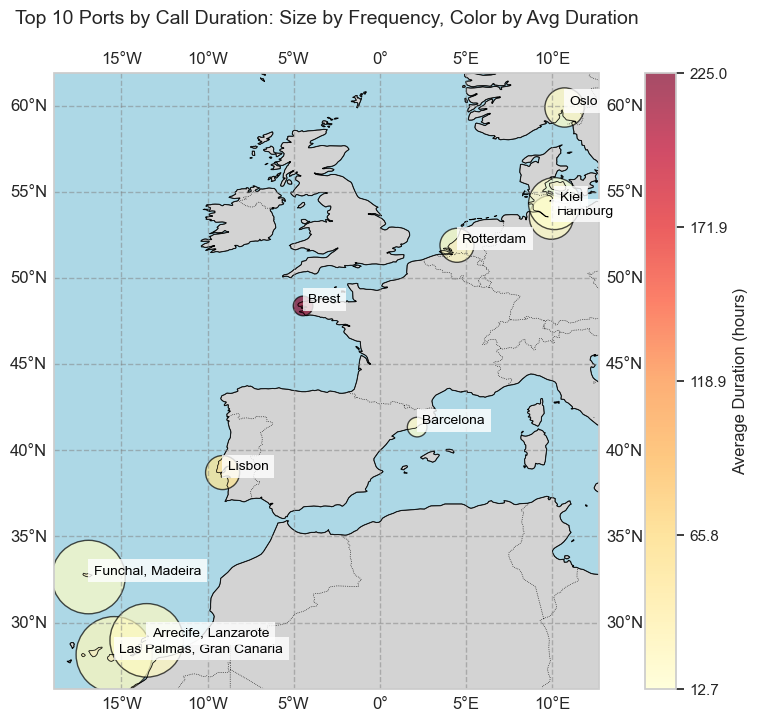

In [20]:


# Aggregate for mapping
port_summary = port_calls.groupby('PortName').agg({
    'Latitude': 'mean',
    'Longitude': 'mean',
    'call_count': 'mean',  # Use first call_count (same for all rows of a port)
    'duration': 'mean'
}).reset_index()

# Filter to top 5 ports by average duration
top_5_ports = port_summary.nlargest(10, 'duration')

# Create the geospatial plot with improved styling
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add map features with proper colors
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

# Set the map extent to focus on the region of interest (adjust buffer as needed)
buffer = 2  # Degrees around the min/max lat/lon
ax.set_extent([
    top_5_ports['Longitude'].min() - buffer,
    top_5_ports['Longitude'].max() + buffer,
    top_5_ports['Latitude'].min() - buffer,
    top_5_ports['Latitude'].max() + buffer
], crs=ccrs.PlateCarree())

# Scatter plot for top 5 ports: size by call_count, color by duration
scatter = ax.scatter(
    top_5_ports['Longitude'], top_5_ports['Latitude'],
    s=top_5_ports['call_count'] * 200,  # Scale size for visibility
    c=top_5_ports['duration'],
    cmap='YlOrRd',  # Use a more readable colormap
    alpha=0.7,
    edgecolors='black',
    transform=ccrs.PlateCarree()
)

# Add color bar with proper label and scaling
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('Average Duration (hours)', fontsize=12)
# Ensure color bar ticks are meaningful based on top 5 ports
cbar.set_ticks(np.linspace(top_5_ports['duration'].min(), top_5_ports['duration'].max(), 5))

# Add port name labels with better positioning
for i, row in top_5_ports.iterrows():
    # Adjust label position to avoid overlap (shift right and slightly up)
    ax.text(
        row['Longitude'] + 0.3,  # Shift right
        row['Latitude'] + 0.2,   # Shift up
        row['PortName'],
        transform=ccrs.PlateCarree(),
        fontsize=10,
        color='black',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )

# Add gridlines for better reference
ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)

# Set title
plt.title('Top 10 Ports by Call Duration: Size by Frequency, Color by Avg Duration', fontsize=14, pad=20)

# Save and display the plot
plt.savefig('top 10 port call map cartopy.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


/var/folders/jb/8z0z81v948b24gtgwy8pv4780000gn/T/ipykernel_70943/2270218066.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(durations_by_port, vert=True, labels=unique_ports)


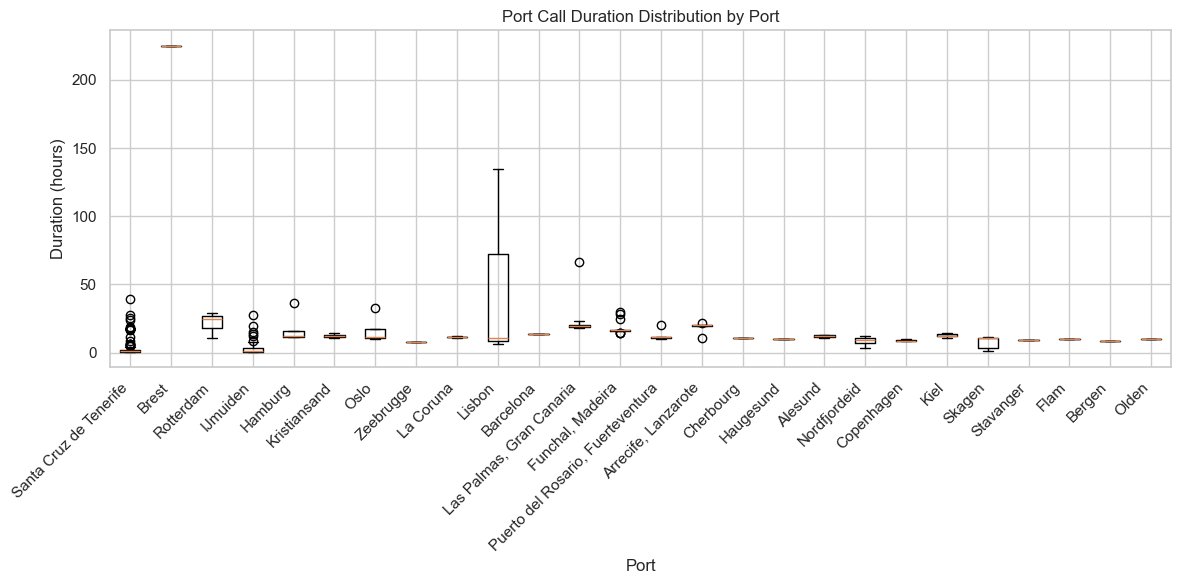

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'port_calls' is already created with columns 'PortName', 'start_time', 'end_time'
# Convert duration from timedelta to hours if not already done
if 'duration' not in port_calls.columns:
    port_calls['duration'] = (port_calls['end_time'] - port_calls['start_time']).dt.total_seconds() / 3600

# 2. Port Call Duration Box Plot by Port
plt.figure(figsize=(12, 6))  # Increase width dynamically based on number of ports
unique_ports = port_calls['PortName'].unique()
durations_by_port = [port_calls[port_calls['PortName'] == port]['duration'].values for port in unique_ports]
plt.boxplot(durations_by_port, vert=True, labels=unique_ports)

# Prevent x-axis label overlap
plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees and align right
plt.xlabel('Port')
plt.ylabel('Duration (hours)')
plt.title('Port Call Duration Distribution by Port')
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save and display the plot
plt.savefig('Port call duration distribution by ports.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## 🧭 Geo-Calculations & Energy (Q12 and Q13)


### Q12

Compute the **distance between two ports** using Latitude and Longitude.

**Answer**

We are considering the distance between ports that the ship has called. 
```text

Total distance from Santa Cruz de Tenerife to Olden: 17898.57 km (9664.46 nautical miles)

Distance from Santa Cruz de Tenerife to Brest: 2435.53 km
Distance from Brest to Rotterdam: 750.60 km
Distance from Rotterdam to IJmuiden: 69.74 km
Distance from IJmuiden to Hamburg: 398.95 km
Distance from Hamburg to Kristiansand: 526.79 km
Distance from Kristiansand to Oslo: 251.96 km
Distance from Oslo to Zeebrugge: 1065.44 km
Distance from Zeebrugge to La Coruna: 1242.35 km
Distance from La Coruna to Lisbon: 520.46 km
Distance from Lisbon to Barcelona: 1005.98 km
Distance from Barcelona to Las Palmas, Gran Canaria: 2173.49 km
Distance from Las Palmas, Gran Canaria to Funchal, Madeira: 522.37 km
Distance from Funchal, Madeira to Puerto del Rosario, Fuerteventura: 545.18 km
Distance from Puerto del Rosario, Fuerteventura to Arrecife, Lanzarote: 61.87 km
Distance from Arrecife, Lanzarote to Cherbourg: 2507.70 km
Distance from Cherbourg to Haugesund: 1174.77 km
Distance from Haugesund to Alesund: 342.93 km
Distance from Alesund to Nordfjordeid: 63.19 km
Distance from Nordfjordeid to Copenhagen: 791.86 km
Distance from Copenhagen to Kiel: 215.88 km
Distance from Kiel to Skagen: 367.48 km
Distance from Skagen to Stavanger: 348.69 km
Distance from Stavanger to Flam: 225.05 km
Distance from Flam to Bergen: 110.96 km
Distance from Bergen to Olden: 179.36 km
```

In [22]:

# Assuming 'port_calls_df' and 'port_data' are already loaded
# Get unique ports from port_calls_df
unique_ports = port_calls_df['port'].unique()
#print("Unique ports in order:", unique_ports)

# Assuming 'port_data' has columns: PortName, Latitude, Longitude
# Merge to get coordinates for unique ports
ports_with_coords = ports[ports['PortName'].isin(unique_ports)].copy()
port_mapping = dict(zip(ports_with_coords['PortName'], zip(ports_with_coords['Latitude'], ports_with_coords['Longitude'])))

# Get coordinates for each unique port in order
port_coords = [port_mapping[port] for port in unique_ports if port in port_mapping]

# Calculate total distance between consecutive ports
total_distance_km = 0
for i in range(len(port_coords) - 1):
    port1_coords = port_coords[i]
    port2_coords = port_coords[i + 1]
    distance_km = geodesic(port1_coords, port2_coords).km
    total_distance_km += distance_km
    print(f"Distance from {unique_ports[i]} to {unique_ports[i + 1]}: {distance_km:.2f} km")

# Convert total distance to nautical miles
total_distance_nm = total_distance_km / 1.852

# Print total distance
print(f"\nTotal distance from {unique_ports[0]} to {unique_ports[-1]}: {total_distance_km:.2f} km ({total_distance_nm:.2f} nautical miles)")

Distance from Santa Cruz de Tenerife to Brest: 2435.53 km
Distance from Brest to Rotterdam: 750.60 km
Distance from Rotterdam to IJmuiden: 69.74 km
Distance from IJmuiden to Hamburg: 398.95 km
Distance from Hamburg to Kristiansand: 526.79 km
Distance from Kristiansand to Oslo: 251.96 km
Distance from Oslo to Zeebrugge: 1065.44 km
Distance from Zeebrugge to La Coruna: 1242.35 km
Distance from La Coruna to Lisbon: 520.46 km
Distance from Lisbon to Barcelona: 1005.98 km
Distance from Barcelona to Las Palmas, Gran Canaria: 2173.49 km
Distance from Las Palmas, Gran Canaria to Funchal, Madeira: 522.37 km
Distance from Funchal, Madeira to Puerto del Rosario, Fuerteventura: 545.18 km
Distance from Puerto del Rosario, Fuerteventura to Arrecife, Lanzarote: 61.87 km
Distance from Arrecife, Lanzarote to Cherbourg: 2507.70 km
Distance from Cherbourg to Haugesund: 1174.77 km
Distance from Haugesund to Alesund: 342.93 km
Distance from Alesund to Nordfjordeid: 63.19 km
Distance from Nordfjordeid to Co

### Q13

Given the power demand function:  
f(v) = 6.874 × v³ − 83.274 × v² + 659.5 × v + 9010_  
→ Compute **total energy consumed** during **sailing time**.

**Answer**
```text
Total energy consumed during sailing time: 55375059.06 kWh
```

In [23]:
def power_demand(v):
    return 6.874 * v**3 - 83.274 * v**2 + 659.5 * v + 9010

data['time_interval_hours'] = data['time_interval'] / 60
data['power'] = data['SpeedOverGround'].apply(power_demand)
data['energy'] = data['power'] * data['time_interval_hours']
total_energy = data[data['SpeedOverGround'] >= SOG_THRESHOLD]['energy'].sum()
print(f"Total energy consumed during sailing time: {total_energy:.2f} kWh")

Total energy consumed during sailing time: 922909.65 kWh



## 🎯 Bonus Analysis (Q14)


### Q14

Compare the given `SpeedOverGround` with a **computed speed**  
→ Use Latitude & Longitude.  
→ Evaluate **signal quality**, provide **statistics** and **insights**.

```text
Percentage of points above upper limit(mean_diff + 1.96 * std_diff): 6.42%
Percentage of points below lower limit(mean_diff - 1.96 * std_diff): 6.52%
Percentage of points within limits: 87.06%
Mean Difference: -5.52e-18
Standard Deviation: 7.90e-16
Range of speed_diff: [-3.55e-15, 3.55e-15]
Correlation: 1.00
```

Mean Difference: -5.52e-18
Standard Deviation: 7.90e-16
Range of speed_diff: [-3.55e-15, 3.55e-15]


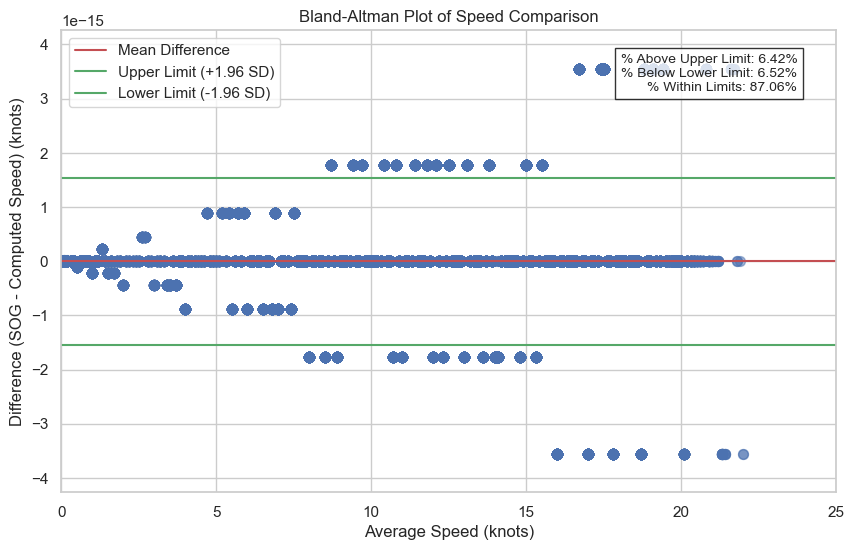

Percentage of points above upper limit (mean_diff + 1.96 * std_diff): 6.42%
Percentage of points below lower limit (mean_diff - 1.96 * std_diff): 6.52%
Percentage of points within limits: 87.06%


In [24]:
# Assuming 'data' is the DataFrame with ship movement data
# Compute speeds and differences
data['computed_speed'] = data['distance_km'] / data['time_interval']  # km/h
data['computed_speed_knots'] = data['computed_speed'] / 1.852  # Convert km/h to knots
data['speed_difference'] = data['SpeedOverGround'] - data['computed_speed_knots']

# 1. Bland-Altman Plot with Adjusted Y-Axis
data['speed_diff'] = data['speed_difference']  # Use the computed speed_difference
data['speed_avg'] = (data['SpeedOverGround'] + data['computed_speed_knots']) / 2
mean_diff = data['speed_diff'].mean()
std_diff = data['speed_diff'].std()
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Diagnostic prints to check values
print(f"Mean Difference: {mean_diff:.2e}")
print(f"Standard Deviation: {std_diff:.2e}")
print(f"Range of speed_diff: [{data['speed_diff'].min():.2e}, {data['speed_diff'].max():.2e}]")

# Calculate percentages for different regions
total_points = len(data)
above_upper = len(data[data['speed_diff'] > upper_limit])
below_lower = len(data[data['speed_diff'] < lower_limit])
within_limits = len(data[(data['speed_diff'] >= lower_limit) & (data['speed_diff'] <= upper_limit)])
outside_limits = above_upper + below_lower

percentage_above_upper = (above_upper / total_points) * 100
percentage_below_lower = (below_lower / total_points) * 100
percentage_within_limits = (within_limits / total_points) * 100
percentage_outside = (outside_limits / total_points) * 100

# Create the Bland-Altman plot
plt.figure(figsize=(10, 6))
plt.scatter(data['speed_avg'], data['speed_diff'], alpha=0.5, s=50)
plt.axhline(y=mean_diff, color='r', linestyle='-', label='Mean Difference')
plt.axhline(y=upper_limit, color='g', linestyle='-', label='Upper Limit (+1.96 SD)')
plt.axhline(y=lower_limit, color='g', linestyle='-', label='Lower Limit (-1.96 SD)')
plt.xlabel('Average Speed (knots)')
plt.ylabel('Difference (SOG - Computed Speed) (knots)')
plt.title('Bland-Altman Plot of Speed Comparison')

# Adjust y-axis dynamically based on speed_diff range
y_buffer = 0.1 * (data['speed_diff'].max() - data['speed_diff'].min()) if (data['speed_diff'].max() - data['speed_diff'].min()) != 0 else 1
plt.ylim(data['speed_diff'].min() - y_buffer, data['speed_diff'].max() + y_buffer)
plt.xlim(0, 25)  # Adjusted x-axis to reasonable speed range
plt.legend()

# Add detailed percentages as annotation
annotation_text = (
    f'% Above Upper Limit: {percentage_above_upper:.2f}%\n'
    f'% Below Lower Limit: {percentage_below_lower:.2f}%\n'
    f'% Within Limits: {percentage_within_limits:.2f}%'
)
plt.text(
    0.95, 0.95,  # Position in axes coordinates (top-right corner)
    annotation_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
)

plt.grid(True)
plt.savefig('Bland-Altman Plot of Speed Comparison and statistics.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Also print the percentages for reference
print(f"Percentage of points above upper limit (mean_diff + 1.96 * std_diff): {percentage_above_upper:.2f}%")
print(f"Percentage of points below lower limit (mean_diff - 1.96 * std_diff): {percentage_below_lower:.2f}%")
print(f"Percentage of points within limits: {percentage_within_limits:.2f}%")

Mean difference: -5.52e-18 knots
Std deviation: 7.90e-16 knots
Correlation: 1.00


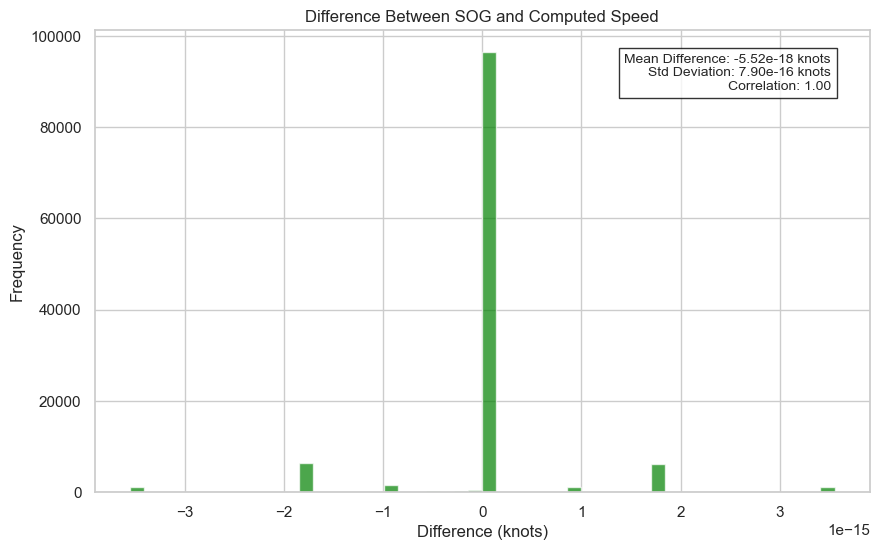

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Compute speeds and differences
data['computed_speed'] = data['distance_km'] / (data['time_interval'])  # km/h
data['computed_speed_knots'] = data['computed_speed'] / 1.852  # Convert km/h to knots
data['speed_difference'] = data['SpeedOverGround'] - data['computed_speed_knots']

# Calculate statistics
mean_diff = data['speed_difference'].mean()
std_diff = data['speed_difference'].std()
correlation = data['SpeedOverGround'].corr(data['computed_speed_knots'])

# Print statistics (as before)
print(f"Mean difference: {mean_diff:.2e} knots")
print(f"Std deviation: {std_diff:.2e} knots")
print(f"Correlation: {correlation:.2f}")

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(data['speed_difference'].dropna(), bins=50, color='green', alpha=0.7)
plt.title('Difference Between SOG and Computed Speed')
plt.xlabel('Difference (knots)')
plt.ylabel('Frequency')
plt.grid(True)

# Add statistics as annotation on the plot
annotation_text = (
    f'Mean Difference: {mean_diff:.2e} knots\n'
    f'Std Deviation: {std_diff:.2e} knots\n'
    f'Correlation: {correlation:.2f}'
)
plt.text(
    0.95, 0.95,  # Position in axes coordinates (top-right corner)
    annotation_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
)

# Save and display the plot
plt.savefig('Error plot SOG and computed speed.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## 🎯 Make a Video (Bonus from myside)

In [26]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# from scipy.interpolate import interp1d

# # Step 1: Load and prepare the AIS data
# data = pd.read_csv('data/data.csv', sep=';', parse_dates=['utc_time'])  # Replace with your file path
# data = data.sort_values('utc_time')
# start_time = data['utc_time'].min()
# data['time_since_start'] = (data['utc_time'] - start_time).dt.total_seconds()
# total_time = data['time_since_start'].max()

# # Step 2: Create interpolation functions for latitude and longitude
# lat_interp = interp1d(data['time_since_start'], data['Latitude'], kind='linear', fill_value="extrapolate")
# lon_interp = interp1d(data['time_since_start'], data['Longitude'], kind='linear', fill_value="extrapolate")

# # Step 3: Set up the map with Cartopy
# fig = plt.figure(figsize=(12, 6))
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
# ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS, linestyle=':')

# # Set map extent based on the journey with padding
# min_lon, max_lon = data['Longitude'].min(), data['Longitude'].max()
# min_lat, max_lat = data['Latitude'].min(), data['Latitude'].max()
# ax.set_extent([min_lon - 5, max_lon + 5, min_lat - 5, max_lat + 5], crs=ccrs.PlateCarree())

# # Plot the entire path
# ax.plot(data['Longitude'], data['Latitude'], transform=ccrs.PlateCarree(), color='blue', alpha=0.5)

# # Step 4: Initialize animation elements
# path_line, = ax.plot([], [], color='red', transform=ccrs.PlateCarree())  # Path up to current position
# marker, = ax.plot([], [], 'ro', transform=ccrs.PlateCarree())  # Ship marker
# time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, ha='left', va='top')  # Timestamp

# # Step 5: Define the animation update function
# def update(frame):
#     journey_time = (frame / total_frames) * total_time
#     if journey_time > total_time:
#         journey_time = total_time
#     # Update path line up to current time
#     past_points = data[data['time_since_start'] <= journey_time]
#     path_line.set_data(past_points['Longitude'], past_points['Latitude'])
#     # Update ship marker position
#     lat = lat_interp(journey_time)
#     lon = lon_interp(journey_time)
#     marker.set_data([lon], [lat])
#     # Update timestamp
#     current_time = start_time + pd.Timedelta(seconds=journey_time)
#     time_text.set_text(current_time.strftime('%Y-%m-%d %H:%M:%S'))
#     return path_line, marker, time_text

# # Step 6: Set animation parameters
# video_duration = 60  # seconds
# frame_rate = 30  # frames per second
# total_frames = video_duration * frame_rate

# # Step 7: Create and save the animation
# anim = FuncAnimation(fig, update, frames=total_frames, interval=1000 / frame_rate, blit=True)
# anim.save('ship_path.mp4', writer='ffmpeg')

# plt.close()  # Optional: Close the figure to free memory

In [27]:
# from moviepy.editor import VideoFileClip

# # Load the original video (replace with your video file path)
# original_video_path = 'ship_path.mp4'
# clip = VideoFileClip(original_video_path)

# # Calculate the duration of the original video in seconds (1 hour = 3600 seconds)
# original_duration = clip.duration

# # Desired duration of the final video in seconds (2 minutes = 120 seconds)
# desired_duration = 90

# # Calculate the speed factor (3600 / 120 = 30x faster)
# speed_factor = original_duration / desired_duration

# # Speed up the video
# fast_forwarded_clip = clip.speedx(factor=speed_factor)

# # Save the fast-forwarded video (replace with your desired output path)
# output_video_path = 'ship_path_fast_forwarded.mp4'
# fast_forwarded_clip.write_videofile(output_video_path, codec='libx264')

# print(f"Fast-forwarded video saved to {output_video_path}")